# Previsão do valor de abertura de ações usando classificadores baseado no uso de indicadores

#Obtenção de dados e preparação do ambiente

##Bibliotecas

In [ ]:
!pip install yfinance pandas matplotlib statsmodels
!pip install ta
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
from numpy import array
from datetime import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import ta

from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB # SVM
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=eac7a47bbc1356c26045ba89a39320c81033c5863910d2be61288383995891e8
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


## Obtenção de dados e tratamento inicial

In [ ]:
# ATIVOS:
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# OBS: O tratamento inicial temos que como queremos

# Ações (Stocks):

# ALIBABA (BABA)
data_inicio_baba = "2023-04-01"# Q2, Q3, Q4 (2023) até meio do Q1(2024)
data_fim_baba = "2024-02-10"

def datababa():
  df_baba = yf.download("BABA", start=data_inicio_baba, end=data_fim_baba).reset_index()
  df_baba.reset_index(inplace=True)
  return df_baba

data_inicio_amd = "2023-04-01"# Q2, Q3, Q4 (2023) até meio do Q1(2024)
data_fim_amd = "2024-02-10"

# Advanced Micro Devices, INC.

def dataamd():
  df_amd = yf.download("AMD", start=data_inicio_amd, end=data_fim_amd).reset_index()
  df_amd.reset_index(inplace=True)
  return df_amd

# Commodities:
# HG=F (Cobre Americano)

# Deixando mesmo periodo do que a ação
data_inicio_cobre = data_inicio_baba
data_fim_cobre = data_fim_baba

def datacob():
  df_cob = yf.download("HG=F", start=data_inicio_cobre, end=data_fim_cobre).reset_index()
  df_cob.reset_index(inplace=True)
  return df_cob

# SI-F (Prata Americano)

data_inicio_prata = data_inicio_cobre
data_fim_prata = data_fim_cobre

def datasil():
  df_sil = yf.download("SI=F", start=data_inicio_prata, end=data_fim_prata).reset_index()
  df_sil.reset_index(inplace = True)
  return df_sil

# Criptomoedas (Cryptocurrencies)
# MONERO (Em Dolar)

data_inicio_xmr = "2023-02-10" # 1 ano de data histórica
data_fim_xmr= "2024-02-10"

def dataxmr():
  df_xmr = yf.download('XMR-USD', start=data_inicio_xmr, end=data_fim_xmr).reset_index()
  df_xmr.reset_index(inplace=True)
  return df_xmr


# LITECOIN (Em Dolar)

data_inicio_ltc = "2023-02-10" # 1 ano de data histórica
data_fim_ltc= "2024-02-10"

def dataltc():
  df_ltc = yf.download('LTC-USD', start=data_inicio_ltc, end=data_fim_ltc).reset_index()
  df_ltc.reset_index(inplace=True)
  return df_ltc

## Função de amostragem

In [ ]:
# Função amostragem
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):
        break
    # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
      X.append(seq_x)
      y.append(seq_y)
    return array(X), array(y)

In [ ]:
datababa()

[*********************100%%**********************]  1 of 1 completed


index       Date        Open        High         Low       Close  \
0        0 2023-04-03  100.889999  101.750000   97.610001   98.389999   
1        1 2023-04-04   98.940002  101.470001   97.260002  100.720001   
2        2 2023-04-05   99.239998  100.449997   97.660004   98.550003   
3        3 2023-04-06   98.529999  103.239998   98.269997  102.739998   
4        4 2023-04-10  100.620003  102.830002  100.589996  101.540001   
..     ...        ...         ...         ...         ...         ...   
211    211 2024-02-05   72.169998   75.150002   71.860001   74.629997   
212    212 2024-02-06   77.044998   78.339996   75.730003   78.230003   
213    213 2024-02-07   74.555000   76.169998   73.150002   73.639999   
214    214 2024-02-08   71.885002   73.199997   70.650002   70.779999   
215    215 2024-02-09   70.800003   72.084999   70.000000   72.019997   

     Adj Close    Volume  
0    95.019806  26888100  
1    97.269997  26868400  
2    95.174332  20117700  
3    99.220802  26849200  
4    98.061913  16308300  
..         ...       ...  
211  73.042526  27721000  
212  76.565956  39069100  
213  72.073593  53766300  
214  69.274422  33070600  
215  70.488045  18998400  

[216 rows x 8 columns]

In [ ]:
dataamd()

[*********************100%%**********************]  1 of 1 completed


index       Date        Open        High         Low       Close  \
0        0 2023-04-03   96.699997   96.790001   94.809998   96.559998   
1        1 2023-04-04   97.040001   97.269997   95.209999   95.870003   
2        2 2023-04-05   94.349998   94.500000   91.360001   92.559998   
3        3 2023-04-06   91.470001   92.910004   90.620003   92.470001   
4        4 2023-04-10   91.320000   95.800003   91.019997   95.480003   
..     ...        ...         ...         ...         ...         ...   
211    211 2024-02-05  179.089996  180.009995  171.110001  174.229996   
212    212 2024-02-06  173.149994  173.880005  165.500000  167.880005   
213    213 2024-02-07  169.470001  172.970001  168.199997  170.940002   
214    214 2024-02-08  170.330002  172.169998  168.600006  169.350006   
215    215 2024-02-09  171.000000  175.100006  168.660004  172.479996   

      Adj Close    Volume  
0     96.559998  50655300  
1     95.870003  43195900  
2     92.559998  52979300  
3     92.470001  47778400  
4     95.480003  52536300  
..          ...       ...  
211  174.229996  76349200  
212  167.880005  68854100  
213  170.940002  53665400  
214  169.350006  43385300  
215  172.479996  56375700  

[216 rows x 8 columns]

In [ ]:
datacob()

[*********************100%%**********************]  1 of 1 completed


index       Date    Open    High     Low   Close  Adj Close  Volume
0        0 2023-04-03  4.0965  4.0965  4.0560  4.0595     4.0595     398
1        1 2023-04-04  4.0660  4.0660  3.9740  3.9835     3.9835     372
2        2 2023-04-05  3.9790  3.9980  3.9580  3.9980     3.9980     274
3        3 2023-04-06  4.0370  4.0370  3.9975  4.0260     4.0260       0
4        4 2023-04-10  3.9885  3.9980  3.9780  3.9865     3.9865     230
..     ...        ...     ...     ...     ...     ...        ...     ...
212    212 2024-02-05  3.8050  3.8050  3.7670  3.7720     3.7720     372
213    213 2024-02-06  3.7765  3.7915  3.7765  3.7825     3.7825     327
214    214 2024-02-07  3.7845  3.7845  3.7350  3.7375     3.7375     351
215    215 2024-02-08  3.7425  3.7425  3.6920  3.7055     3.7055     383
216    216 2024-02-09  3.6965  3.6965  3.6860  3.6860     3.6860     324

[217 rows x 8 columns]

In [ ]:
datasil()

[*********************100%%**********************]  1 of 1 completed


index       Date       Open       High        Low      Close  Adj Close  \
0        0 2023-04-03  23.725000  24.070000  23.695000  23.941000  23.941000   
1        1 2023-04-04  24.415001  25.084999  24.415001  25.021999  25.021999   
2        2 2023-04-05  25.115000  25.145000  24.790001  24.962999  24.962999   
3        3 2023-04-06  24.670000  25.030001  24.670000  25.025000  25.025000   
4        4 2023-04-10  24.850000  24.850000  24.846001  24.846001  24.846001   
..     ...        ...        ...        ...        ...        ...        ...   
211    211 2024-02-05  22.490000  22.490000  22.285000  22.334999  22.334999   
212    212 2024-02-06  22.455000  22.455000  22.334999  22.393000  22.393000   
213    213 2024-02-07  22.340000  22.405001  22.278000  22.278000  22.278000   
214    214 2024-02-08  22.490000  22.565001  22.299999  22.565001  22.565001   
215    215 2024-02-09  22.405001  22.565001  22.405001  22.528000  22.528000   

     Volume  
0        26  
1        24  
2        74  
3         0  
4         8  
..      ...  
211      36  
212     405  
213      69  
214     154  
215       7  

[216 rows x 8 columns]

In [ ]:
dataxmr()

[*********************100%%**********************]  1 of 1 completed


index       Date        Open        High         Low       Close  \
0        0 2023-02-10  152.462753  158.471649  151.728424  154.554474   
1        1 2023-02-11  154.559174  161.592148  153.909592  161.501602   
2        2 2023-02-12  161.494888  162.972458  158.258987  159.310593   
3        3 2023-02-13  159.343689  161.861832  153.885513  155.949844   
4        4 2023-02-14  155.947952  159.111725  154.443634  158.355774   
..     ...        ...         ...         ...         ...         ...   
360    360 2024-02-05  165.794281  167.882675  163.527481  165.355850   
361    361 2024-02-06  165.294983  166.535522  101.138847  104.977516   
362    362 2024-02-07  105.000443  133.915619  104.142029  129.953049   
363    363 2024-02-08  129.934341  131.457550  118.227730  127.912910   
364    364 2024-02-09  128.201111  129.067871  120.031158  121.915337   

      Adj Close     Volume  
0    154.554474   99139499  
1    161.501602   89797854  
2    159.310593   76572461  
3    155.949844  106473889  
4    158.355774  105604607  
..          ...        ...  
360  165.355850   62301595  
361  104.977516  294363740  
362  129.953049  248072044  
363  127.912910  123335948  
364  121.915337  106467375  

[365 rows x 8 columns]

In [ ]:
dataltc()

[*********************100%%**********************]  1 of 1 completed


index       Date       Open       High        Low      Close  Adj Close  \
0        0 2023-02-10  92.095055  94.044289  91.370094  93.529282  93.529282   
1        1 2023-02-11  93.530563  94.707855  93.039055  94.430550  94.430550   
2        2 2023-02-12  94.420914  94.524567  91.603996  92.395737  92.395737   
3        3 2023-02-13  92.397247  94.670494  88.849525  91.121750  91.121750   
4        4 2023-02-14  91.125099  95.766182  90.535202  95.687576  95.687576   
..     ...        ...        ...        ...        ...        ...        ...   
360    360 2024-02-05  66.932289  68.132332  66.714020  67.619415  67.619415   
361    361 2024-02-06  67.619270  68.751411  67.555908  68.290985  68.290985   
362    362 2024-02-07  68.292206  68.742569  67.754036  68.556030  68.556030   
363    363 2024-02-08  68.561722  70.607178  68.456512  70.562767  70.562767   
364    364 2024-02-09  70.569008  71.859253  70.354332  70.677048  70.677048   

        Volume  
0    636744666  
1    410760115  
2    367491351  
3    681702114  
4    594958420  
..         ...  
360  204854690  
361  215034847  
362  243889376  
363  271057492  
364  396248689  

[365 rows x 8 columns]

# Análise dos Dados

## Gráfico Dispersão (QQ Plot)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


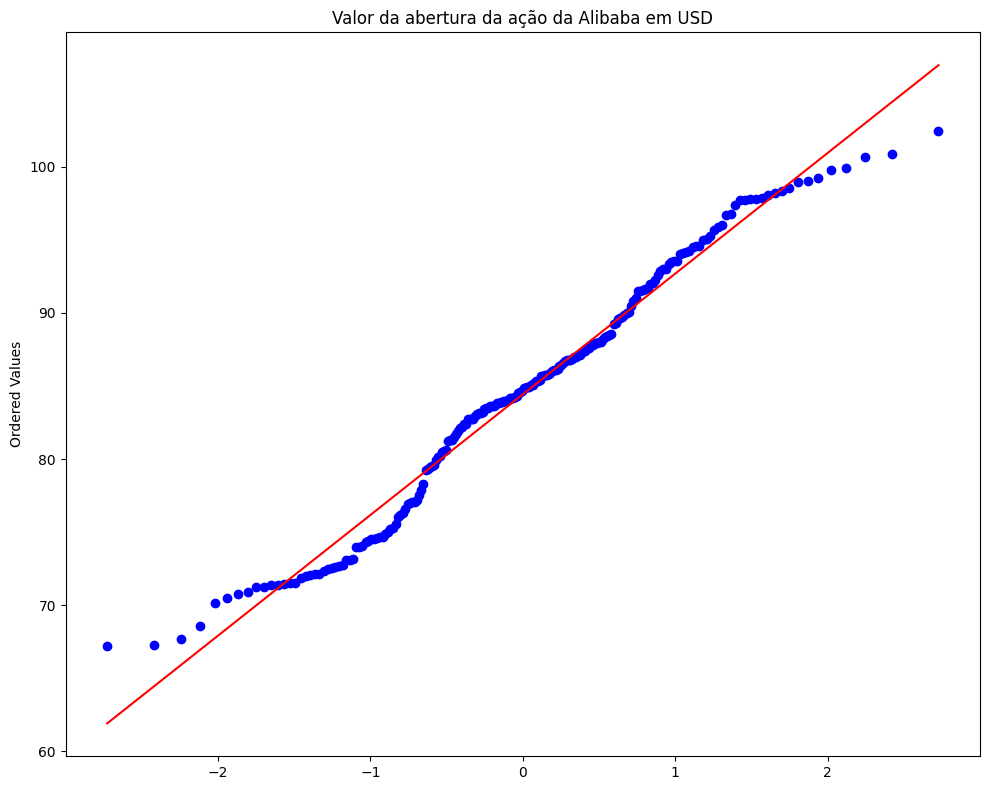

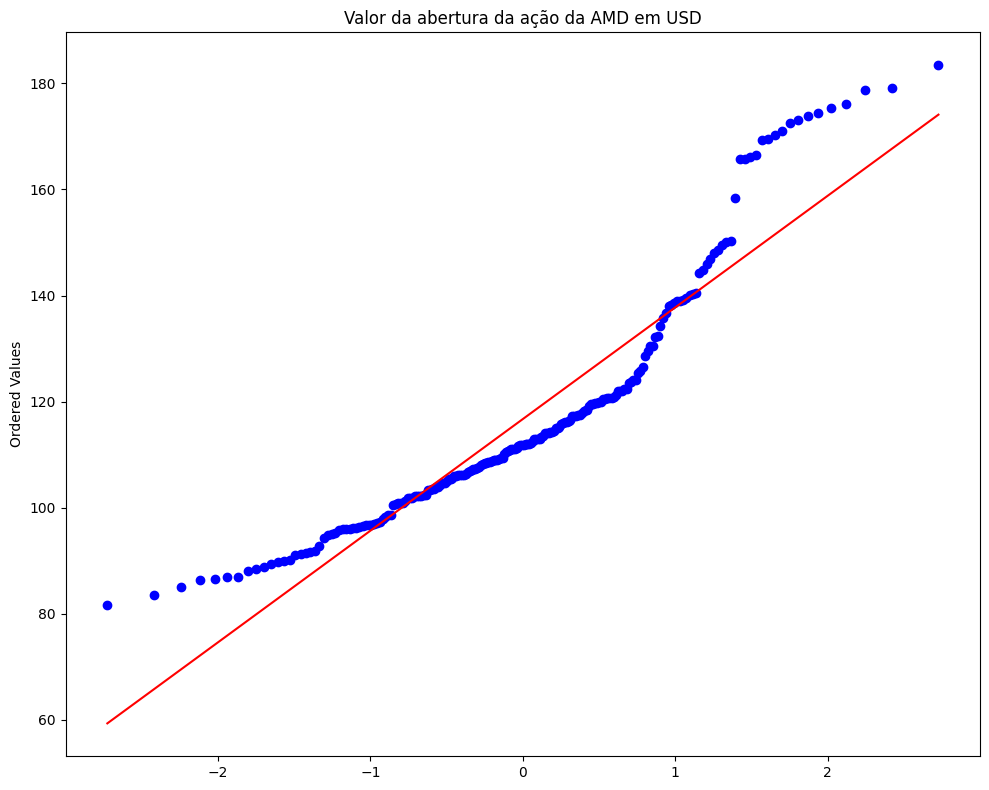

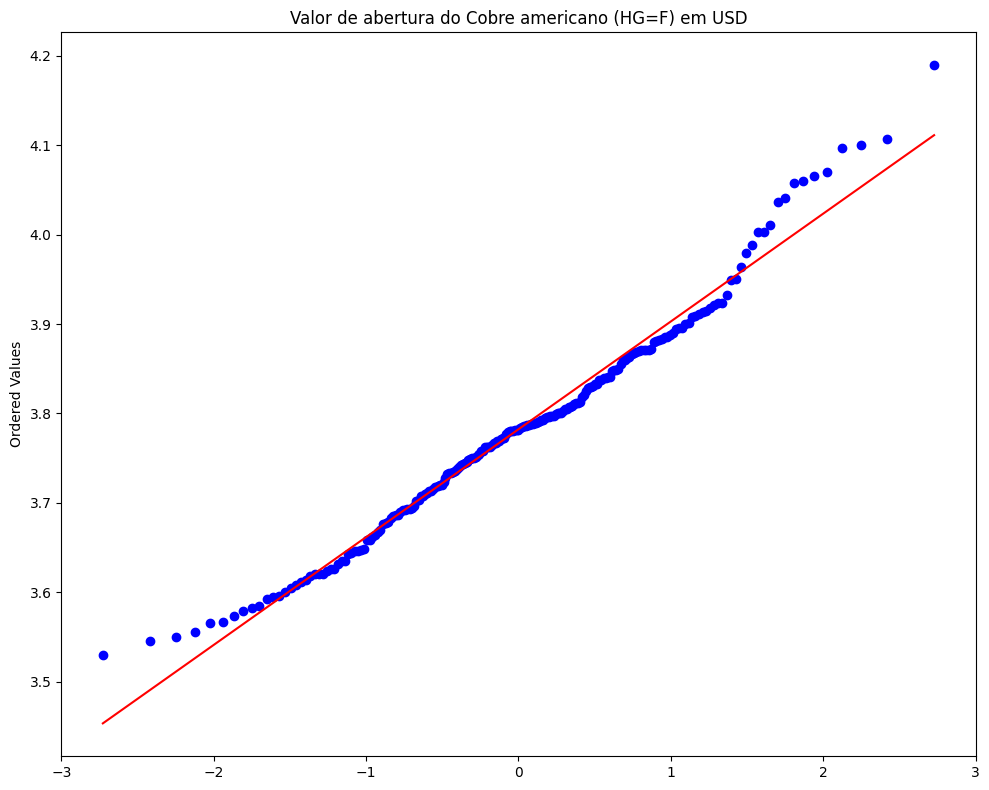

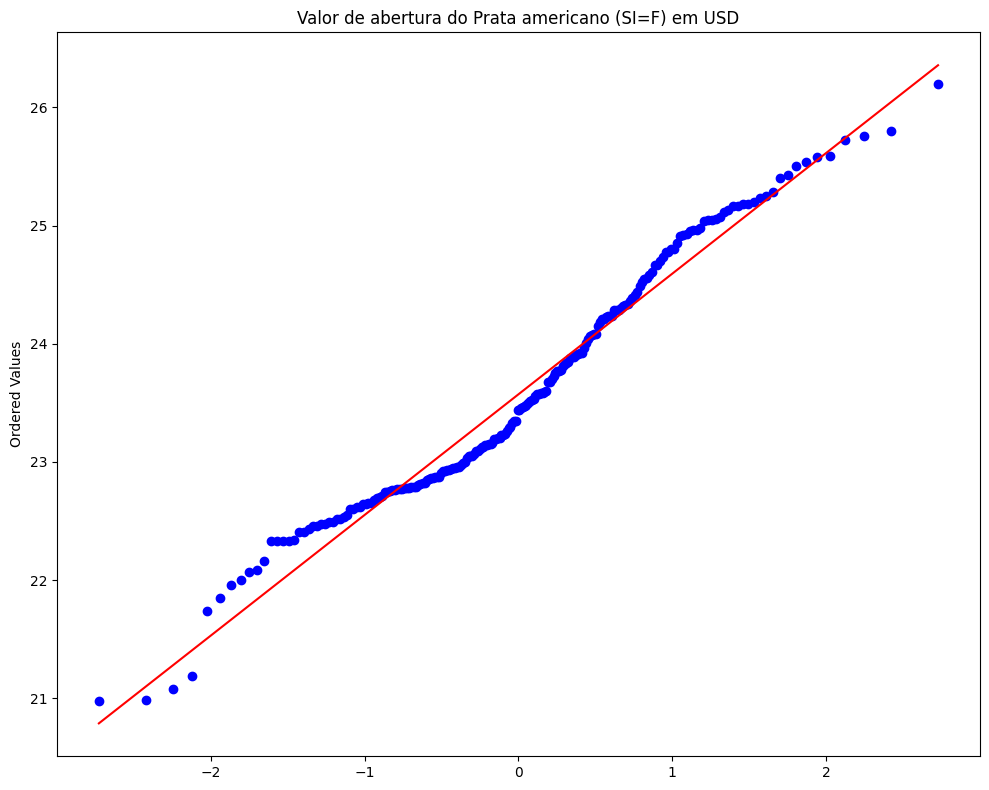

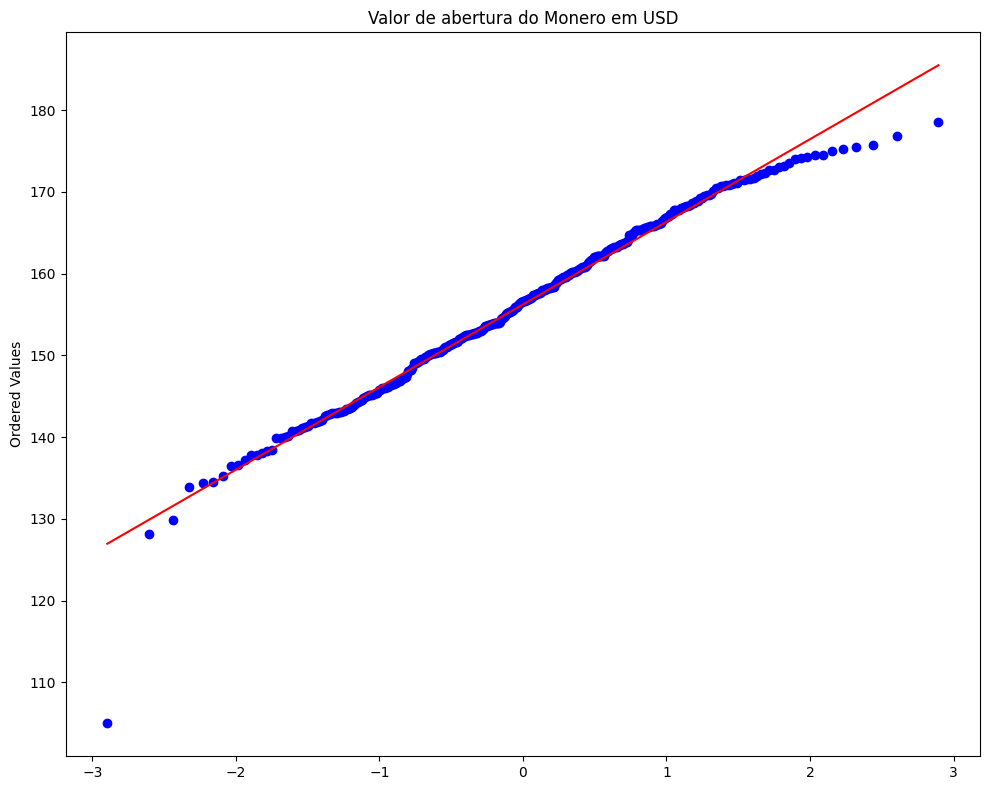

In [ ]:
# Plotagem linear para mostrar normalidade das séries temporais
def demoNorm(data, title):
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plotagem
    prob_before = stats.probplot(data["Open"], dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title(title)

    # Ajusta o layout
    plt.tight_layout()

    # Exibe o gráfico
    plt.show()

BABA = datababa()
AMD = dataamd()

COB = datacob()
PRA = datasil()


XMR = dataxmr()
LTC = dataltc()

demoNorm(BABA, title='Valor da abertura da ação da Alibaba em USD')
demoNorm(AMD, title='Valor da abertura da ação da AMD em USD')

demoNorm(COB, title='Valor de abertura do Cobre americano (HG=F) em USD')
demoNorm(PRA, title='Valor de abertura do Prata americano (SI=F) em USD')

demoNorm(XMR, title='Valor de abertura do Monero em USD')
demoNorm(LTC, title='Valor de abertura do Litecoin em USD')


## BoxPlot

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


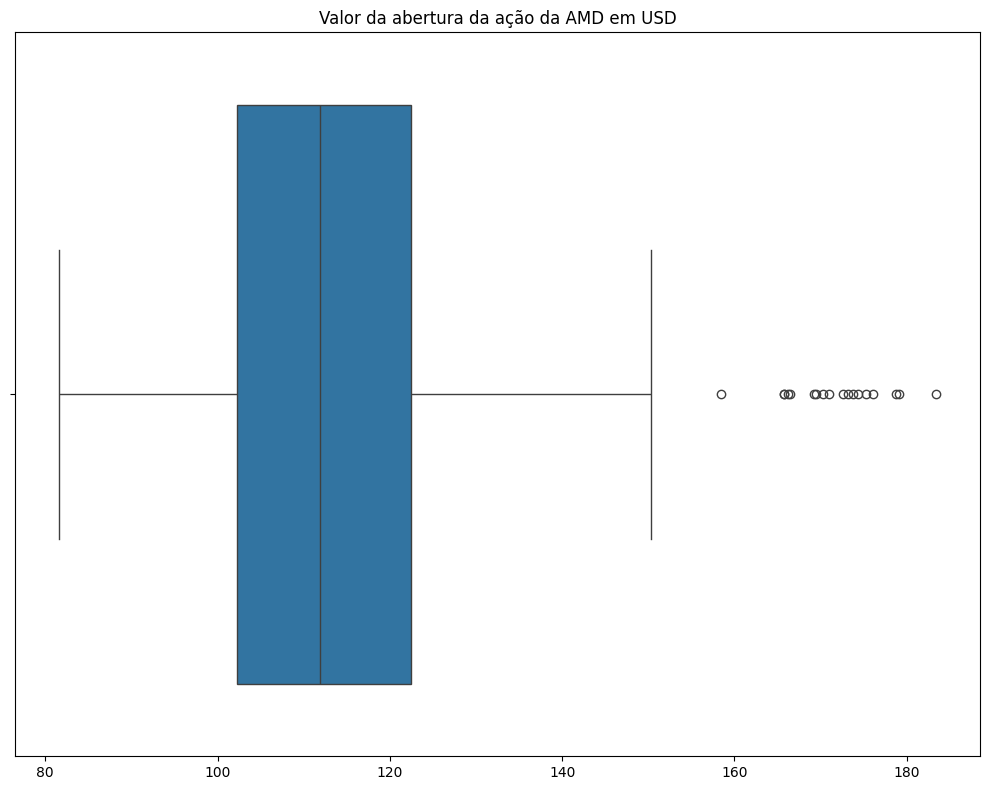

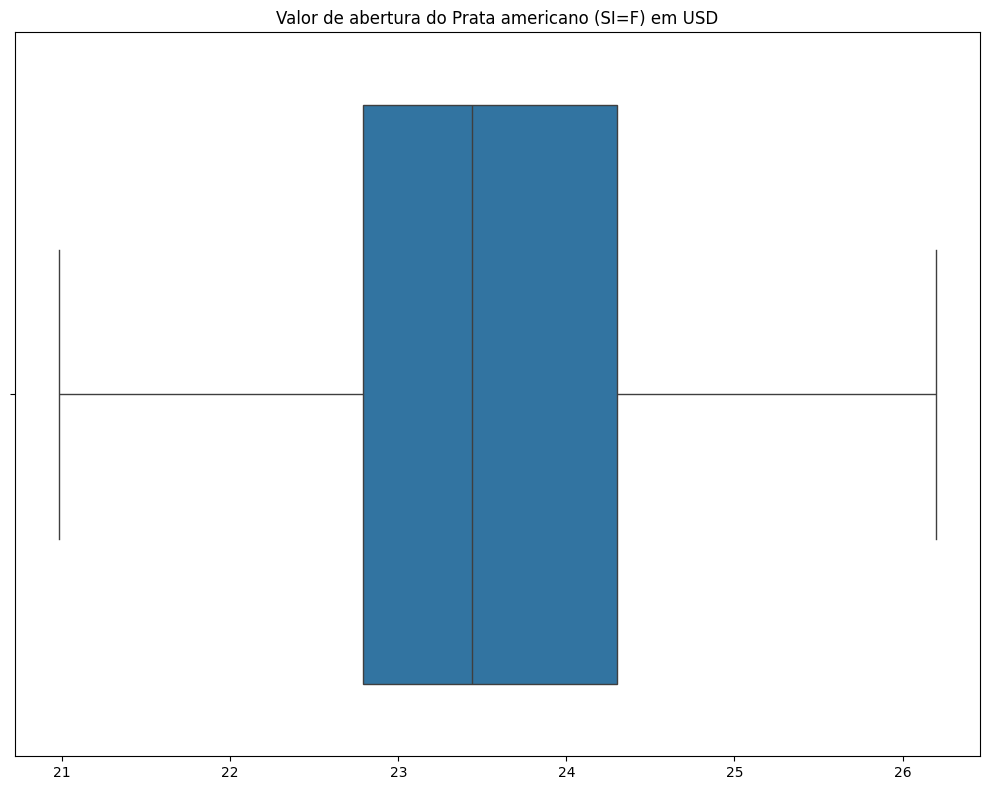

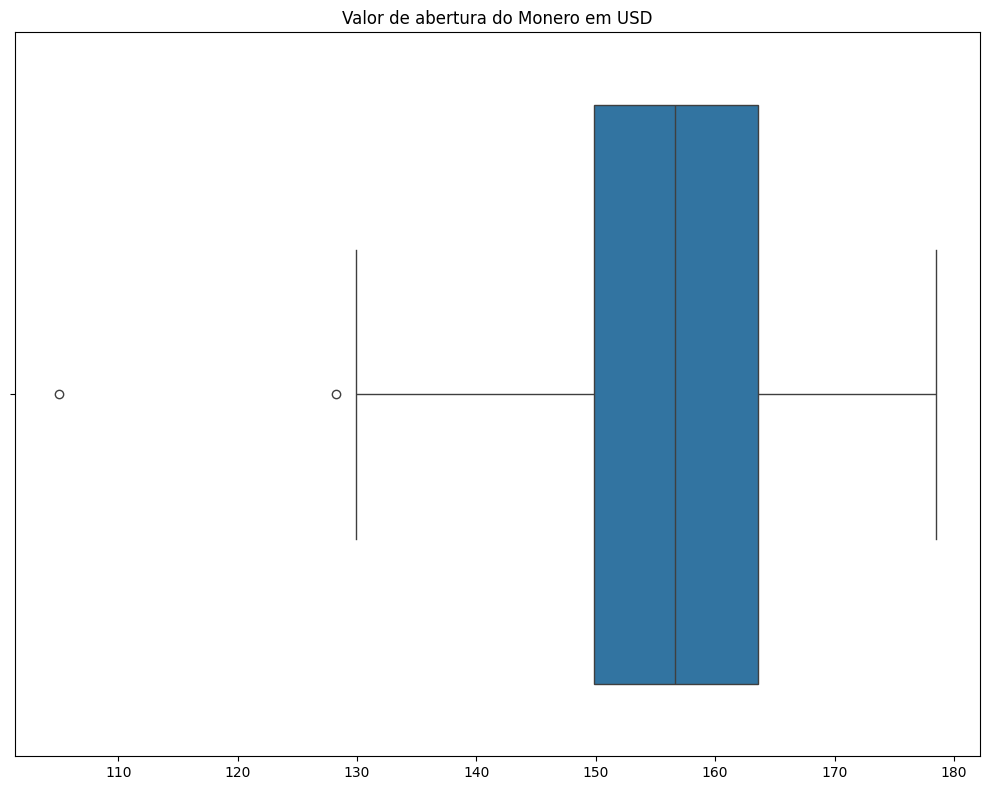

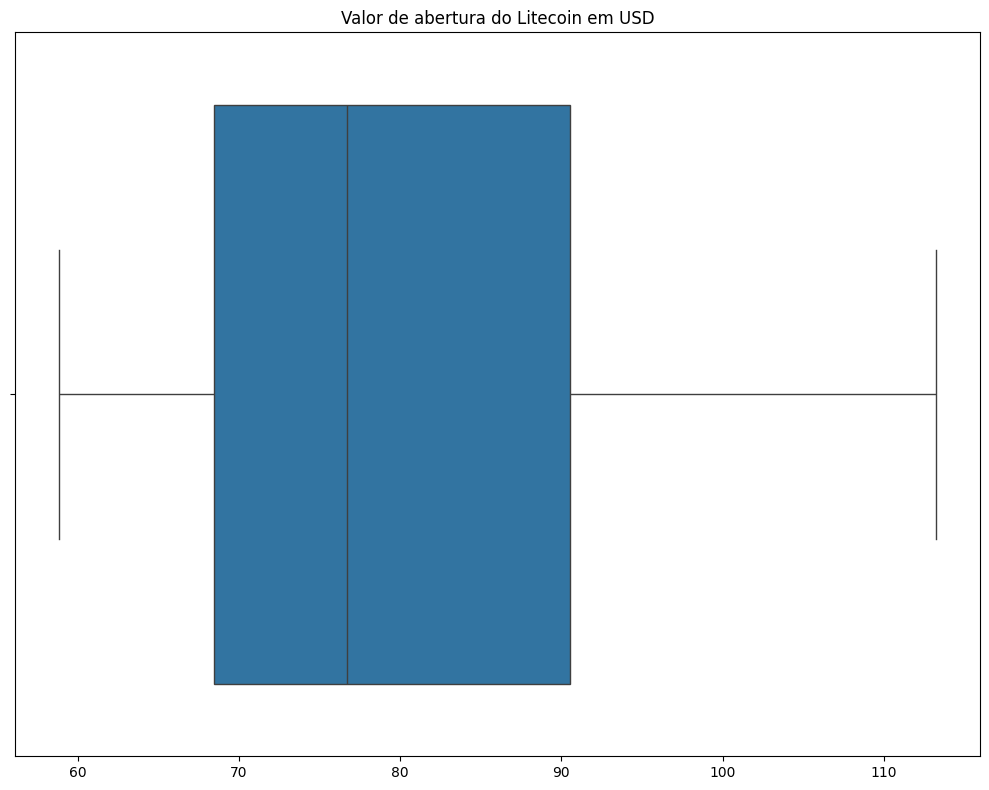

In [ ]:
def Boxplot(data, title):
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plotagem antes de BoxCox usando Seaborn
    sns.boxplot(x=data["Open"], ax=ax1)
    ax1.set_xlabel('')
    ax1.set_title(title)

    # Ajusta o layout
    plt.tight_layout()

    # Exibe o gráfico
    plt.show()


BABA = datababa()
AMD = dataamd()

COB = datacob()
PRA = datasil()


XMR = dataxmr()
LTC = dataltc()


Boxplot(BABA, title='Valor da abertura da ação da Alibaba em USD')
Boxplot(AMD, title='Valor da abertura da ação da AMD em USD')

Boxplot(COB, title='Valor de abertura do Cobre americano (HG=F) em USD')
Boxplot(PRA, title='Valor de abertura do Prata americano (SI=F) em USD')

Boxplot(XMR, title='Valor de abertura do Monero em USD')
Boxplot(LTC, title='Valor de abertura do Litecoin em USD')


## Plot Line Chart


In [ ]:
# Função para criar gráfico de linha usando plotly.express
def plot_line_chart(data, title):
    fig = px.line(data, x='Date', y='Open', title=title, markers=True)
    fig.update_xaxes(title_text='Data')
    fig.update_yaxes(title_text='Abertura')
    fig.show()

BABA = datababa()
AMD = dataamd()

COB = datacob()
PRA = datasil()


XMR = dataxmr()
LTC = dataltc()

# Plotando gráficos de linha para cada ativo
plot_line_chart(BABA, 'Valor da abertura da ação da Alibaba em USD')
plot_line_chart(AMD, 'Valor da abertura da ação da AMD em USD')

plot_line_chart(COB, 'Valor de abertura do Cobre americano (HG=F) em USD')
plot_line_chart(PRA, 'Valor de abertura do Prata americano (SI=F) em USD')

plot_line_chart(XMR, 'Valor de abertura do Monero em USD')
plot_line_chart(LTC, 'Valor de abertura do Litecoin em USD')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Gráfico Candlestick

In [ ]:
# Função para criar gráfico de candlestick
def plot_candlestick(data, title):
    fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                                         open=data['Open'],
                                         high=data['High'],
                                         low=data['Low'],
                                         close=data['Close'])])

    fig.update_layout(title=title,
                      xaxis_title='Data',
                      yaxis_title='Preço',
                      xaxis_rangeslider_visible=False)

    fig.show()

candlestick_baba= yf.download("BABA", start=data_inicio_baba, end=data_fim_baba).reset_index()
candlestick_amd= yf.download("AMD", start=data_inicio_amd, end=data_fim_amd).reset_index()

candlestick_cob = yf.download("HG=F", start=data_inicio_cobre, end=data_fim_cobre).reset_index()
candlestick_pra = yf.download("SI=F", start=data_inicio_prata, end=data_fim_prata).reset_index()

candlestick_xmr = yf.download("XMR-USD", start=data_inicio_xmr, end=data_fim_xmr).reset_index()
candlestick_ltc = yf.download("LTC-USD", start=data_inicio_ltc, end=data_fim_ltc).reset_index()


# Plotando gráfico de candlestick para os dados históricos
plot_candlestick(candlestick_baba, 'Candlestick Chart - Alibaba em USD (BABA)')
plot_candlestick(candlestick_amd, 'Candlestick Chart - Advance Micro Devices, INC em USD (AMD)')

plot_candlestick(candlestick_cob, 'Candlestick Chart - Cobre americano (HG=F)')
plot_candlestick(candlestick_pra, 'Candlestick Chart - Prata americano (SI=F)')

plot_candlestick(candlestick_xmr, 'Candlestick Chart - Monero em USD (XMR-USD)')
plot_candlestick(candlestick_ltc, 'Candlestick Chart - Litecoin em USD (LTC-USD)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Gráfico Empilhado

In [ ]:
def plot_stacked_bar(data1, data2, data3, data4, data5, data6, title):
    fig = go.Figure(data=[
        go.Bar(name='Alibaba em USD', x=data1['Date'], y=data1['Open']),
        go.Bar(name='Advance Micro Devices, INC. (AMD) em USD', x=data2['Date'], y=data2['Open']),
        go.Bar(name='Cobre americano (HG=F)', x=data3['Date'], y=data3['Open']),
        go.Bar(name='Prata americano (SI=H)', x=data4['Date'], y=data4['Open']),
        go.Bar(name='Monero', x=data5['Date'], y=data5['Open']),
        go.Bar(name='Litecoin', x=data6['Date'], y=data6['Open'])
    ])
    fig.update_layout(barmode='stack', title=title)
    fig.show()

# Plotando gráfico de barras empilhadas
plot_stacked_bar(datababa(), dataamd(), datacob(),
                 datasil(), dataxmr(), dataltc(), 'Gráfico de barras empilhadas para os ativos')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Modelos Previsão

## Random Forest Classifier (Classificador da floresta aleatória)

### Alibaba (BABA)

####Normal (Sem indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.5076923076923077
Confusion Matrix:
 [[ 4 32]
 [ 0 29]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20        36
           1       0.48      1.00      0.64        29

    accuracy                           0.51        65
   macro avg       0.74      0.56      0.42        65
weighted avg       0.77      0.51      0.40        65

Mean Squared Error (MSE): 3.6392783402534405
R-squared (R2): 0.7975534954552567
Root Mean Squared Error (RMSE): 1.9076892672166084
Mean Absolute Error (MAE): 1.3123431205749512
Mean Absolute Percentage Error (MAPE): 1.748228037291722


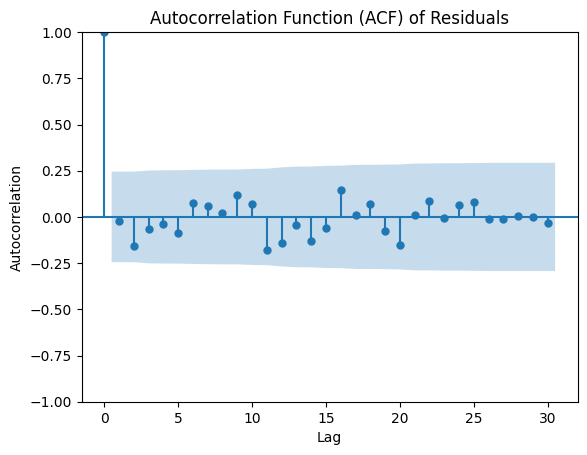

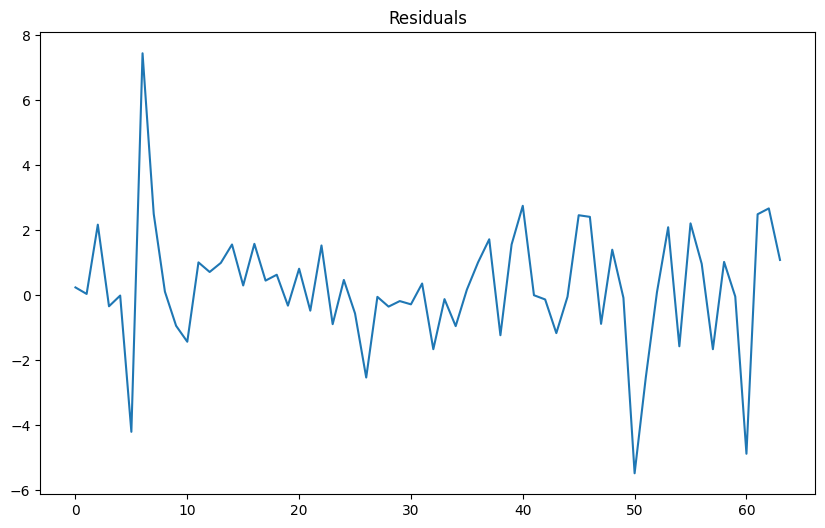


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 84.62, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 84.58, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 82.41, Preço real = 84.58, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-10 00:00:00, Preço previsto = 82.75, Preço real = 82.41, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 82.76, Preço real = 82.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 86.96, Preço real = 82.76, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 79.52, Preço real = 86.96, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 77.02, Preço real = 7

In [ ]:
BABA_normal = datababa()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_normal['Target'] = (BABA_normal['Open'].shift(-1) > BABA_normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
BABA_normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_normal[['Date', 'Open']].values
y = BABA_normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.75
Confusion Matrix:
 [[42  0]
 [14  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        42
           1       0.00      0.00      0.00        14

    accuracy                           0.75        56
   macro avg       0.38      0.50      0.43        56
weighted avg       0.56      0.75      0.64        56

Mean Squared Error (MSE): 0.25
R-squared (R2): -0.33333333333333326
Root Mean Squared Error (RMSE): 0.5
Mean Absolute Error (MAE): 0.25
Mean Absolute Percentage Error (MAPE): nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-16-d4c977cff7d0>:57: RuntimeWarning:

invalid value encountered in divide



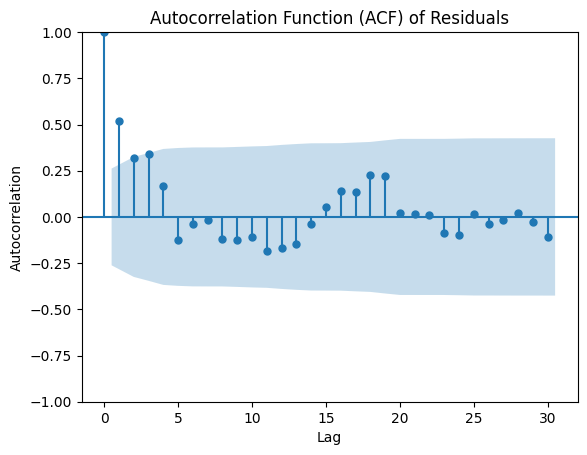


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 83.15, Preço real = 76.91, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 82.92, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-22 00:00:00, Preço previsto = 82.66, Preço real = 79.28, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 82.37, Preço real = 78.27, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-27 00:00:00, Preço previsto = 82.06, Preço real = 77.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-28 00:00:00, Preço previsto = 81.84, Preço real = 76.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-29 00:00:00, Preço previsto = 81.60, Preço real = 75.00, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-30 00:00:00, Preço previsto = 81.34, Preço re

In [ ]:
BABA_linear = datababa()

# Calcula as médias móveis
BABA_linear['MA_30'] = BABA_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
BABA_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
BABA_linear['Category'] = (BABA_linear['Open'] > BABA_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_linear[['Date', 'MA_30']].values
y = BABA_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = BABA_linear.iloc[train_size + i]['MA_30']
    actual_price = BABA_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.5245901639344263
Confusion Matrix:
 [[19 13]
 [16 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.59      0.57        32
           1       0.50      0.45      0.47        29

    accuracy                           0.52        61
   macro avg       0.52      0.52      0.52        61
weighted avg       0.52      0.52      0.52        61

Mean Squared Error (MSE): 0.47540983606557374
R-squared (R2): -0.90625
Root Mean Squared Error (RMSE): 0.6894996998299374
Mean Absolute Error (MAE): 0.47540983606557374
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-17-085105e597b6>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-17-085105e597b6>:57: RuntimeWarning:

invalid value encountered in divide



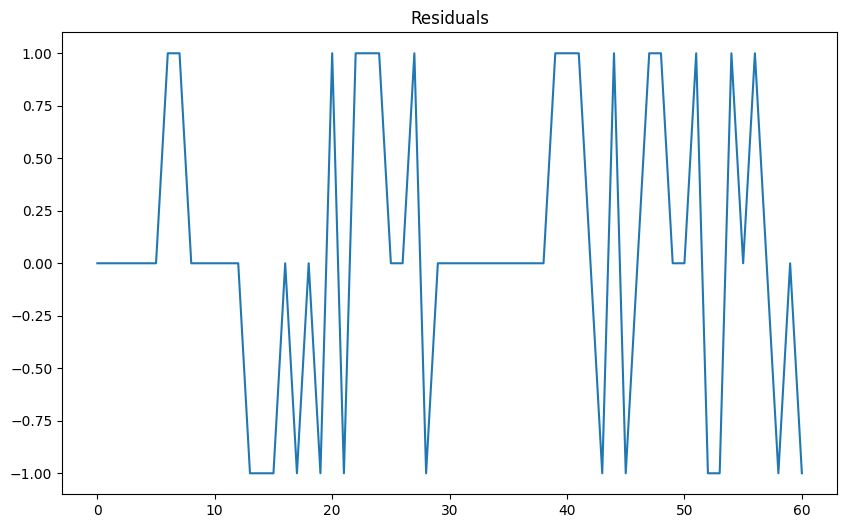


Resultados Previstos:
Data = 2023-11-13 00:00:00, Preço previsto = 45.78, Preço real = 82.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 45.81, Preço real = 82.76, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 58.76, Preço real = 86.96, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 40.36, Preço real = 79.52, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 36.26, Preço real = 77.02, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-20 00:00:00, Preço previsto = 36.08, Preço real = 76.91, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 38.79, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 42.75, Preço real = 79

In [ ]:
BABA_RSI14 = datababa()

# Calcula o RSI14
BABA_RSI14['RSI14'] = ta.momentum.rsi(BABA_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
BABA_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
BABA_RSI14['Category'] = (BABA_RSI14['Open'] > BABA_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_RSI14[['Date', 'RSI14']].values
y = BABA_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = BABA_RSI14.iloc[train_size + i]['RSI14']
    actual_price = BABA_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
Acurácia: 0.5230769230769231
F1 Score: 0.6265060240963856
Recall: 0.896551724137931
Precisão: 0.48148148148148145
Matriz de Confusão:
[[ 8 28]
 [ 3 26]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.22      0.34        36
           1       0.48      0.90      0.63        29

    accuracy                           0.52        65
   macro avg       0.60      0.56      0.48        65
weighted avg       0.62      0.52      0.47        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 84.86, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 84.62, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 84.58, Preço real = 84.58, Comportamento previsto = Des

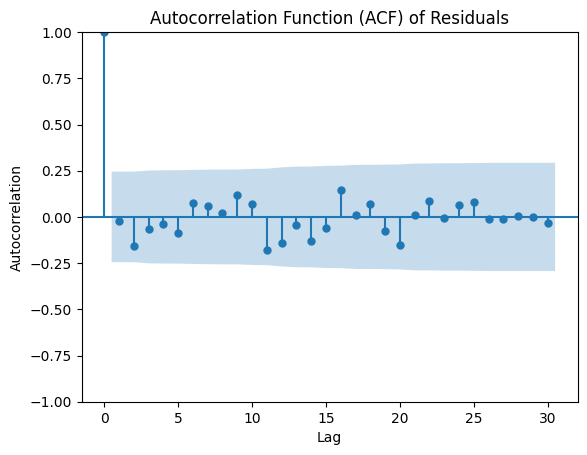

In [ ]:
BABA_obv = datababa()

# Cálculo do indicador OBV
BABA_obv['OBV'] = (np.sign(BABA_obv['Close'].diff()) * BABA_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
BABA_obv['Target'] = np.where(BABA_obv['Open'].shift(-1) > BABA_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
BABA_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = BABA_obv[['Open', 'OBV']]
y = BABA_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = BABA_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = BABA_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Advanced Micro Devices, INC. (AMD)

####Normal (Sem indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.46153846153846156
Confusion Matrix:
 [[24  1]
 [34  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.96      0.58        25
           1       0.86      0.15      0.26        40

    accuracy                           0.46        65
   macro avg       0.64      0.55      0.42        65
weighted avg       0.69      0.46      0.38        65

Mean Squared Error (MSE): 17.676029273059612
R-squared (R2): 0.959757525636354
Root Mean Squared Error (RMSE): 4.204287011261197
Mean Absolute Error (MAE): 3.086249828338623
Mean Absolute Percentage Error (MAPE): 2.082593246873206


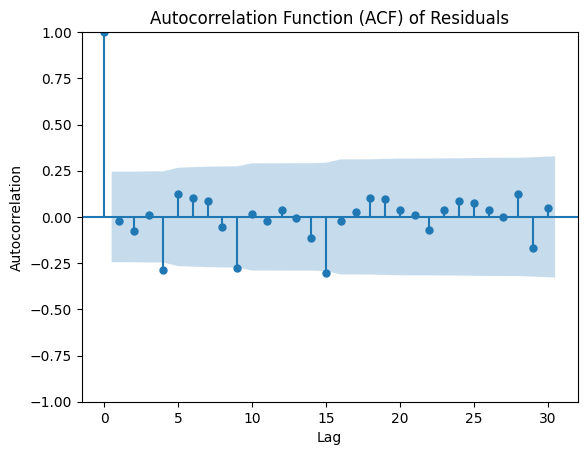

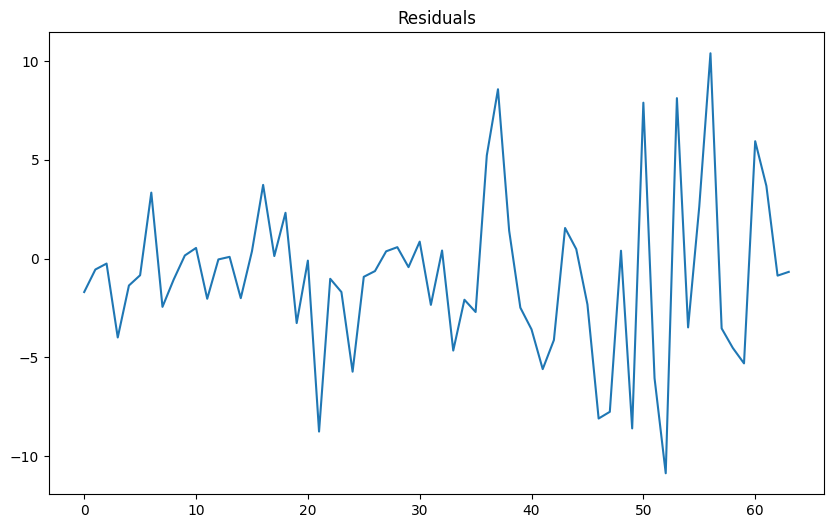


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 113.55, Preço real = 111.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 114.10, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.35, Preço real = 114.10, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 118.34, Preço real = 114.35, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 119.70, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 120.54, Preço real = 119.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 117.20, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 119.64, Pre

In [ ]:
AMD_Normal = dataamd()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_Normal['Target'] = (AMD_Normal['Open'].shift(-1) > AMD_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
AMD_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_Normal[['Date', 'Open']].values
y = AMD_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.0
Confusion Matrix:
 [[ 0  0]
 [56  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      56.0

    accuracy                           0.00      56.0
   macro avg       0.00      0.00      0.00      56.0
weighted avg       0.00      0.00      0.00      56.0

Mean Squared Error (MSE): 1.0
R-squared (R2): 0.0
Root Mean Squared Error (RMSE): 1.0
Mean Absolute Error (MAE): 1.0
Mean Absolute Percentage Error (MAPE): 100.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

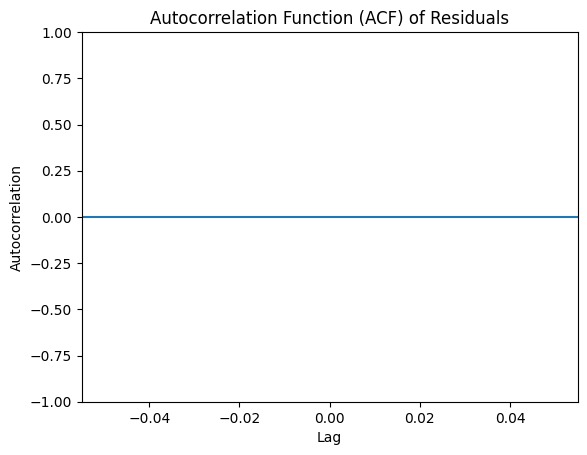

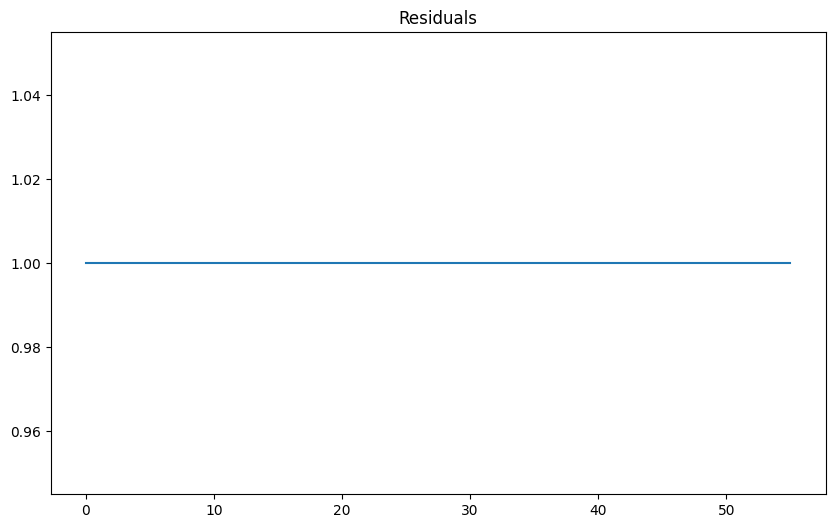


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 107.40, Preço real = 120.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 107.89, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 108.32, Preço real = 120.00, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 108.69, Preço real = 122.03, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 109.14, Preço real = 122.07, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 109.59, Preço real = 121.98, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 110.14, Preço real = 123.98, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 110.82, 

In [ ]:
AMD_linear = dataamd()

# Calcula as médias móveis
AMD_linear['MA_30'] = AMD_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
AMD_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
AMD_linear['Category'] = (AMD_linear['Open'] > AMD_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_linear[['Date', 'MA_30']].values
y = AMD_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = AMD_linear.iloc[train_size + i]['MA_30']
    actual_price = AMD_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.6065573770491803
Confusion Matrix:
 [[ 1 23]
 [ 1 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.08        24
           1       0.61      0.97      0.75        37

    accuracy                           0.61        61
   macro avg       0.56      0.51      0.41        61
weighted avg       0.57      0.61      0.49        61

Mean Squared Error (MSE): 0.39344262295081966
R-squared (R2): -0.6486486486486487
Root Mean Squared Error (RMSE): 0.62725004818718
Mean Absolute Error (MAE): 0.39344262295081966
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-21-aaa4d51af4fd>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-21-aaa4d51af4fd>:57: RuntimeWarning:

invalid value encountered in divide



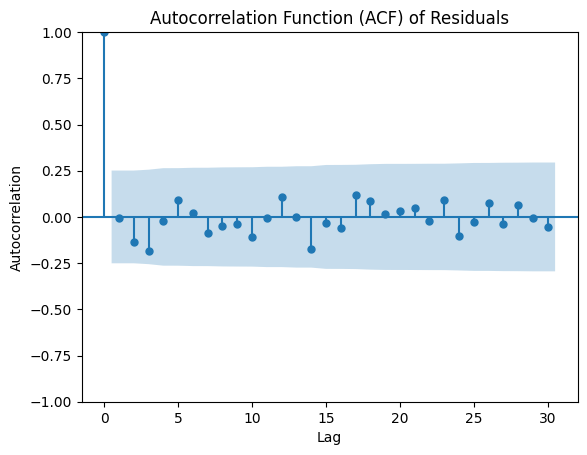

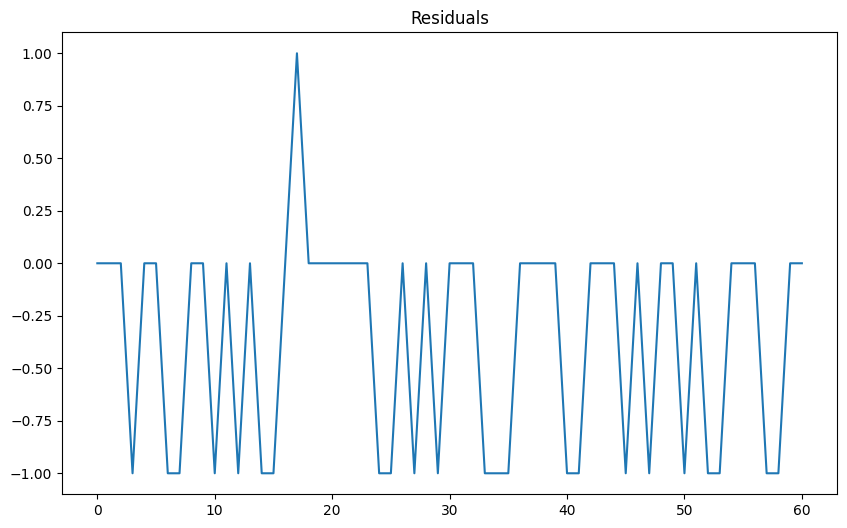


Resultados Previstos:
Data = 2023-11-13 00:00:00, Preço previsto = 73.21, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 74.58, Preço real = 119.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 75.42, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 66.08, Preço real = 117.20, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 69.09, Preço real = 119.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, Preço previsto = 70.32, Preço real = 120.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 69.87, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-22 00:00:00, Preço previsto = 68.27, Preço real = 

In [ ]:
AMD_RSI14 = dataamd()

# Calcula o RSI14
AMD_RSI14['RSI14'] = ta.momentum.rsi(AMD_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
AMD_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
AMD_RSI14['Category'] = (AMD_RSI14['Open'] > AMD_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_RSI14[['Date', 'RSI14']].values
y = AMD_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = AMD_RSI14.iloc[train_size + i]['RSI14']
    actual_price = AMD_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 300}
Acurácia: 0.5692307692307692
F1 Score: 0.7083333333333333
Recall: 0.85
Precisão: 0.6071428571428571
Matriz de Confusão:
[[ 3 22]
 [ 6 34]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18        25
           1       0.61      0.85      0.71        40

    accuracy                           0.57        65
   macro avg       0.47      0.48      0.44        65
weighted avg       0.50      0.57      0.50        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 111.86, Preço real = 111.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 113.55, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.10, Preço real = 114.10, Comportamento previsto = Sobe, Comport

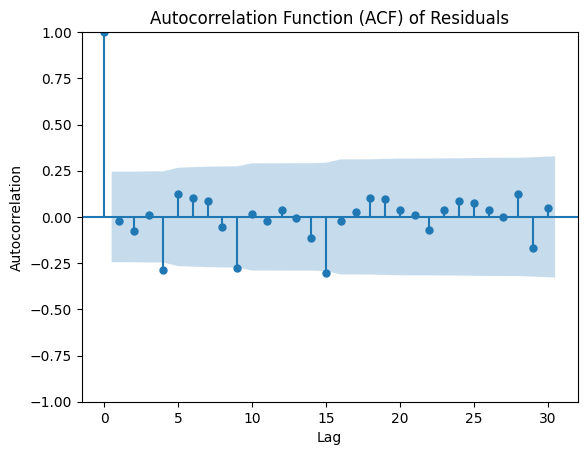

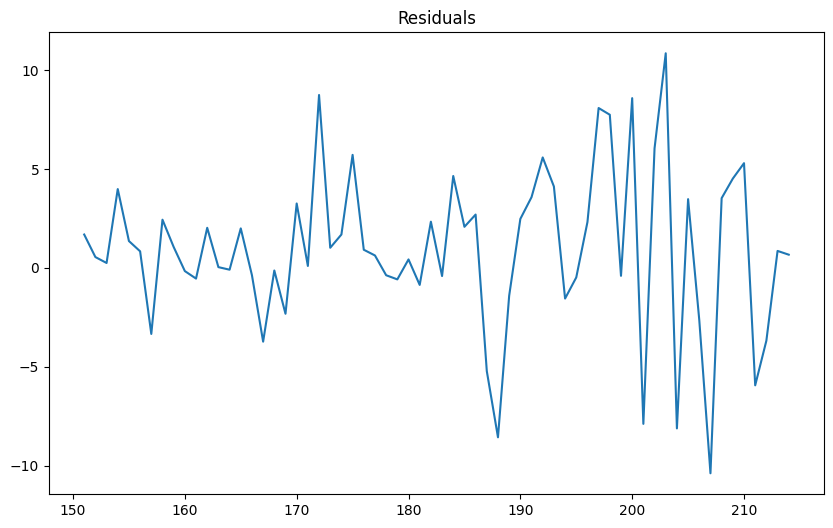

In [ ]:
AMD_obv = dataamd()

# Cálculo do indicador OBV
AMD_obv['OBV'] = (np.sign(AMD_obv['Close'].diff()) * AMD_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
AMD_obv['Target'] = np.where(AMD_obv['Open'].shift(-1) > AMD_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
AMD_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = AMD_obv[['Open', 'OBV']]
y = AMD_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = AMD_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = AMD_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Monero em Dolar (XMR-USD)

####Normal (Sem indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.509090909090909
Confusion Matrix:
 [[43 10]
 [44 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.81      0.61        53
           1       0.57      0.23      0.32        57

    accuracy                           0.51       110
   macro avg       0.53      0.52      0.47       110
weighted avg       0.53      0.51      0.46       110

Mean Squared Error (MSE): 52.48280260750998
R-squared (R2): 0.4745770636338078
Root Mean Squared Error (RMSE): 7.244501543067679
Mean Absolute Error (MAE): 3.4309758177591028
Mean Absolute Percentage Error (MAPE): 2.174353650566502


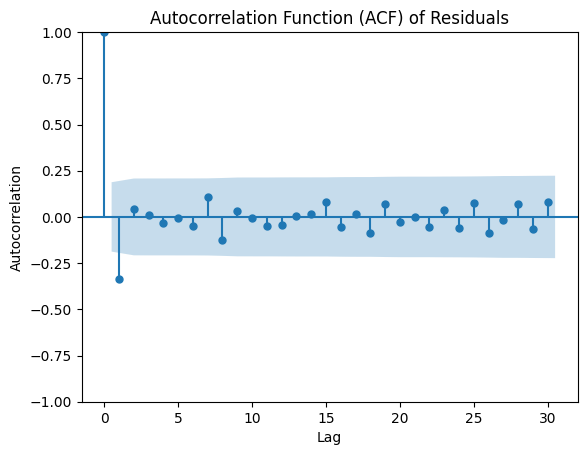


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 160.88, Preço real = 158.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 158.05, Preço real = 160.88, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-25 00:00:00, Preço previsto = 160.05, Preço real = 158.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-26 00:00:00, Preço previsto = 159.65, Preço real = 160.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-27 00:00:00, Preço previsto = 160.90, Preço real = 159.65, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, Preço previsto = 162.19, Preço real = 160.90, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 174.32, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 172.65, Pr

In [ ]:
XMR_Normal = dataxmr()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_Normal['Target'] = (XMR_Normal['Open'].shift(-1) > XMR_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
XMR_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_Normal[['Date', 'Open']].values
y = XMR_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.504950495049505
Confusion Matrix:
 [[42  4]
 [46  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.91      0.63        46
           1       0.69      0.16      0.26        55

    accuracy                           0.50       101
   macro avg       0.58      0.54      0.45       101
weighted avg       0.59      0.50      0.43       101

Mean Squared Error (MSE): 0.49504950495049505
R-squared (R2): -0.9960474308300398
Root Mean Squared Error (RMSE): 0.7035975447302919
Mean Absolute Error (MAE): 0.49504950495049505
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-24-76b1840fdabf>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-24-76b1840fdabf>:57: RuntimeWarning:

invalid value encountered in divide



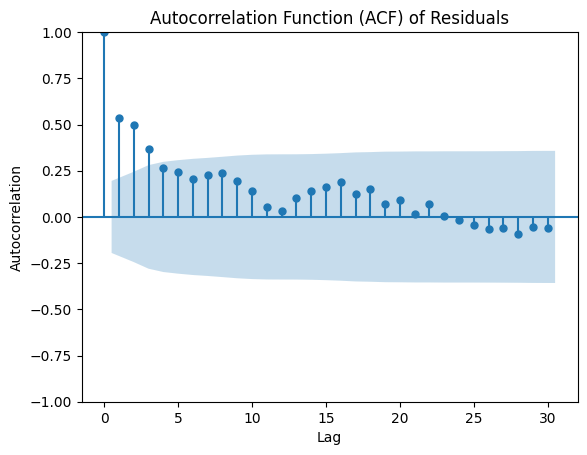

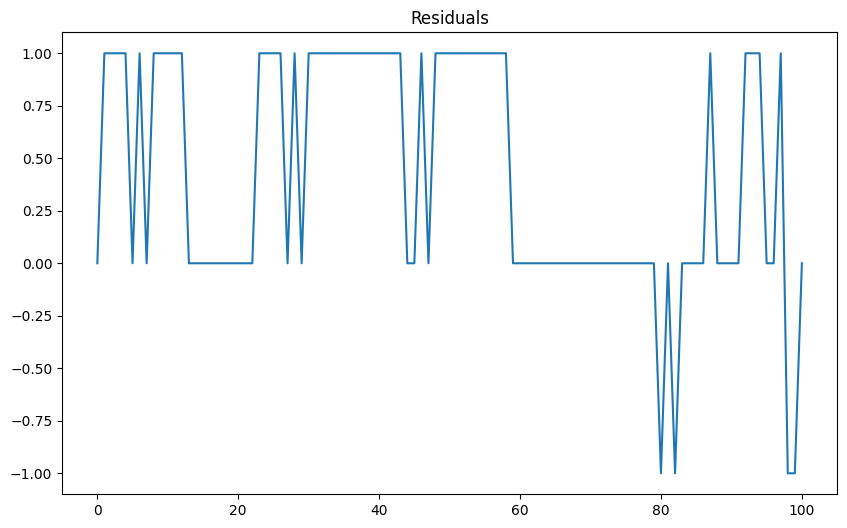


Resultados Previstos:
Data = 2023-11-01 00:00:00, Preço previsto = 155.41, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-02 00:00:00, Preço previsto = 156.18, Preço real = 171.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 157.03, Preço real = 171.01, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-04 00:00:00, Preço previsto = 157.82, Preço real = 170.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-05 00:00:00, Preço previsto = 158.50, Preço real = 168.39, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-06 00:00:00, Preço previsto = 159.13, Preço real = 169.69, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 159.72, Preço real = 165.35, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 160.05, Pr

In [ ]:
XMR_linear = dataxmr()

# Calcula as médias móveis
XMR_linear['MA_30'] = XMR_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
XMR_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
XMR_linear['Category'] = (XMR_linear['Open'] > XMR_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_linear[['Date', 'MA_30']].values
y = XMR_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = XMR_linear.iloc[train_size + i]['MA_30']
    actual_price = XMR_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.5566037735849056
Confusion Matrix:
 [[23 28]
 [19 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.49        51
           1       0.56      0.65      0.61        55

    accuracy                           0.56       106
   macro avg       0.56      0.55      0.55       106
weighted avg       0.56      0.56      0.55       106

Mean Squared Error (MSE): 0.44339622641509435
R-squared (R2): -0.7761140819964354
Root Mean Squared Error (RMSE): 0.6658800390574073
Mean Absolute Error (MAE): 0.44339622641509435
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-25-108ffe170ccd>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-25-108ffe170ccd>:57: RuntimeWarning:

invalid value encountered in divide



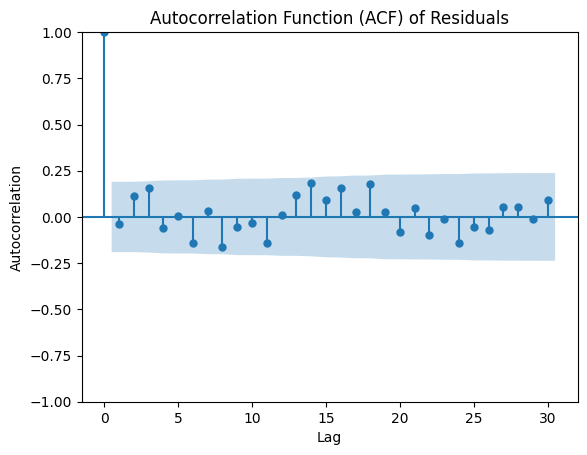


Resultados Previstos:
Data = 2023-10-27 00:00:00, Preço previsto = 63.69, Preço real = 159.65, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-28 00:00:00, Preço previsto = 65.68, Preço real = 160.90, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 67.65, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 79.53, Preço real = 174.32, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 75.42, Preço real = 172.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-01 00:00:00, Preço previsto = 74.64, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-02 00:00:00, Preço previsto = 72.84, Preço real = 171.64, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-03 00:00:00, Preço previsto = 71.17, Preço real

In [ ]:
XMR_RSI14 = dataxmr()

# Calcula o RSI14
XMR_RSI14['RSI14'] = ta.momentum.rsi(XMR_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
XMR_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
XMR_RSI14['Category'] = (XMR_RSI14['Open'] > XMR_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_RSI14[['Date', 'RSI14']].values
y = XMR_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = XMR_RSI14.iloc[train_size + i]['RSI14']
    actual_price = XMR_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100}
Acurácia: 0.5545454545454546
F1 Score: 0.6838709677419356
Recall: 0.9298245614035088
Precisão: 0.5408163265306123
Matriz de Confusão:
[[ 8 45]
 [ 4 53]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.15      0.25        53
           1       0.54      0.93      0.68        57

    accuracy                           0.55       110
   macro avg       0.60      0.54      0.47       110
weighted avg       0.60      0.55      0.47       110


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 158.34, Preço real = 158.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 160.88, Preço real = 160.88, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-25 00:00:00, Preço previsto = 158.05, Preço real = 158.05, Comportamento previsto =

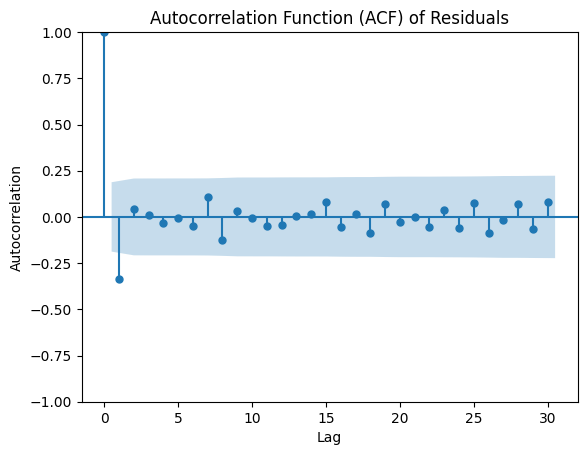

In [ ]:
XMR_obv = dataxmr()

# Cálculo do indicador OBV
XMR_obv['OBV'] = (np.sign(XMR_obv['Close'].diff()) * XMR_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
XMR_obv['Target'] = np.where(XMR_obv['Open'].shift(-1) > XMR_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
XMR_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = XMR_obv[['Open', 'OBV']]
y = XMR_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = XMR_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = XMR_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Litecoin em Dolar (LTC-USD)

####Normal (Sem indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.37272727272727274
Confusion Matrix:
 [[32 20]
 [49  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.62      0.48        52
           1       0.31      0.16      0.21        58

    accuracy                           0.37       110
   macro avg       0.35      0.39      0.34       110
weighted avg       0.35      0.37      0.34       110

Mean Squared Error (MSE): 3.1684809369035065
R-squared (R2): 0.6138320155174288
Root Mean Squared Error (RMSE): 1.7800227349400644
Mean Absolute Error (MAE): 1.304996455481293
Mean Absolute Percentage Error (MAPE): 1.8429847761583735


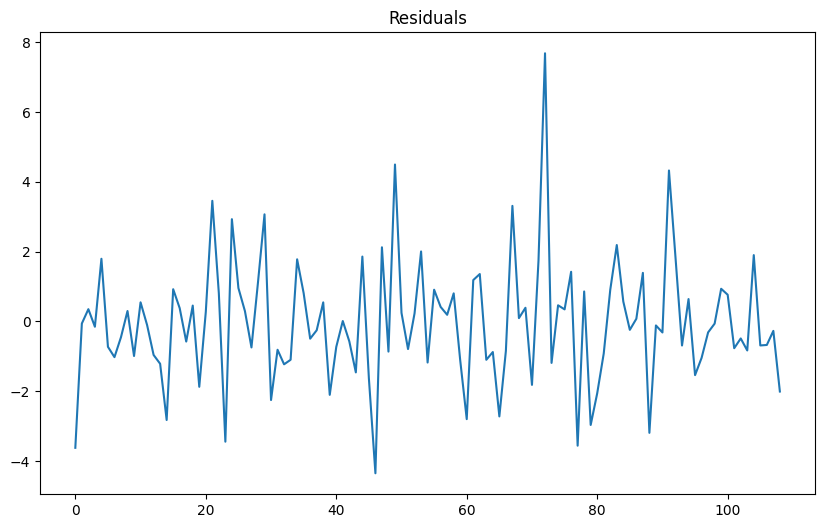


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 68.99, Preço real = 65.37, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 69.05, Preço real = 68.99, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 68.70, Preço real = 69.05, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-26 00:00:00, Preço previsto = 68.85, Preço real = 68.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-27 00:00:00, Preço previsto = 67.05, Preço real = 68.85, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-28 00:00:00, Preço previsto = 67.78, Preço real = 67.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 68.80, Preço real = 67.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 69.25, Preço real = 

In [ ]:
LTC_Normal = dataltc()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_Normal['Target'] = (LTC_Normal['Open'].shift(-1) > LTC_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
LTC_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_Normal[['Date', 'Open']].values
y = LTC_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.4752475247524752
Confusion Matrix:
 [[48  0]
 [53  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      1.00      0.64        48
           1       0.00      0.00      0.00        53

    accuracy                           0.48       101
   macro avg       0.24      0.50      0.32       101
weighted avg       0.23      0.48      0.31       101

Mean Squared Error (MSE): 0.5247524752475248
R-squared (R2): -1.104166666666666
Root Mean Squared Error (RMSE): 0.7243980088649642
Mean Absolute Error (MAE): 0.5247524752475248
Mean Absolute Percentage Error (MAPE): nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-28-52d9a7018b67>:57: RuntimeWarning:

invalid value encountered in divide



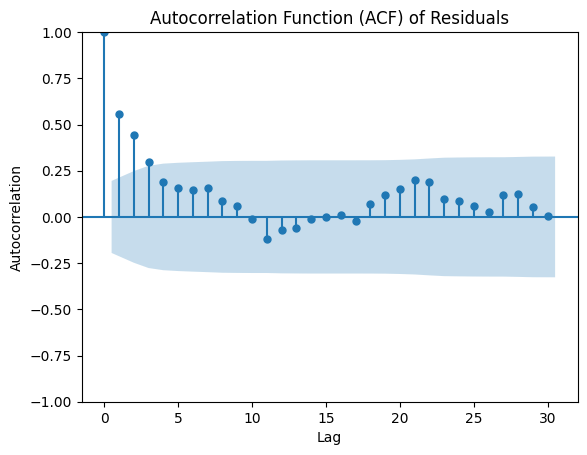

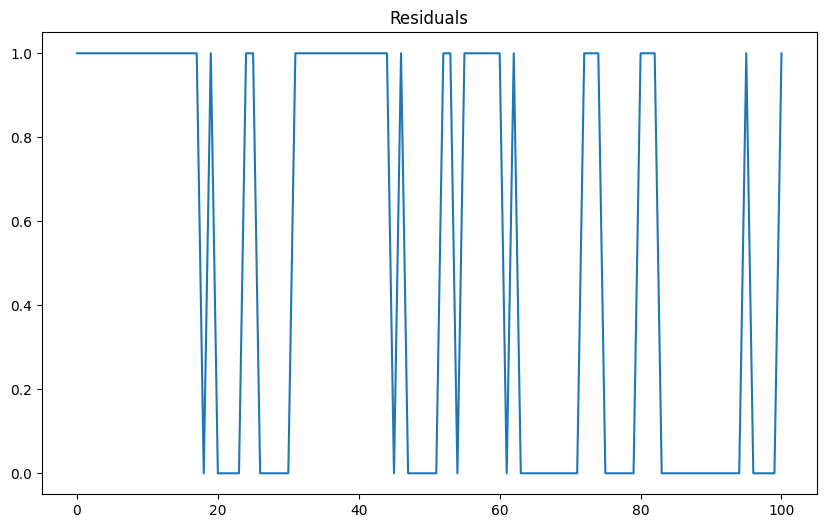


Resultados Previstos:
Data = 2023-11-01 00:00:00, Preço previsto = 64.97, Preço real = 68.95, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-02 00:00:00, Preço previsto = 65.00, Preço real = 69.94, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 65.13, Preço real = 69.39, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-04 00:00:00, Preço previsto = 65.26, Preço real = 69.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-05 00:00:00, Preço previsto = 65.43, Preço real = 70.45, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-06 00:00:00, Preço previsto = 65.61, Preço real = 71.66, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 65.82, Preço real = 74.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 66.12, Preço real = 73

In [ ]:
LTC_linear = dataltc()

# Calcula as médias móveis
LTC_linear['MA_30'] = LTC_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
LTC_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
LTC_linear['Category'] = (LTC_linear['Open'] > LTC_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_linear[['Date', 'MA_30']].values
y = LTC_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = LTC_linear.iloc[train_size + i]['MA_30']
    actual_price = LTC_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.6037735849056604
Confusion Matrix:
 [[20 30]
 [12 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.40      0.49        50
           1       0.59      0.79      0.68        56

    accuracy                           0.60       106
   macro avg       0.61      0.59      0.58       106
weighted avg       0.61      0.60      0.59       106

Mean Squared Error (MSE): 0.39622641509433965
R-squared (R2): -0.5900000000000001
Root Mean Squared Error (RMSE): 0.6294651817966898
Mean Absolute Error (MAE): 0.39622641509433965
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-29-1a68d2b5c7c0>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-29-1a68d2b5c7c0>:57: RuntimeWarning:

invalid value encountered in divide



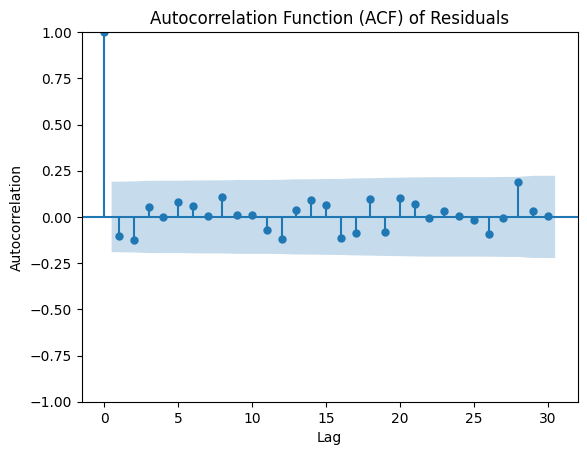

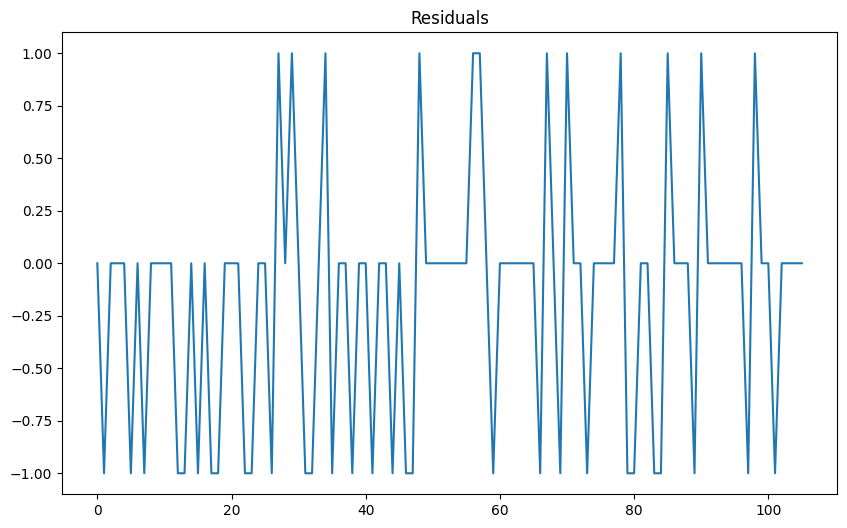


Resultados Previstos:
Data = 2023-10-27 00:00:00, Preço previsto = 64.21, Preço real = 68.85, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, Preço previsto = 56.70, Preço real = 67.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-29 00:00:00, Preço previsto = 58.79, Preço real = 67.78, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 61.61, Preço real = 68.80, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 62.82, Preço real = 69.25, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-01 00:00:00, Preço previsto = 61.43, Preço real = 68.95, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-02 00:00:00, Preço previsto = 64.23, Preço real = 69.94, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 61.56, Preço real = 69.39, 

In [ ]:
LTC_RSI14 = dataltc()

# Calcula o RSI14
LTC_RSI14['RSI14'] = ta.momentum.rsi(LTC_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
LTC_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
LTC_RSI14['Category'] = (LTC_RSI14['Open'] > LTC_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_RSI14[['Date', 'RSI14']].values
y = LTC_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = LTC_RSI14.iloc[train_size + i]['RSI14']
    actual_price = LTC_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Acurácia: 0.5636363636363636
F1 Score: 0.7037037037037037
Recall: 0.9827586206896551
Precisão: 0.5480769230769231
Matriz de Confusão:
[[ 5 47]
 [ 1 57]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.10      0.17        52
           1       0.55      0.98      0.70        58

    accuracy                           0.56       110
   macro avg       0.69      0.54      0.44       110
weighted avg       0.68      0.56      0.45       110


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 65.37, Preço real = 65.37, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 68.99, Preço real = 68.99, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 69.05, Preço real = 69.05, Comportamento previsto = Sobe, Com

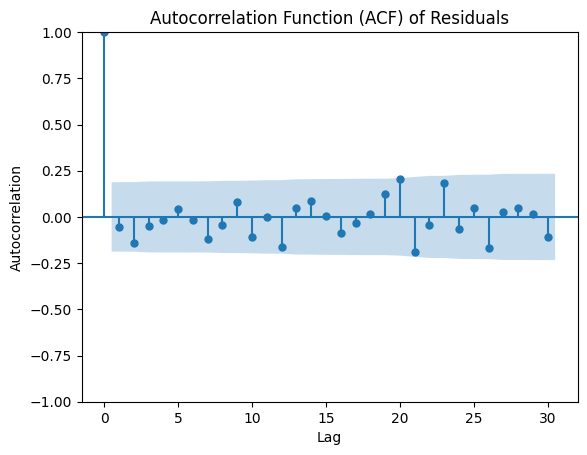

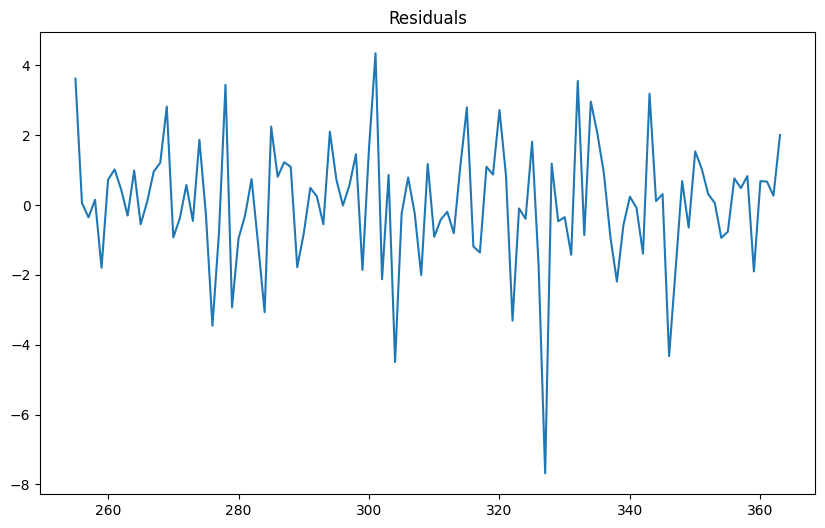

In [ ]:
LTC_obv = dataltc()

# Cálculo do indicador OBV
LTC_obv['OBV'] = (np.sign(LTC_obv['Close'].diff()) * LTC_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
LTC_obv['Target'] = np.where(LTC_obv['Open'].shift(-1) > LTC_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
LTC_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = LTC_obv[['Open', 'OBV']]
y = LTC_obv['Target']

#  Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = LTC_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = LTC_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Cobre americano em USD (HG=F)

####Normal (Sem Indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.42105263157894735
Confusion Matrix:
 [[18  1]
 [32  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.95      0.52        19
           1       0.86      0.16      0.27        38

    accuracy                           0.42        57
   macro avg       0.61      0.55      0.39        57
weighted avg       0.69      0.42      0.35        57

Mean Squared Error (MSE): 0.5789473684210527
R-squared (R2): -1.6052631578947367
Root Mean Squared Error (RMSE): 0.7608859102526822
Mean Absolute Error (MAE): 0.5789473684210527
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-31-e887c3efbd7c>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-31-e887c3efbd7c>:57: RuntimeWarning:

invalid value encountered in divide



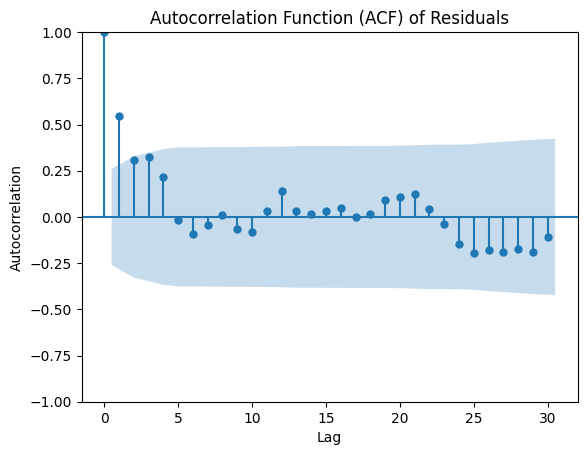

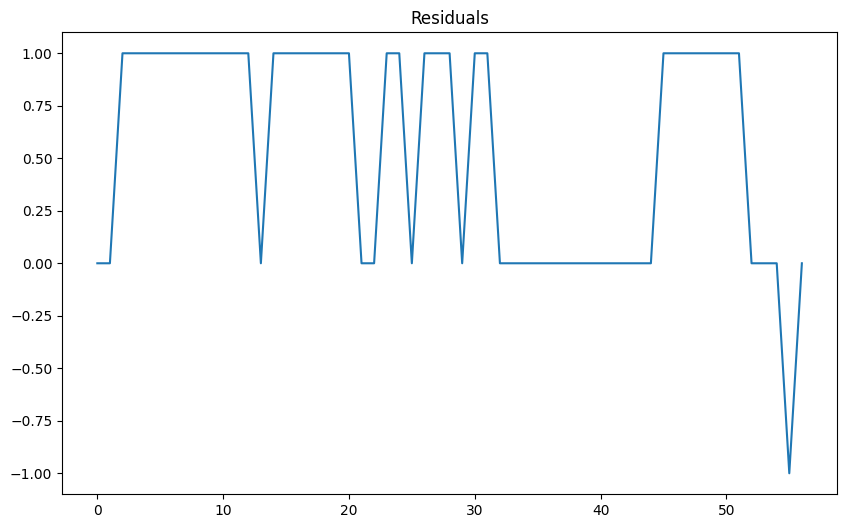


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 3.63, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 3.63, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 3.64, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-23 00:00:00, Preço previsto = 3.64, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 3.65, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 3.65, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 3.66, Preço real = 3.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 3.67, Preço real = 3.81, Comportamento

In [ ]:
COB_Normal = datacob()

# Calcula as médias móveis
COB_Normal['MA_30'] = COB_Normal['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
COB_Normal.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
COB_Normal['Category'] = (COB_Normal['Open'] > COB_Normal['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = COB_Normal[['Date', 'MA_30']].values
y = COB_Normal['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = COB_Normal.iloc[train_size + i]['MA_30']
    actual_price = COB_Normal.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.42105263157894735
Confusion Matrix:
 [[18  1]
 [32  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.95      0.52        19
           1       0.86      0.16      0.27        38

    accuracy                           0.42        57
   macro avg       0.61      0.55      0.39        57
weighted avg       0.69      0.42      0.35        57

Mean Squared Error (MSE): 0.5789473684210527
R-squared (R2): -1.6052631578947367
Root Mean Squared Error (RMSE): 0.7608859102526822
Mean Absolute Error (MAE): 0.5789473684210527
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-32-bdb9eb81a680>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-32-bdb9eb81a680>:57: RuntimeWarning:

invalid value encountered in divide



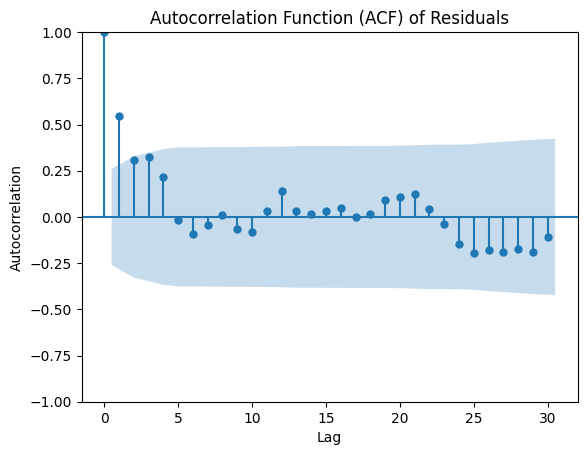

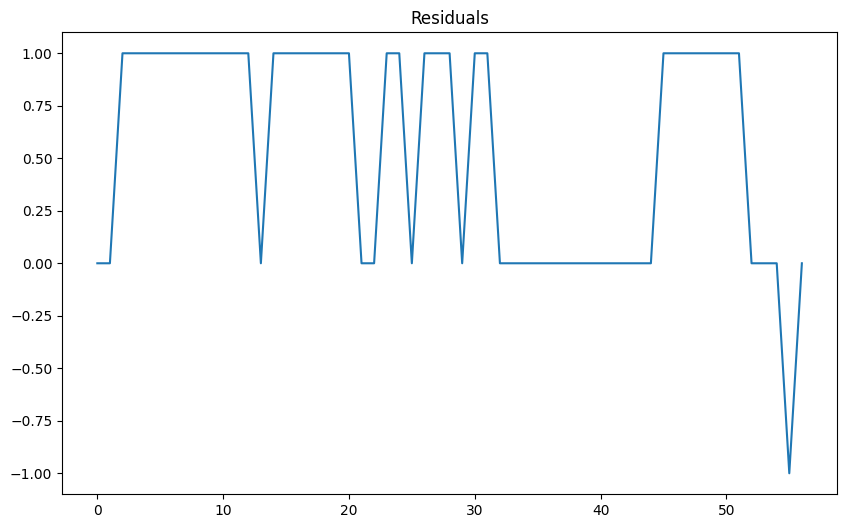


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 3.63, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 3.63, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 3.64, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-23 00:00:00, Preço previsto = 3.64, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 3.65, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 3.65, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 3.66, Preço real = 3.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 3.67, Preço real = 3.81, Comportamento

In [ ]:
COB_linear = datacob()

# Calcula as médias móveis
COB_linear['MA_30'] = COB_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
COB_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
COB_linear['Category'] = (COB_linear['Open'] > COB_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = COB_linear[['Date', 'MA_30']].values
y = COB_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = COB_linear.iloc[train_size + i]['MA_30']
    actual_price = COB_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.5161290322580645
Confusion Matrix:
 [[ 7 27]
 [ 3 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.21      0.32        34
           1       0.48      0.89      0.62        28

    accuracy                           0.52        62
   macro avg       0.59      0.55      0.47        62
weighted avg       0.60      0.52      0.46        62

Mean Squared Error (MSE): 0.4838709677419355
R-squared (R2): -0.9537815126050417
Root Mean Squared Error (RMSE): 0.6956083436402524
Mean Absolute Error (MAE): 0.4838709677419355
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-33-fafee58774db>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-33-fafee58774db>:57: RuntimeWarning:

invalid value encountered in divide



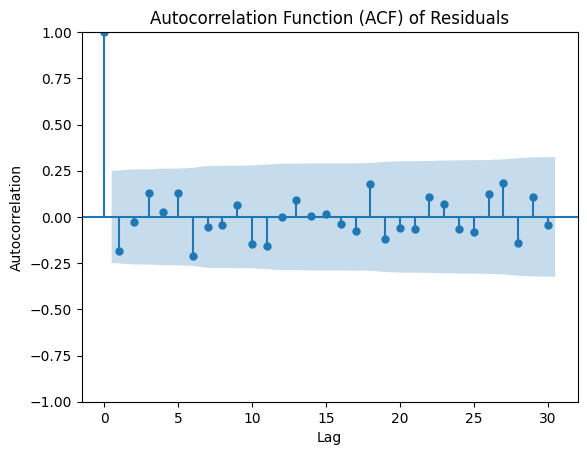


Resultados Previstos:
Data = 2023-11-13 00:00:00, Preço previsto = 51.06, Preço real = 3.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 58.76, Preço real = 3.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 54.90, Preço real = 3.68, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 56.71, Preço real = 3.69, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 55.63, Preço real = 3.69, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-20 00:00:00, Preço previsto = 63.03, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 68.43, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 63.40, Preço real = 3.78, Compor

In [ ]:
COB_RSI14 = datacob()

# Calcula o RSI14
COB_RSI14['RSI14'] = ta.momentum.rsi(COB_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
COB_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
COB_RSI14['Category'] = (COB_RSI14['Open'] > COB_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = COB_RSI14[['Date', 'RSI14']].values
y = COB_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = COB_RSI14.iloc[train_size + i]['RSI14']
    actual_price = COB_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}
Acurácia: 0.4696969696969697
F1 Score: 0.5882352941176471
Recall: 0.8620689655172413
Precisão: 0.44642857142857145
Matriz de Confusão:
[[ 6 31]
 [ 4 25]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.60      0.16      0.26        37
           1       0.45      0.86      0.59        29

    accuracy                           0.47        66
   macro avg       0.52      0.51      0.42        66
weighted avg       0.53      0.47      0.40        66


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 3.66, Preço real = 3.66, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 3.65, Preço real = 3.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 3.62, Preço real = 3.62, Comportamento previsto = Sobe, Comport

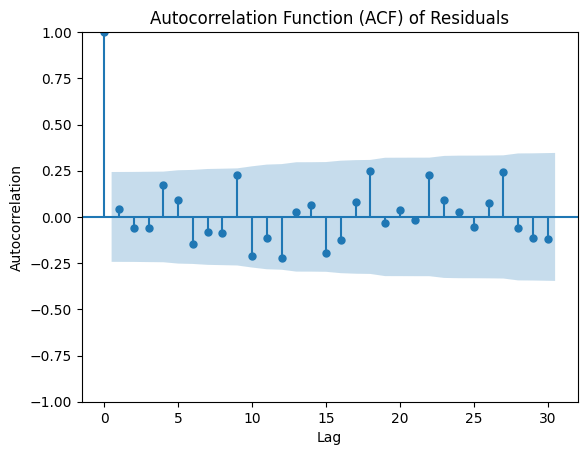

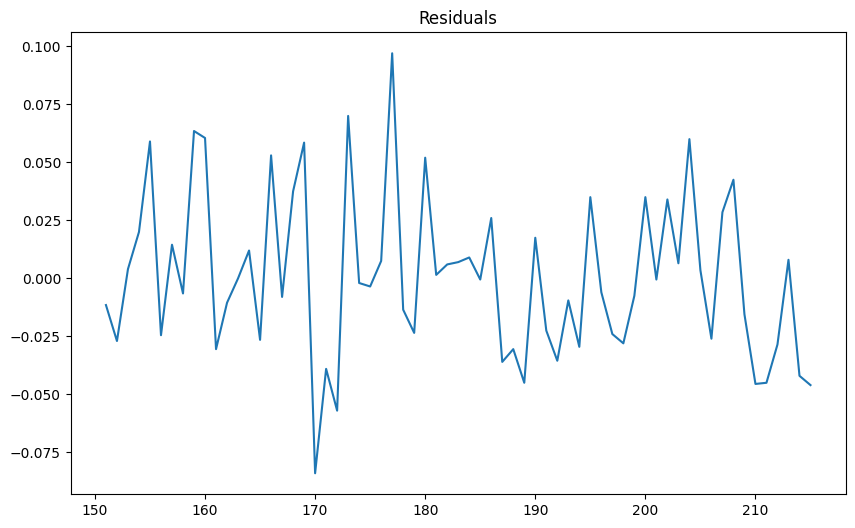

In [ ]:
COB_obv = datacob()

# Cálculo do indicador OBV
COB_obv['OBV'] = (np.sign(COB_obv['Close'].diff()) * COB_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
COB_obv['Target'] = np.where(COB_obv['Open'].shift(-1) > COB_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
COB_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = COB_obv[['Open', 'OBV']]
y = COB_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = COB_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = COB_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Prata americano em USD (SI=F)

####Normal (Sem indicadores)

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.5714285714285714
Confusion Matrix:
 [[27  5]
 [19  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.84      0.69        32
           1       0.50      0.21      0.29        24

    accuracy                           0.57        56
   macro avg       0.54      0.53      0.49        56
weighted avg       0.55      0.57      0.52        56

Mean Squared Error (MSE): 0.42857142857142855
R-squared (R2): -0.75
Root Mean Squared Error (RMSE): 0.6546536707079771
Mean Absolute Error (MAE): 0.42857142857142855
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-35-e2e81aef01ee>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-35-e2e81aef01ee>:57: RuntimeWarning:

invalid value encountered in divide



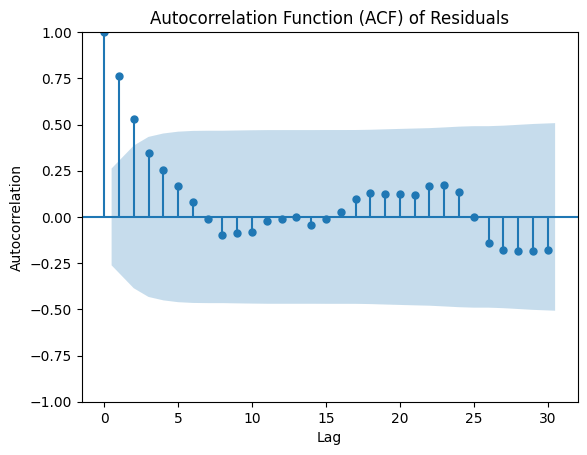

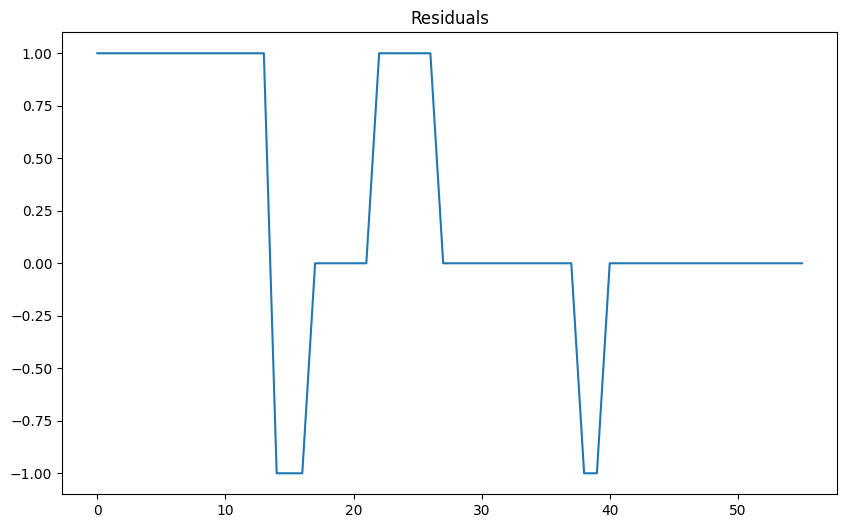


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 22.76, Preço real = 23.46, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 22.82, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 22.89, Preço real = 23.67, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 22.94, Preço real = 24.32, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 23.02, Preço real = 24.81, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 23.10, Preço real = 24.93, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 23.17, Preço real = 25.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 23.25, Preço real = 25

In [ ]:
PRA_Normal = datasil()

# Calcula as médias móveis
PRA_Normal['MA_30'] = PRA_Normal['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
PRA_Normal.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
PRA_Normal['Category'] = (PRA_Normal['Open'] > PRA_Normal['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_Normal[['Date', 'MA_30']].values
y = PRA_Normal['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = PRA_Normal.iloc[train_size + i]['MA_30']
    actual_price = PRA_Normal.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


#### MA-30 (Média Móvel) | Indicador de sobreposição

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.5892857142857143
Confusion Matrix:
 [[27  5]
 [18  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.84      0.70        32
           1       0.55      0.25      0.34        24

    accuracy                           0.59        56
   macro avg       0.57      0.55      0.52        56
weighted avg       0.58      0.59      0.55        56

Mean Squared Error (MSE): 0.4107142857142857
R-squared (R2): -0.6770833333333335
Root Mean Squared Error (RMSE): 0.6408699444616557
Mean Absolute Error (MAE): 0.4107142857142857
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-36-68ef5dd99fab>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-36-68ef5dd99fab>:57: RuntimeWarning:

invalid value encountered in divide



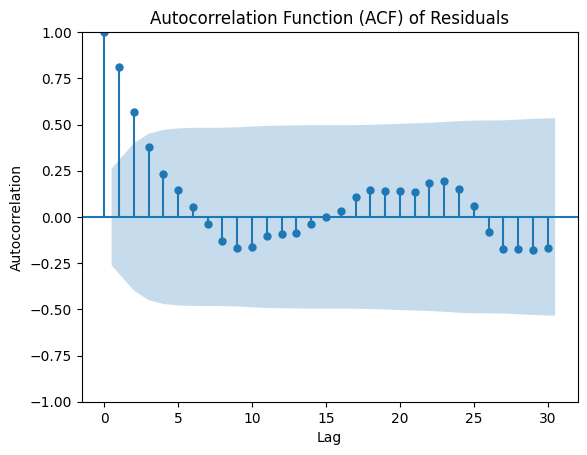

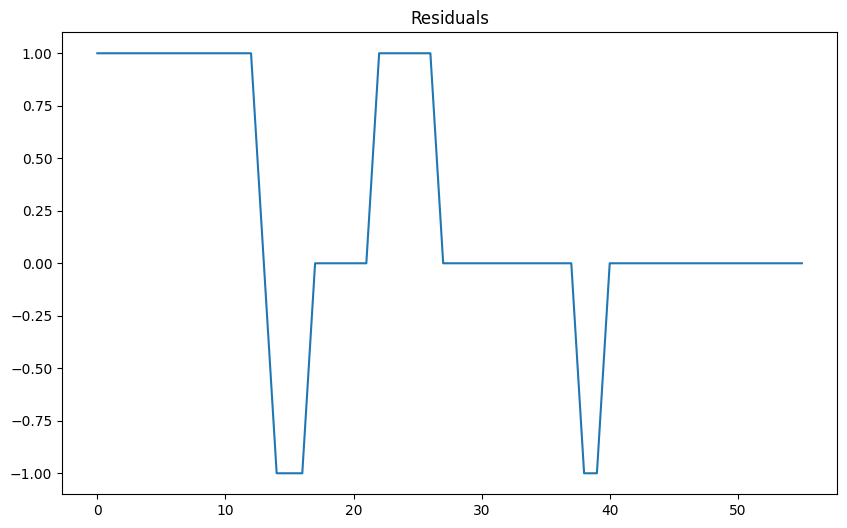


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 22.76, Preço real = 23.46, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 22.82, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 22.89, Preço real = 23.67, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 22.94, Preço real = 24.32, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 23.02, Preço real = 24.81, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 23.10, Preço real = 24.93, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 23.17, Preço real = 25.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 23.25, Preço real = 25

In [ ]:
PRA_linear = datasil()

# Calcula as médias móveis
PRA_linear['MA_30'] = PRA_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
PRA_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
PRA_linear['Category'] = (PRA_linear['Open'] > PRA_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_linear[['Date', 'MA_30']].values
y = PRA_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = PRA_linear.iloc[train_size + i]['MA_30']
    actual_price = PRA_linear.iloc[train_size + i]['Open']
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_label(pred), comportamento_label(y_test[i])))


####RSI14 (*Relative Strength Index*) | Indicador de Momento

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.5245901639344263
Confusion Matrix:
 [[17 15]
 [14 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.53      0.54        32
           1       0.50      0.52      0.51        29

    accuracy                           0.52        61
   macro avg       0.52      0.52      0.52        61
weighted avg       0.53      0.52      0.52        61

Mean Squared Error (MSE): 0.47540983606557374
R-squared (R2): -0.9062500000000002
Root Mean Squared Error (RMSE): 0.6894996998299374
Mean Absolute Error (MAE): 0.47540983606557374
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-37-5f8e0a1bf042>:57: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-37-5f8e0a1bf042>:57: RuntimeWarning:

invalid value encountered in divide



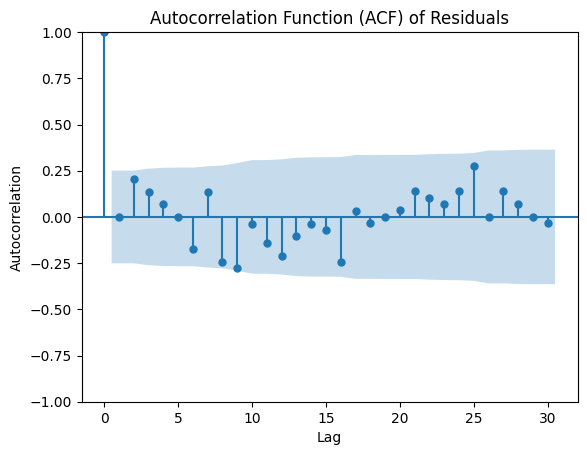

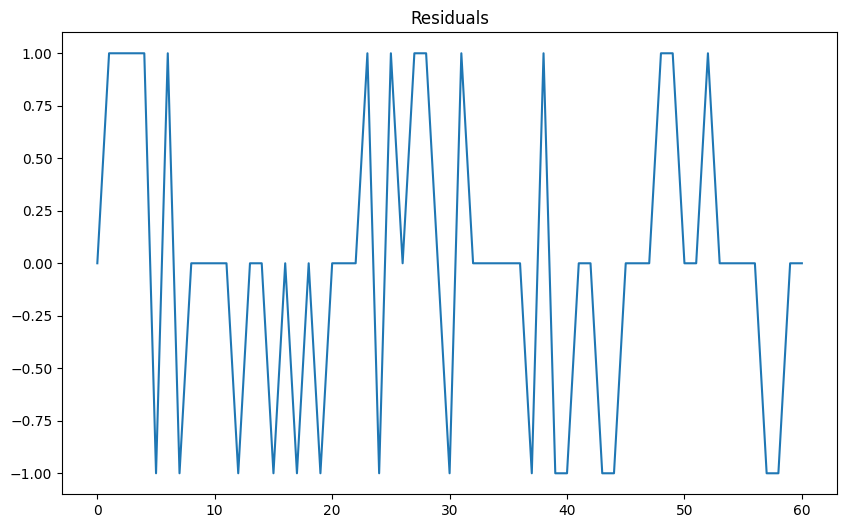


Resultados Previstos:
Data = 2023-11-13 00:00:00, Preço previsto = 41.94, Preço real = 22.08, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-14 00:00:00, Preço previsto = 45.52, Preço real = 22.33, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 58.26, Preço real = 23.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 59.07, Preço real = 23.58, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 61.97, Preço real = 23.91, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, Preço previsto = 56.18, Preço real = 23.46, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 59.01, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 57.79, Preço real = 2

In [ ]:
PRA_RSI14 = datasil()

# Calcula o RSI14
PRA_RSI14['RSI14'] = ta.momentum.rsi(PRA_RSI14['Open'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
PRA_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
PRA_RSI14['Category'] = (PRA_RSI14['Open'] > PRA_RSI14['Open'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_RSI14[['Date', 'RSI14']].values
y = PRA_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o modelo RandomForestClassifier
model = RandomForestClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    predicted_price = PRA_RSI14.iloc[train_size + i]['RSI14']
    actual_price = PRA_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV | Indicador de Volume/Momento

In [ ]:
PRA_obs = datasil()

# Cálculo do indicador OBV
PRA_obs['OBV'] = (np.sign(PRA_obs['Close'].diff()) * PRA_obs['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
PRA_obs['Target'] = np.where(PRA_obs['Open'].shift(-1) > PRA_obs['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
PRA_obs.dropna(inplace=True)

# Seleção de recursos e rótulos
X = PRA_obs[['Open', 'OBV']]
y = PRA_obs['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = PRA_obs.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = PRA_obs.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove th

Melhores Parâmetros: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 300}
Acurácia: 0.4153846153846154
F1 Score: 0.5581395348837209
Recall: 0.7741935483870968
Precisão: 0.43636363636363634
Matriz de Confusão:
[[ 3 31]
 [ 7 24]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.30      0.09      0.14        34
           1       0.44      0.77      0.56        31

    accuracy                           0.42        65
   macro avg       0.37      0.43      0.35        65
weighted avg       0.37      0.42      0.34        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 22.77, Preço real = 22.77, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 22.33, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 22.52, Preço real = 22.52, Comportamento previsto = Sobe,

## KNN (*K-Nearest Neighbors*)

### Alibaba (BABA)

####Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.5076923076923077
Confusion Matrix:
 [[ 4 32]
 [ 0 29]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20        36
           1       0.48      1.00      0.64        29

    accuracy                           0.51        65
   macro avg       0.74      0.56      0.42        65
weighted avg       0.77      0.51      0.40        65

Mean Squared Error (MSE): 3.6392783402534405
R-squared (R2): 0.7975534954552567
Root Mean Squared Error (RMSE): 1.9076892672166084
Mean Absolute Error (MAE): 1.3123431205749512
Mean Absolute Percentage Error (MAPE): 1.748228037291722


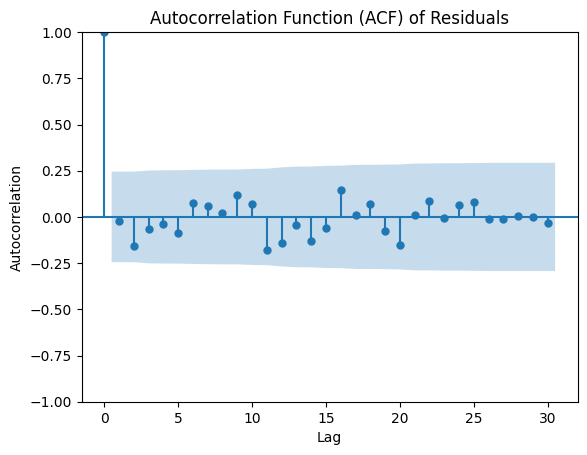

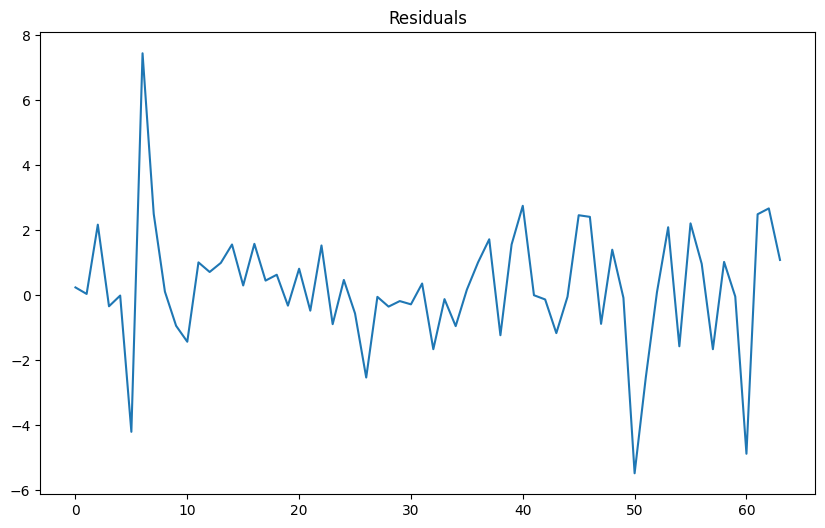


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 84.62, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 84.58, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 82.41, Preço real = 84.58, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-10 00:00:00, Preço previsto = 82.75, Preço real = 82.41, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 82.76, Preço real = 82.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 86.96, Preço real = 82.76, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 79.52, Preço real = 86.96, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 77.02, Preço real = 7

In [ ]:
# Carrega os dados
BABA_normal = datababa()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_normal['Target'] = (BABA_normal['Open'].shift(-1) > BABA_normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
BABA_normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_normal[['Date', 'Open']].values
y = BABA_normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.75
Confusion Matrix:
 [[42  0]
 [14  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        42
           1       0.00      0.00      0.00        14

    accuracy                           0.75        56
   macro avg       0.38      0.50      0.43        56
weighted avg       0.56      0.75      0.64        56

Mean Squared Error (MSE): 0.25
R-squared (R2): -0.33333333333333326
Root Mean Squared Error (RMSE): 0.5
Mean Absolute Error (MAE): 0.25
Mean Absolute Percentage Error (MAPE): nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<ipython-input-40-da5b9657035c>:56: RuntimeWarning:

invalid value encountered in divide



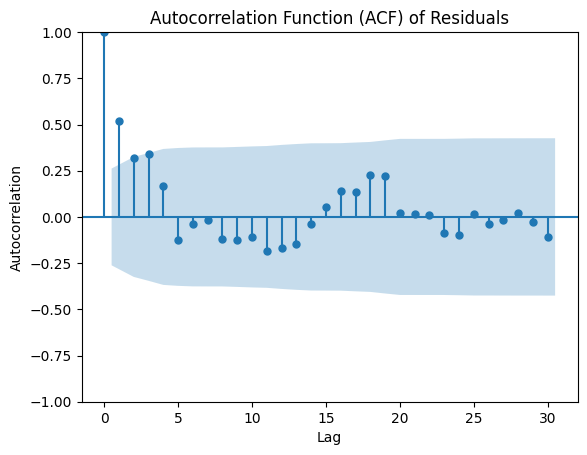


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 83.15, Preço real = 76.91, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 82.92, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-22 00:00:00, Preço previsto = 82.66, Preço real = 79.28, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 82.37, Preço real = 78.27, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-27 00:00:00, Preço previsto = 82.06, Preço real = 77.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-28 00:00:00, Preço previsto = 81.84, Preço real = 76.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-29 00:00:00, Preço previsto = 81.60, Preço real = 75.00, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-30 00:00:00, Preço previsto = 81.34, Preço re

In [ ]:
BABA_linear = datababa()

# Calcula as médias móveis
BABA_linear['MA_30'] = BABA_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
BABA_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
BABA_linear['Category'] = (BABA_linear['Open'] > BABA_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_linear[['Date', 'MA_30']].values
y = BABA_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = BABA_linear.iloc[train_size + i]['MA_30']
    actual_price = BABA_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.5901639344262295
Confusion Matrix:
 [[24 10]
 [15 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66        34
           1       0.55      0.44      0.49        27

    accuracy                           0.59        61
   macro avg       0.58      0.58      0.57        61
weighted avg       0.58      0.59      0.58        61

Mean Squared Error (MSE): 0.4098360655737705
R-squared (R2): -0.6612200435729849
Root Mean Squared Error (RMSE): 0.6401843996644799
Mean Absolute Error (MAE): 0.4098360655737705
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-41-3ef10c557fe8>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-41-3ef10c557fe8>:56: RuntimeWarning:

invalid value encountered in divide



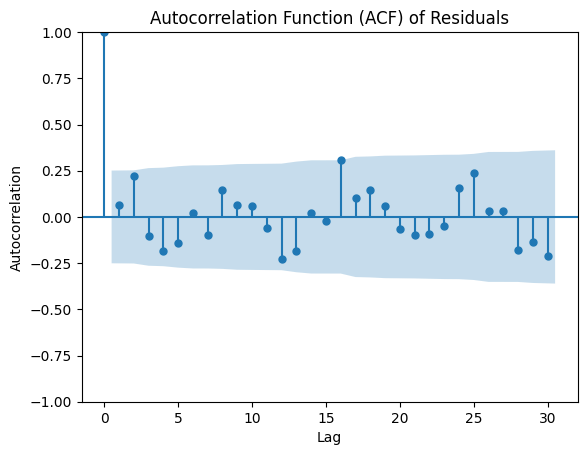


Resultados Previstos:
Data = 2023-11-13 00:00:00, RSI14 = 42.78, Preço real = 82.75, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-14 00:00:00, RSI14 = 49.61, Preço real = 82.76, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, RSI14 = 59.85, Preço real = 86.96, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, RSI14 = 38.75, Preço real = 79.52, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-17 00:00:00, RSI14 = 36.14, Preço real = 77.02, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-20 00:00:00, RSI14 = 38.67, Preço real = 76.91, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, RSI14 = 40.10, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, RSI14 = 40.16, Preço real = 79.28, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2

In [ ]:
BABA_RSI14 = datababa()

# Calcula o RSI14
BABA_RSI14['RSI14'] = ta.momentum.rsi(BABA_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
BABA_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
BABA_RSI14['Category'] = (BABA_RSI14['Close'] > BABA_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_RSI14[['Date', 'RSI14']].values
y = BABA_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = BABA_RSI14.iloc[train_size + i]['RSI14']
    actual_price = BABA_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed


Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Acurácia: 0.5692307692307692
F1 Score: 0.4166666666666667
Recall: 0.3448275862068966
Precisão: 0.5263157894736842
Matriz de Confusão:
[[27  9]
 [19 10]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.59      0.75      0.66        36
           1       0.53      0.34      0.42        29

    accuracy                           0.57        65
   macro avg       0.56      0.55      0.54        65
weighted avg       0.56      0.57      0.55        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 84.86, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 84.62, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 84.58, Preço real = 84.58, Comportamento previsto = Sobe, Comportamento real =

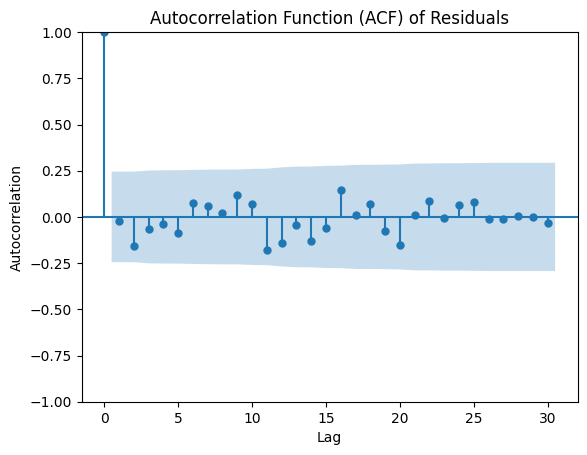

In [ ]:
BABA_obv = datababa()

# Cálculo do indicador OBV
BABA_obv['OBV'] = (np.sign(BABA_obv['Close'].diff()) * BABA_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
BABA_obv['Target'] = np.where(BABA_obv['Open'].shift(-1) > BABA_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
BABA_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = BABA_obv[['Open', 'OBV']]
y = BABA_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = BABA_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = BABA_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Advanced Micro Devices, INC. (AMD)

####Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Accuracy: 0.46153846153846156
Confusion Matrix:
 [[24  1]
 [34  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.96      0.58        25
           1       0.86      0.15      0.26        40

    accuracy                           0.46        65
   macro avg       0.64      0.55      0.42        65
weighted avg       0.69      0.46      0.38        65

Mean Squared Error (MSE): 17.676029273059612
R-squared (R2): 0.959757525636354
Root Mean Squared Error (RMSE): 4.204287011261197
Mean Absolute Error (MAE): 3.086249828338623
Mean Absolute Percentage Error (MAPE): 2.082593246873206


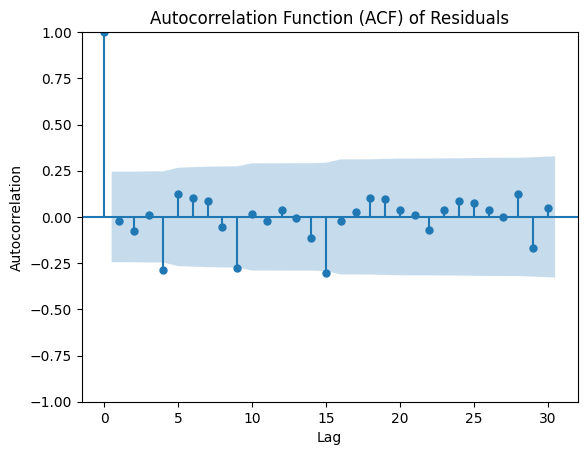

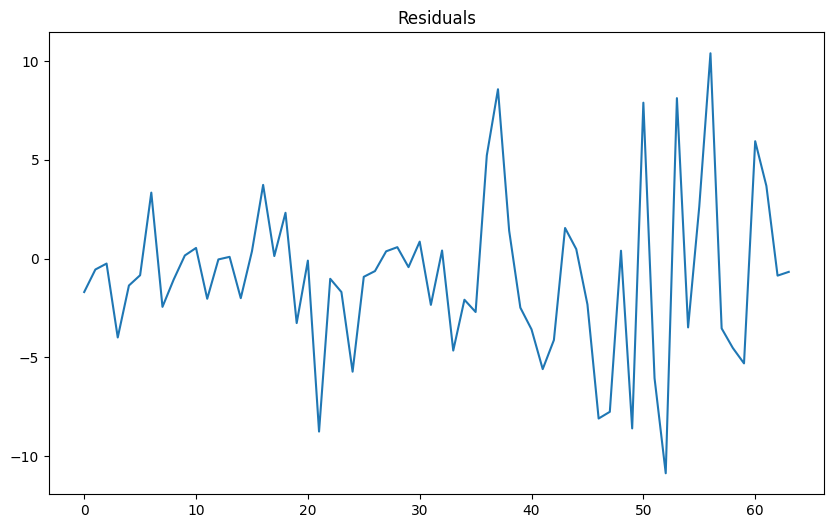


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 113.55, Preço real = 111.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 114.10, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.35, Preço real = 114.10, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 118.34, Preço real = 114.35, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 119.70, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 120.54, Preço real = 119.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 117.20, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 119.64, Pre

In [ ]:
# Carrega os dados
AMD_Normal = dataamd()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_Normal['Target'] = (AMD_Normal['Open'].shift(-1) > AMD_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
AMD_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_Normal[['Date', 'Open']].values
y = AMD_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.0
Confusion Matrix:
 [[ 0  0]
 [56  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      56.0

    accuracy                           0.00      56.0
   macro avg       0.00      0.00      0.00      56.0
weighted avg       0.00      0.00      0.00      56.0

Mean Squared Error (MSE): 1.0
R-squared (R2): 0.0
Root Mean Squared Error (RMSE): 1.0
Mean Absolute Error (MAE): 1.0
Mean Absolute Percentage Error (MAPE): 100.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to cont

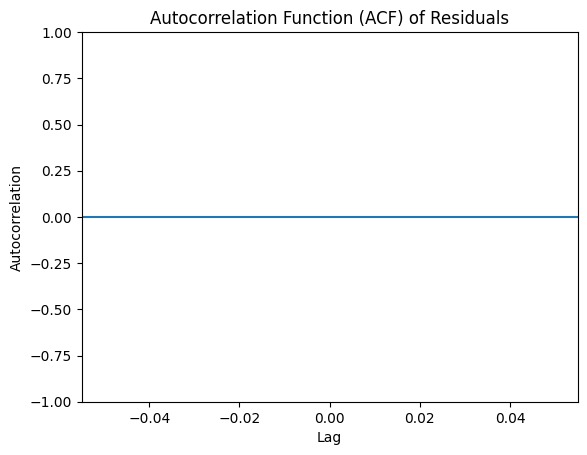

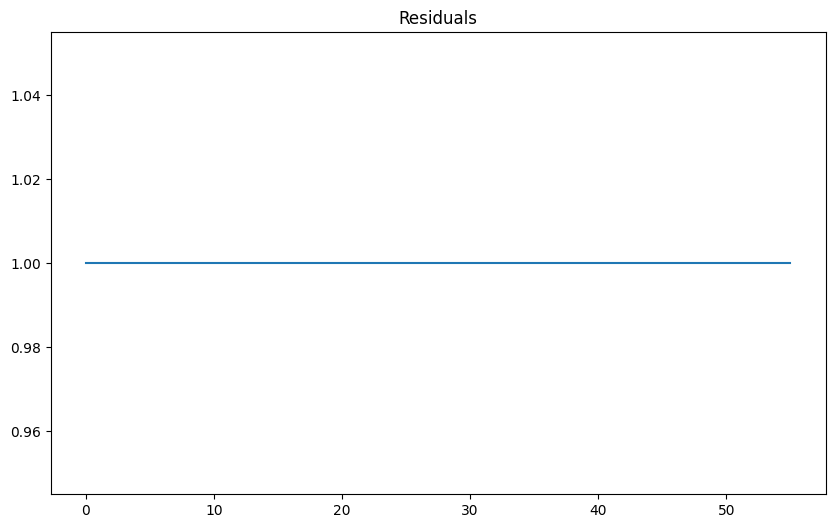


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 107.40, Preço real = 120.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 107.89, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 108.32, Preço real = 120.00, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 108.69, Preço real = 122.03, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 109.14, Preço real = 122.07, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 109.59, Preço real = 121.98, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 110.14, Preço real = 123.98, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 110.82, 

In [ ]:
AMD_linear = dataamd()

# Calcula as médias móveis
AMD_linear['MA_30'] = AMD_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
AMD_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
AMD_linear['Category'] = (AMD_linear['Open'] > AMD_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_linear[['Date', 'MA_30']].values
y = AMD_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = AMD_linear.iloc[train_size + i]['MA_30']
    actual_price = AMD_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


#### RSI14

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.639344262295082
Confusion Matrix:
 [[ 6 20]
 [ 2 33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.23      0.35        26
           1       0.62      0.94      0.75        35

    accuracy                           0.64        61
   macro avg       0.69      0.59      0.55        61
weighted avg       0.68      0.64      0.58        61

Mean Squared Error (MSE): 0.36065573770491804
R-squared (R2): -0.4747252747252748
Root Mean Squared Error (RMSE): 0.6005461994758755
Mean Absolute Error (MAE): 0.36065573770491804
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-45-e20c8b56d0df>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-45-e20c8b56d0df>:56: RuntimeWarning:

invalid value encountered in divide



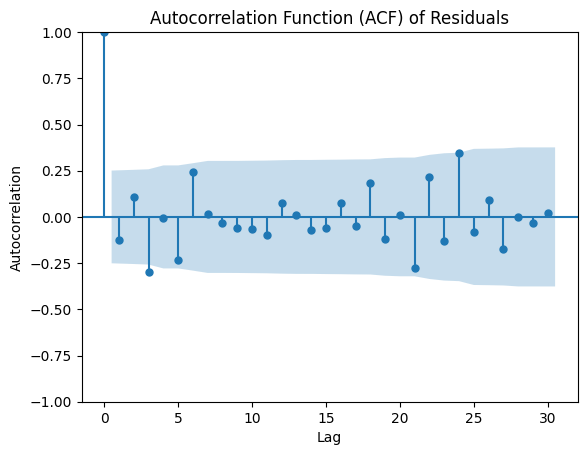


Resultados Previstos:
Data = 2023-11-13 00:00:00, RSI14 = 66.54, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-14 00:00:00, RSI14 = 69.79, Preço real = 119.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, RSI14 = 65.61, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-16 00:00:00, RSI14 = 67.64, Preço real = 117.20, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, RSI14 = 68.51, Preço real = 119.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, RSI14 = 69.52, Preço real = 120.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, RSI14 = 63.78, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-22 00:00:00, RSI14 = 67.82, Preço real = 120.00, Comportamento previsto = Sobe, Comportamento real = Sobe
Data =

In [ ]:
AMD_RSI14 = dataamd()

# Calcula o RSI14
AMD_RSI14['RSI14'] = ta.momentum.rsi(AMD_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
AMD_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
AMD_RSI14['Category'] = (AMD_RSI14['Close'] > AMD_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_RSI14[['Date', 'RSI14']].values
y = AMD_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = AMD_RSI14.iloc[train_size + i]['RSI14']
    actual_price = AMD_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Acurácia: 0.6153846153846154
F1 Score: 0.761904761904762
Recall: 1.0
Precisão: 0.6153846153846154
Matriz de Confusão:
[[ 0 25]
 [ 0 40]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.62      1.00      0.76        40

    accuracy                           0.62        65
   macro avg       0.31      0.50      0.38        65
weighted avg       0.38      0.62      0.47        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 111.86, Preço real = 111.86, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 113.55, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.10, Preço real = 114.10, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 20

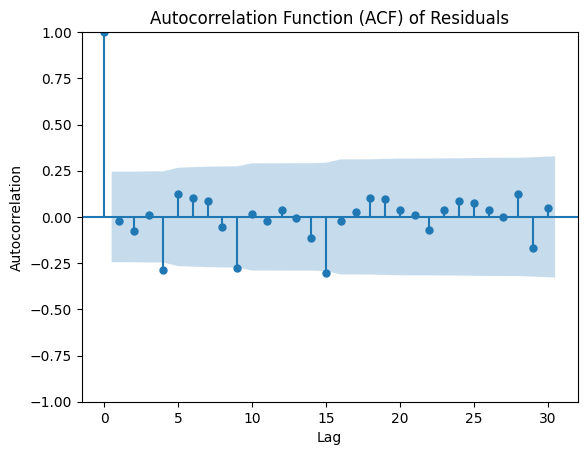

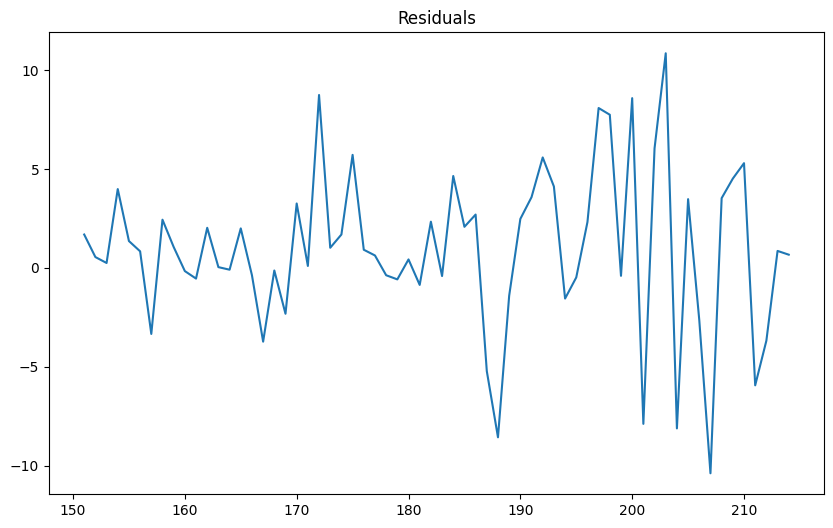

In [ ]:
# Passo 1: Obtenção e preparação dos dados
AMD_obv = dataamd()

# Cálculo do indicador OBV
AMD_obv['OBV'] = (np.sign(AMD_obv['Close'].diff()) * AMD_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
AMD_obv['Target'] = np.where(AMD_obv['Open'].shift(-1) > AMD_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
AMD_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = AMD_obv[['Open', 'OBV']]
y = AMD_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Passo 4: Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = AMD_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = AMD_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Monero em Dolar (XMR-USD)

#### Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.5272727272727272
Confusion Matrix:
 [[44  9]
 [43 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.83      0.63        53
           1       0.61      0.25      0.35        57

    accuracy                           0.53       110
   macro avg       0.56      0.54      0.49       110
weighted avg       0.56      0.53      0.48       110

Mean Squared Error (MSE): 52.48280260750998
R-squared (R2): 0.4745770636338078
Root Mean Squared Error (RMSE): 7.244501543067679
Mean Absolute Error (MAE): 3.4309758177591028
Mean Absolute Percentage Error (MAPE): 2.174353650566502


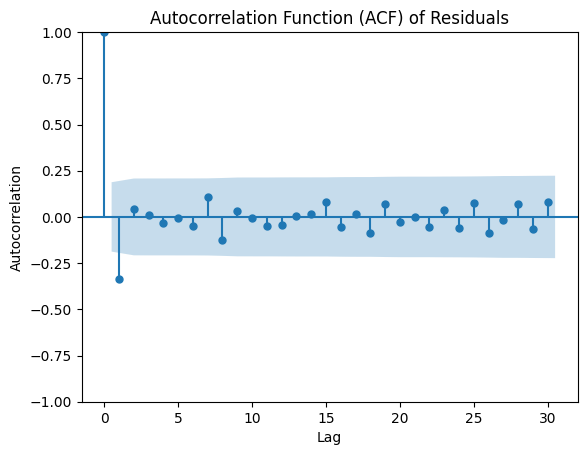

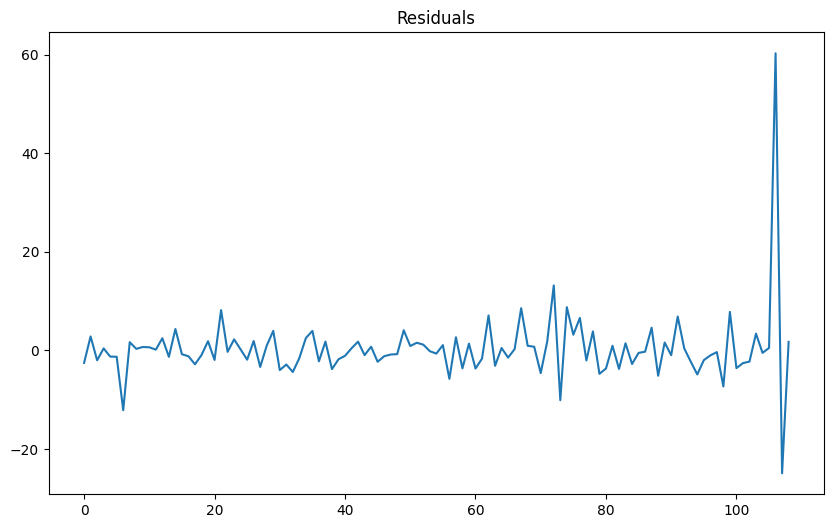


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 160.88, Preço real = 158.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 158.05, Preço real = 160.88, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-25 00:00:00, Preço previsto = 160.05, Preço real = 158.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-26 00:00:00, Preço previsto = 159.65, Preço real = 160.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-27 00:00:00, Preço previsto = 160.90, Preço real = 159.65, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, Preço previsto = 162.19, Preço real = 160.90, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 174.32, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 172.65, P

In [ ]:
# Carrega os dados
XMR_Normal = dataxmr()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_Normal['Target'] = (XMR_Normal['Open'].shift(-1) > XMR_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
XMR_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_Normal[['Date', 'Open']].values
y = XMR_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


#### MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.4752475247524752
Confusion Matrix:
 [[43  3]
 [50  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.93      0.62        46
           1       0.62      0.09      0.16        55

    accuracy                           0.48       101
   macro avg       0.54      0.51      0.39       101
weighted avg       0.55      0.48      0.37       101

Mean Squared Error (MSE): 0.5247524752475248
R-squared (R2): -1.1158102766798423
Root Mean Squared Error (RMSE): 0.7243980088649642
Mean Absolute Error (MAE): 0.5247524752475248
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-48-cd56a1d00f9b>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-48-cd56a1d00f9b>:56: RuntimeWarning:

invalid value encountered in divide



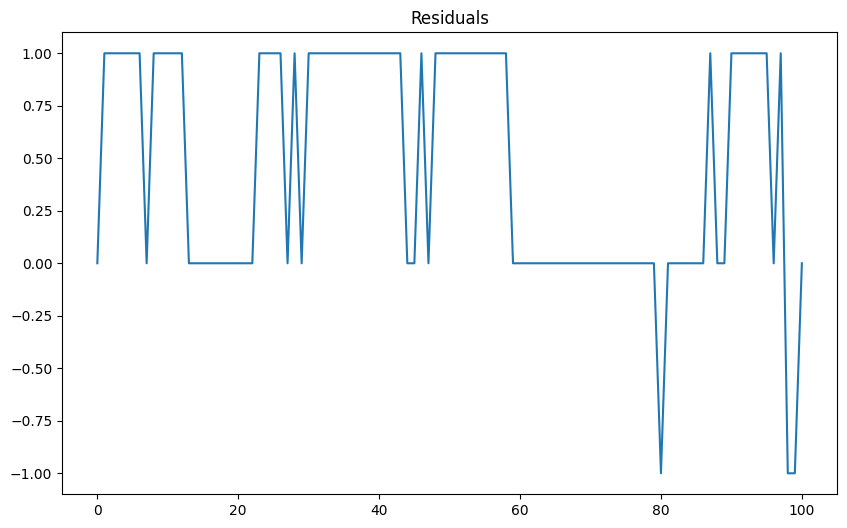


Resultados Previstos:
Data = 2023-11-01 00:00:00, Preço previsto = 155.41, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-02 00:00:00, Preço previsto = 156.18, Preço real = 171.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 157.03, Preço real = 171.01, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-04 00:00:00, Preço previsto = 157.82, Preço real = 170.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-05 00:00:00, Preço previsto = 158.50, Preço real = 168.39, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-06 00:00:00, Preço previsto = 159.13, Preço real = 169.69, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 159.72, Preço real = 165.35, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 160.05, P

In [ ]:
XMR_linear = dataxmr()

# Calcula as médias móveis
XMR_linear['MA_30'] = XMR_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
XMR_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
XMR_linear['Category'] = (XMR_linear['Open'] > XMR_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_linear[['Date', 'MA_30']].values
y = XMR_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = XMR_linear.iloc[train_size + i]['MA_30']
    actual_price = XMR_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.5849056603773585
Confusion Matrix:
 [[22 29]
 [15 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.43      0.50        51
           1       0.58      0.73      0.65        55

    accuracy                           0.58       106
   macro avg       0.59      0.58      0.57       106
weighted avg       0.59      0.58      0.58       106

Mean Squared Error (MSE): 0.41509433962264153
R-squared (R2): -0.662745098039216
Root Mean Squared Error (RMSE): 0.644278153923165
Mean Absolute Error (MAE): 0.41509433962264153
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-51-8c3cdd90ebb8>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-51-8c3cdd90ebb8>:56: RuntimeWarning:

invalid value encountered in divide



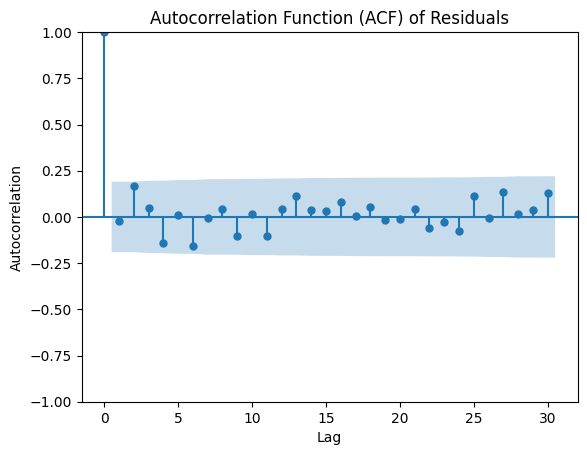


Resultados Previstos:
Data = 2023-10-27 00:00:00, RSI14 = 65.63, Preço real = 159.65, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, RSI14 = 67.62, Preço real = 160.90, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, RSI14 = 79.54, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, RSI14 = 75.32, Preço real = 174.32, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-31 00:00:00, RSI14 = 74.64, Preço real = 172.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-01 00:00:00, RSI14 = 72.79, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-02 00:00:00, RSI14 = 71.10, Preço real = 171.64, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-03 00:00:00, RSI14 = 70.68, Preço real = 171.01, Comportamento previsto = Sobe, Comportamento real = Desce
Data

In [ ]:
XMR_RSI14 = dataxmr()

# Calcula o RSI14
XMR_RSI14['RSI14'] = ta.momentum.rsi(XMR_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
XMR_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
XMR_RSI14['Category'] = (XMR_RSI14['Close'] > XMR_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_RSI14[['Date', 'RSI14']].values
y = XMR_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = XMR_RSI14.iloc[train_size + i]['RSI14']
    actual_price = XMR_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed


Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Acurácia: 0.5363636363636364
F1 Score: 0.679245283018868
Recall: 0.9473684210526315
Precisão: 0.5294117647058824
Matriz de Confusão:
[[ 5 48]
 [ 3 54]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.62      0.09      0.16        53
           1       0.53      0.95      0.68        57

    accuracy                           0.54       110
   macro avg       0.58      0.52      0.42       110
weighted avg       0.58      0.54      0.43       110


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 158.34, Preço real = 158.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 160.88, Preço real = 160.88, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-25 00:00:00, Preço previsto = 158.05, Preço real = 158.05, Comportamento previsto = Sobe, Comportamento real 

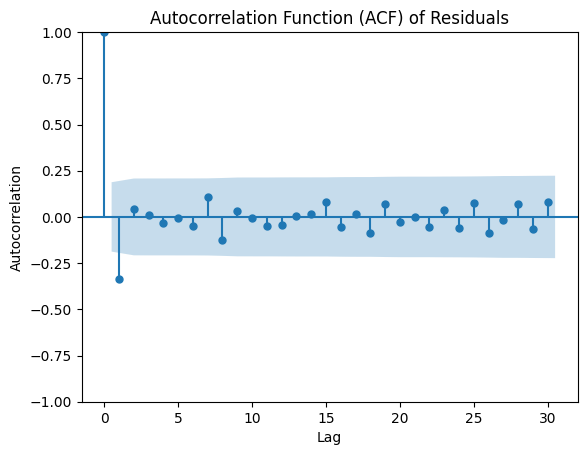

In [ ]:
XMR_obv = dataxmr()

# Cálculo do indicador OBV
XMR_obv['OBV'] = (np.sign(XMR_obv['Close'].diff()) * XMR_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
XMR_obv['Target'] = np.where(XMR_obv['Open'].shift(-1) > XMR_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
XMR_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = XMR_obv[['Open', 'OBV']]
y = XMR_obv['Target']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = XMR_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = XMR_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Litecoin em Dolar (LTC-USD)

####Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy: 0.4090909090909091
Confusion Matrix:
 [[27 25]
 [40 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.52      0.45        52
           1       0.42      0.31      0.36        58

    accuracy                           0.41       110
   macro avg       0.41      0.41      0.41       110
weighted avg       0.41      0.41      0.40       110

Mean Squared Error (MSE): 3.1684809369035065
R-squared (R2): 0.6138320155174288
Root Mean Squared Error (RMSE): 1.7800227349400644
Mean Absolute Error (MAE): 1.304996455481293
Mean Absolute Percentage Error (MAPE): 1.8429847761583735


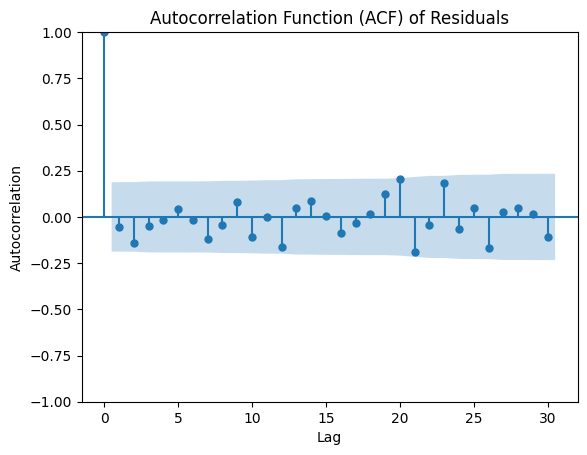

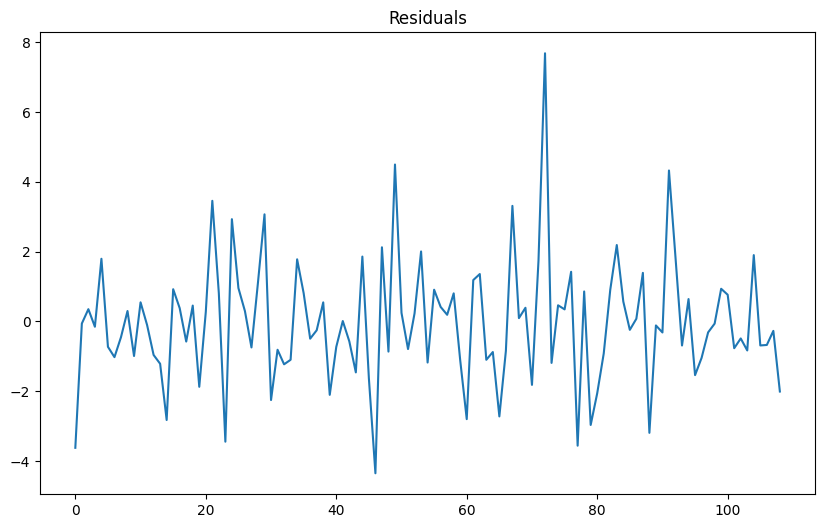


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 68.99, Preço real = 65.37, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 69.05, Preço real = 68.99, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 68.70, Preço real = 69.05, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-26 00:00:00, Preço previsto = 68.85, Preço real = 68.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-27 00:00:00, Preço previsto = 67.05, Preço real = 68.85, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-28 00:00:00, Preço previsto = 67.78, Preço real = 67.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 68.80, Preço real = 67.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 69.25, Preço real = 6

In [ ]:
# Carrega os dados
LTC_Normal = dataltc()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_Normal['Target'] = (LTC_Normal['Open'].shift(-1) > LTC_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
LTC_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_Normal[['Date', 'Open']].values
y = LTC_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.4752475247524752
Confusion Matrix:
 [[43  3]
 [50  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.93      0.62        46
           1       0.62      0.09      0.16        55

    accuracy                           0.48       101
   macro avg       0.54      0.51      0.39       101
weighted avg       0.55      0.48      0.37       101

Mean Squared Error (MSE): 0.5247524752475248
R-squared (R2): -1.1158102766798423
Root Mean Squared Error (RMSE): 0.7243980088649642
Mean Absolute Error (MAE): 0.5247524752475248
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-54-494c4ce263cb>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-54-494c4ce263cb>:56: RuntimeWarning:

invalid value encountered in divide



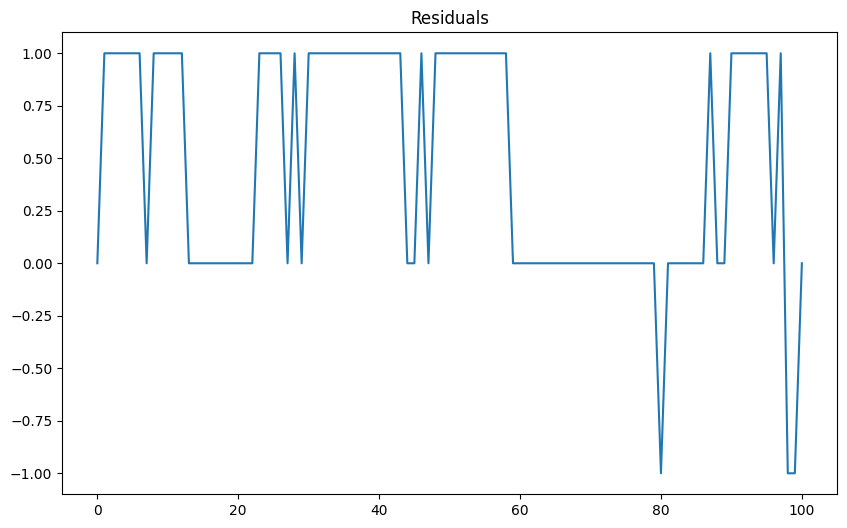


Resultados Previstos:
Data = 2023-11-01 00:00:00, Preço previsto = 155.41, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-02 00:00:00, Preço previsto = 156.18, Preço real = 171.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 157.03, Preço real = 171.01, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-04 00:00:00, Preço previsto = 157.82, Preço real = 170.86, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-05 00:00:00, Preço previsto = 158.50, Preço real = 168.39, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-06 00:00:00, Preço previsto = 159.13, Preço real = 169.69, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 159.72, Preço real = 165.35, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 160.05, P

In [ ]:
LTC_linear = dataxmr()

# Calcula as médias móveis
LTC_linear['MA_30'] = LTC_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
LTC_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
LTC_linear['Category'] = (LTC_linear['Open'] > LTC_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_linear[['Date', 'MA_30']].values
y = LTC_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = LTC_linear.iloc[train_size + i]['MA_30']
    actual_price = LTC_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

In [ ]:
LTC_RSI14 = dataltc()

# Calcula o RSI14
LTC_RSI14['RSI14'] = ta.momentum.rsi(LTC_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
LTC_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
LTC_RSI14['Category'] = (LTC_RSI14['Close'] > LTC_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_RSI14[['Date', 'RSI14']].values
y = LTC_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = LTC_RSI14.iloc[train_size + i]['RSI14']
    actual_price = LTC_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.5943396226415094
Confusion Matrix:
 [[19 31]
 [12 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.38      0.47        50
           1       0.59      0.79      0.67        56

    accuracy                           0.59       106
   macro avg       0.60      0.58      0.57       106
weighted avg       0.60      0.59      0.58       106

Mean Squared Error (MSE): 0.4056603773584906
R-squared (R2): -0.6278571428571427
Root Mean Squared Error (RMSE): 0.6369147331931415
Mean Absolute Error (MAE): 0.4056603773584906
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-59-6b501b6319bf>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-59-6b501b6319bf>:56: RuntimeWarning:

invalid value encountered in divide




Resultados Previstos:
Data = 2023-10-27 00:00:00, RSI14 = 56.74, Preço real = 68.85, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-28 00:00:00, RSI14 = 58.84, Preço real = 67.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, RSI14 = 61.65, Preço real = 67.78, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, RSI14 = 62.85, Preço real = 68.80, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, RSI14 = 61.46, Preço real = 69.25, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-01 00:00:00, RSI14 = 64.25, Preço real = 68.95, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-02 00:00:00, RSI14 = 61.61, Preço real = 69.94, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-03 00:00:00, RSI14 = 61.91, Preço real = 69.39, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11

####OBV

[*********************100%%**********************]  1 of 1 completed


Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Acurácia: 0.5
F1 Score: 0.5378151260504203
Recall: 0.5517241379310345
Precisão: 0.5245901639344263
Matriz de Confusão:
[[23 29]
 [26 32]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.47      0.44      0.46        52
           1       0.52      0.55      0.54        58

    accuracy                           0.50       110
   macro avg       0.50      0.50      0.50       110
weighted avg       0.50      0.50      0.50       110


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 65.37, Preço real = 65.37, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 68.99, Preço real = 68.99, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 69.05, Preço real = 69.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-1

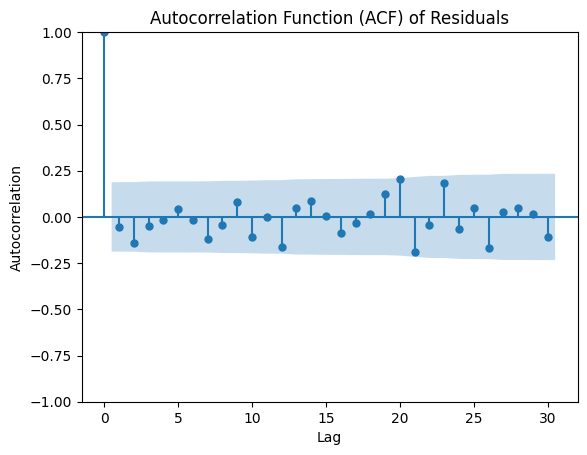

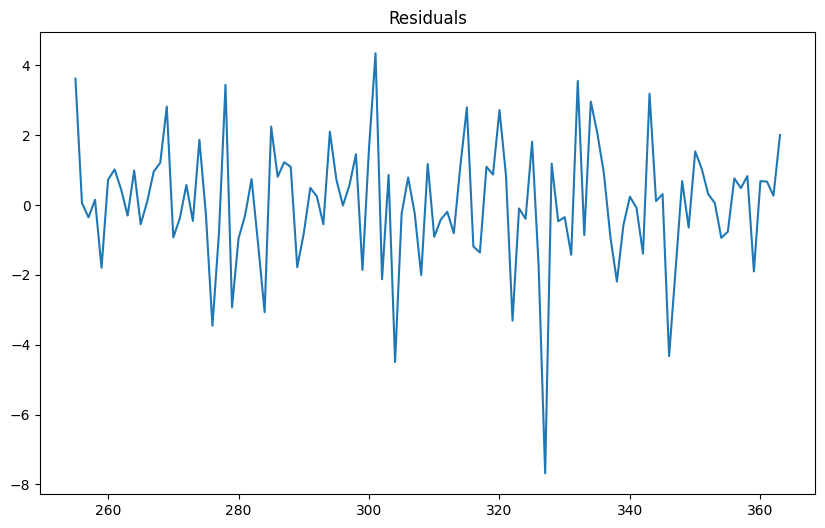

In [ ]:
LTC_obv = dataltc()

# Cálculo do indicador OBV
LTC_obv['OBV'] = (np.sign(LTC_obv['Close'].diff()) * LTC_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
LTC_obv['Target'] = np.where(LTC_obv['Open'].shift(-1) > LTC_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
LTC_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = LTC_obv[['Open', 'OBV']]
y = LTC_obv['Target']

#Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = LTC_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = LTC_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Cobre em USD (HG=F)

####Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Accuracy: 0.48484848484848486
Confusion Matrix:
 [[21 16]
 [18 11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.57      0.55        37
           1       0.41      0.38      0.39        29

    accuracy                           0.48        66
   macro avg       0.47      0.47      0.47        66
weighted avg       0.48      0.48      0.48        66

Mean Squared Error (MSE): 0.0012579368009517987
R-squared (R2): 0.7967056442402758
Root Mean Squared Error (RMSE): 0.035467404767642624
Mean Absolute Error (MAE): 0.02799999530498798
Mean Absolute Percentage Error (MAPE): 0.7376924216574793


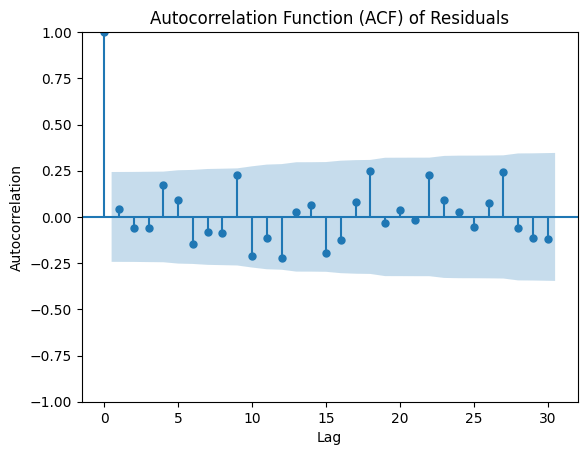


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 3.65, Preço real = 3.66, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 3.62, Preço real = 3.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 3.62, Preço real = 3.62, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 3.64, Preço real = 3.62, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 3.70, Preço real = 3.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 3.68, Preço real = 3.70, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-15 00:00:00, Preço previsto = 3.69, Preço real = 3.68, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 3.69, Preço real = 3.69, Comportamento 

In [ ]:
# Carrega os dados
COB_Normal = datacob()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
COB_Normal['Target'] = (COB_Normal['Open'].shift(-1) > COB_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
COB_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = COB_Normal[['Date', 'Open']].values
y = COB_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.40350877192982454
Confusion Matrix:
 [[17  2]
 [32  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.89      0.50        19
           1       0.75      0.16      0.26        38

    accuracy                           0.40        57
   macro avg       0.55      0.53      0.38        57
weighted avg       0.62      0.40      0.34        57

Mean Squared Error (MSE): 0.5964912280701754
R-squared (R2): -1.6842105263157894
Root Mean Squared Error (RMSE): 0.7723284457212329
Mean Absolute Error (MAE): 0.5964912280701754
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-62-372f96e90087>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-62-372f96e90087>:56: RuntimeWarning:

invalid value encountered in divide



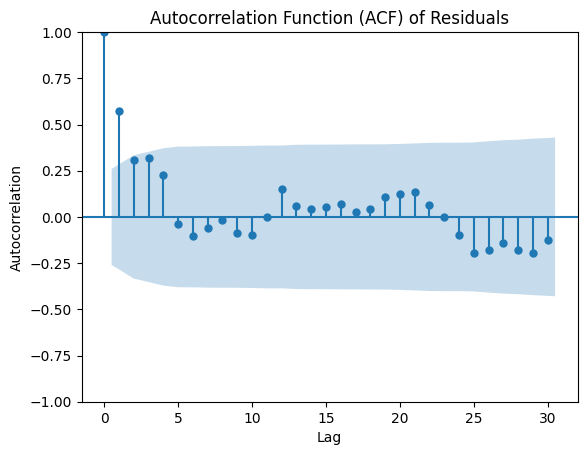

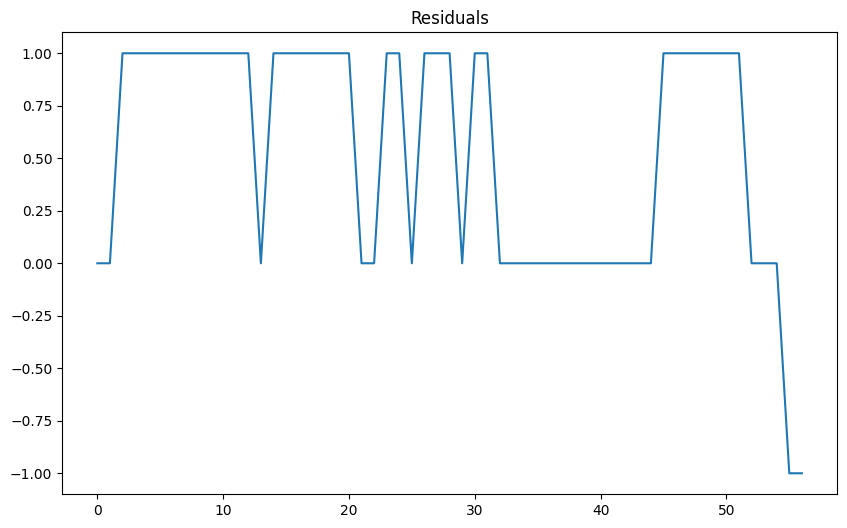


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 3.63, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 3.63, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 3.64, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-23 00:00:00, Preço previsto = 3.64, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 3.65, Preço real = 3.77, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 3.65, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 3.66, Preço real = 3.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 3.67, Preço real = 3.81, Comportamento

In [ ]:
COB_linear = datacob()

# Calcula as médias móveis
COB_linear['MA_30'] = COB_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
COB_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
COB_linear['Category'] = (COB_linear['Open'] > COB_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = COB_linear[['Date', 'MA_30']].values
y = COB_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = COB_linear.iloc[train_size + i]['MA_30']
    actual_price = COB_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Accuracy: 0.6612903225806451
Confusion Matrix:
 [[15 18]
 [ 3 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.45      0.59        33
           1       0.59      0.90      0.71        29

    accuracy                           0.66        62
   macro avg       0.71      0.68      0.65        62
weighted avg       0.72      0.66      0.65        62

Mean Squared Error (MSE): 0.3387096774193548
R-squared (R2): -0.36050156739811934
Root Mean Squared Error (RMSE): 0.5819876952473779
Mean Absolute Error (MAE): 0.3387096774193548
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-63-54397cf2aac1>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-63-54397cf2aac1>:56: RuntimeWarning:

invalid value encountered in divide



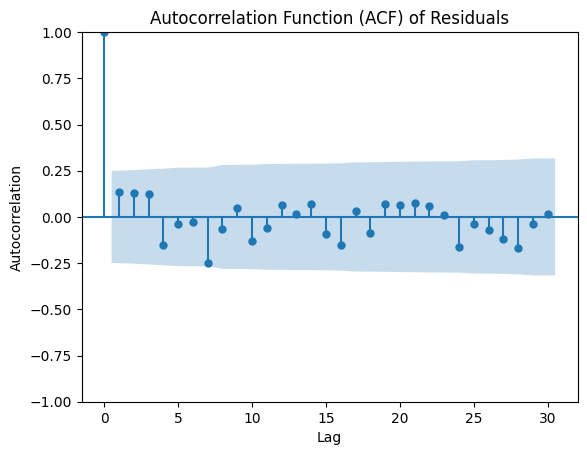


Resultados Previstos:
Data = 2023-11-13 00:00:00, RSI14 = 53.17, Preço real = 3.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, RSI14 = 55.38, Preço real = 3.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, RSI14 = 59.03, Preço real = 3.68, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, RSI14 = 57.16, Preço real = 3.69, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-17 00:00:00, RSI14 = 60.58, Preço real = 3.69, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, RSI14 = 67.02, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, RSI14 = 67.17, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, RSI14 = 59.94, Preço real = 3.78, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-23 00:0

In [ ]:
COB_RSI14 = datacob()

# Calcula o RSI14
COB_RSI14['RSI14'] = ta.momentum.rsi(COB_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
COB_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
COB_RSI14['Category'] = (COB_RSI14['Close'] > COB_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = COB_RSI14[['Date', 'RSI14']].values
y = COB_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = COB_RSI14.iloc[train_size + i]['RSI14']
    actual_price = COB_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed


Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Acurácia: 0.45454545454545453
F1 Score: 0.5609756097560975
Recall: 0.7931034482758621
Precisão: 0.4339622641509434
Matriz de Confusão:
[[ 7 30]
 [ 6 23]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.54      0.19      0.28        37
           1       0.43      0.79      0.56        29

    accuracy                           0.45        66
   macro avg       0.49      0.49      0.42        66
weighted avg       0.49      0.45      0.40        66


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 3.66, Preço real = 3.66, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 3.65, Preço real = 3.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 3.62, Preço real = 3.62, Comportamento previsto = Desce, Comportamento real = Sobe


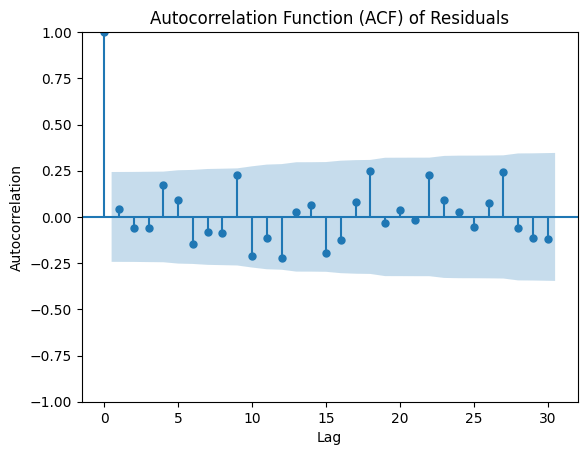

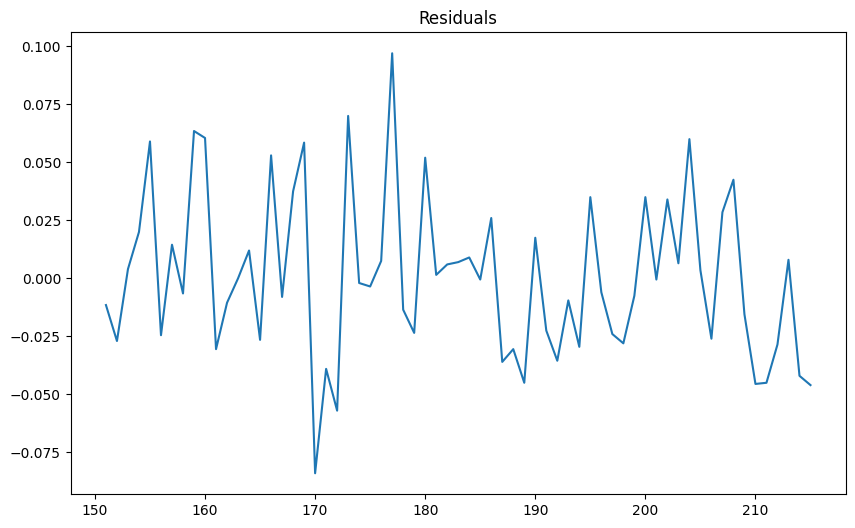

In [ ]:
COB_obv = datacob()

# Cálculo do indicador OBV
COB_obv['OBV'] = (np.sign(COB_obv['Close'].diff()) * COB_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
COB_obv['Target'] = np.where(COB_obv['Open'].shift(-1) > COB_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
COB_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = COB_obv[['Open', 'OBV']]
y = COB_obv['Target']

#Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = COB_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = COB_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


### Prata americano em USD (SI=F)

####Normal

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy: 0.5692307692307692
Confusion Matrix:
 [[17 17]
 [11 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.50      0.55        34
           1       0.54      0.65      0.59        31

    accuracy                           0.57        65
   macro avg       0.57      0.57      0.57        65
weighted avg       0.58      0.57      0.57        65

Mean Squared Error (MSE): 0.13304575683116582
R-squared (R2): 0.8174880698164638
Root Mean Squared Error (RMSE): 0.3647543787690092
Mean Absolute Error (MAE): 0.2703125476837158
Mean Absolute Percentage Error (MAPE): 1.1542020483732567


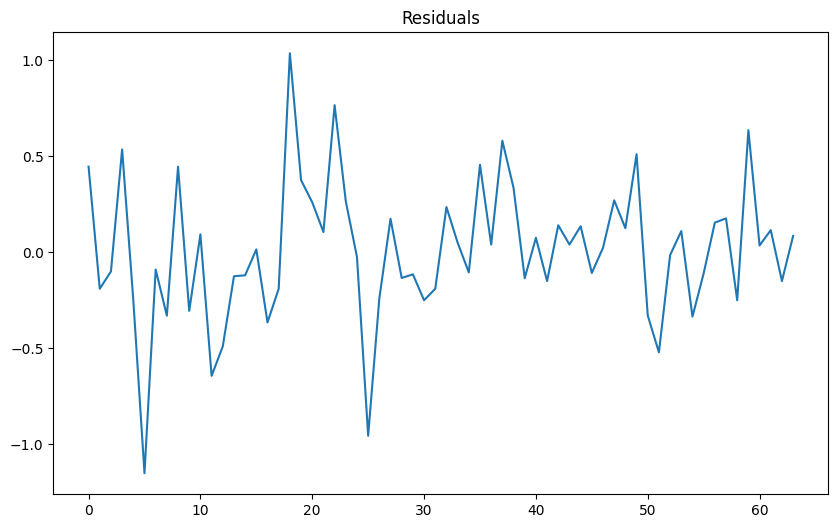


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 22.33, Preço real = 22.77, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 22.52, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 22.62, Preço real = 22.52, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 22.08, Preço real = 22.62, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-13 00:00:00, Preço previsto = 22.33, Preço real = 22.08, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 23.49, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 23.58, Preço real = 23.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 23.91, Preço real = 23.58

In [ ]:
# Carrega os dados
PRA_Normal = datasil()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
PRA_Normal['Target'] = (PRA_Normal['Open'].shift(-1) > PRA_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
PRA_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_Normal[['Date', 'Open']].values
y = PRA_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.6071428571428571
Confusion Matrix:
 [[27  5]
 [17  7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.84      0.71        32
           1       0.58      0.29      0.39        24

    accuracy                           0.61        56
   macro avg       0.60      0.57      0.55        56
weighted avg       0.60      0.61      0.57        56

Mean Squared Error (MSE): 0.39285714285714285
R-squared (R2): -0.6041666666666667
Root Mean Squared Error (RMSE): 0.6267831705280087
Mean Absolute Error (MAE): 0.39285714285714285
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-66-4dc22ee472e9>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-66-4dc22ee472e9>:56: RuntimeWarning:

invalid value encountered in divide



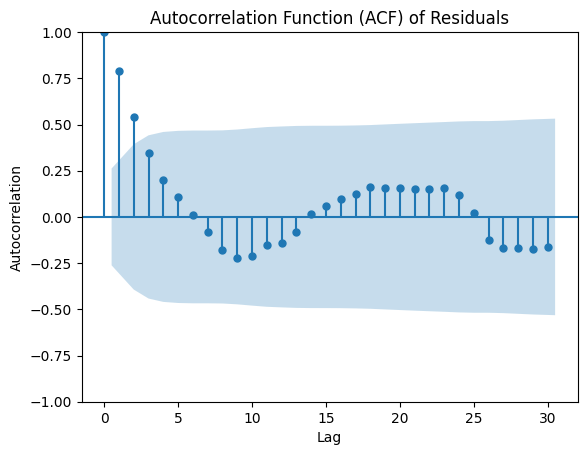

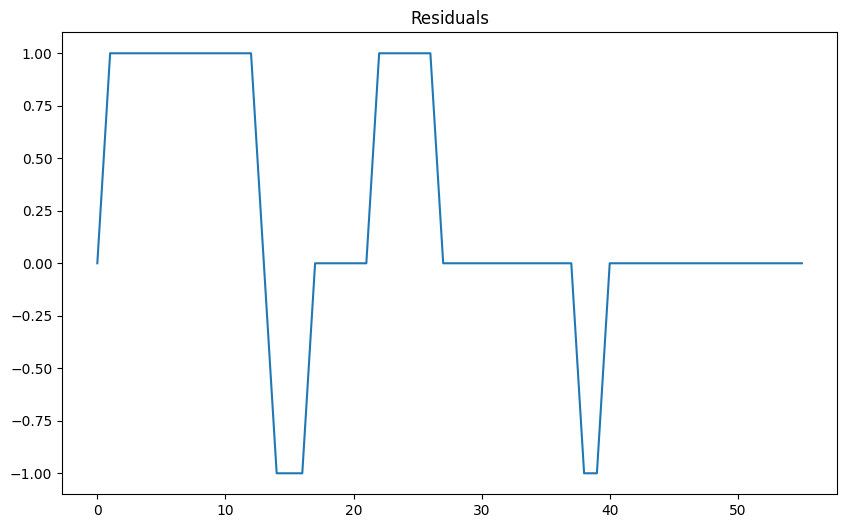


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 22.76, Preço real = 23.46, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 22.82, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 22.89, Preço real = 23.67, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 22.94, Preço real = 24.32, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 23.02, Preço real = 24.81, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 23.10, Preço real = 24.93, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 23.17, Preço real = 25.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 23.25, Preço real = 25.

In [ ]:
PRA_linear = datasil()

# Calcula as médias móveis
PRA_linear['MA_30'] = PRA_linear['Open'].rolling(window=30).mean().shift(1)

# Remove as linhas com valores ausentes resultantes dos cálculos das médias móveis
PRA_linear.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação à média móvel
PRA_linear['Category'] = (PRA_linear['Open'] > PRA_linear['MA_30']).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_linear[['Date', 'MA_30']].values
y = PRA_linear['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'MA_30' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'MA_30' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    ma_30_price = PRA_linear.iloc[train_size + i]['MA_30']
    actual_price = PRA_linear.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, ma_30_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed


Melhores parâmetros encontrados: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy: 0.5737704918032787
Confusion Matrix:
 [[20 15]
 [11 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61        35
           1       0.50      0.58      0.54        26

    accuracy                           0.57        61
   macro avg       0.57      0.57      0.57        61
weighted avg       0.58      0.57      0.58        61

Mean Squared Error (MSE): 0.4262295081967213
R-squared (R2): -0.7428571428571429
Root Mean Squared Error (RMSE): 0.652862549237373
Mean Absolute Error (MAE): 0.4262295081967213
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-67-06a041bab92d>:56: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-67-06a041bab92d>:56: RuntimeWarning:

invalid value encountered in divide



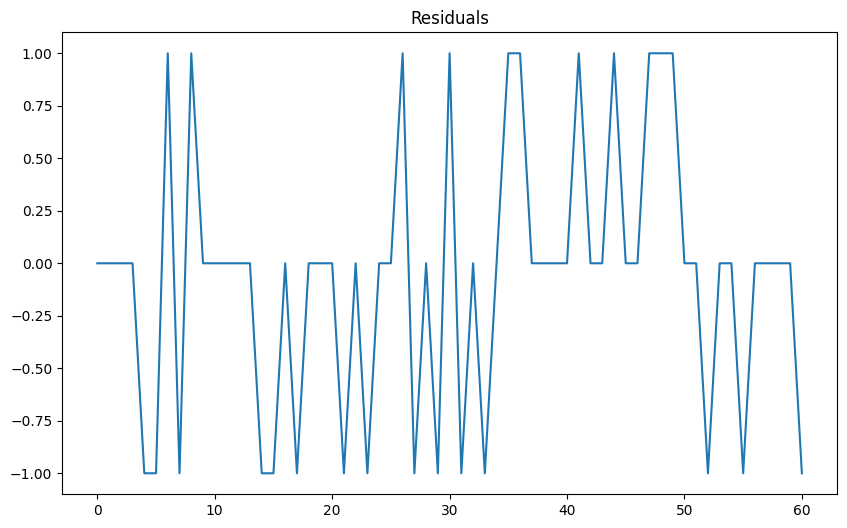


Resultados Previstos:
Data = 2023-11-13 00:00:00, RSI14 = 44.29, Preço real = 22.08, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, RSI14 = 54.61, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, RSI14 = 58.88, Preço real = 23.49, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, RSI14 = 62.67, Preço real = 23.58, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, RSI14 = 61.43, Preço real = 23.91, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-20 00:00:00, RSI14 = 57.99, Preço real = 23.46, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-21 00:00:00, RSI14 = 60.71, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, RSI14 = 58.09, Preço real = 23.67, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-1

In [ ]:
PRA_RSI14 = datasil()

# Calcula o RSI14
PRA_RSI14['RSI14'] = ta.momentum.rsi(PRA_RSI14['Close'], window=14)

# Remove as linhas com valores ausentes resultantes dos cálculos do RSI14
PRA_RSI14.dropna(inplace=True)

# Categorizando os preços em "alta" ou "baixa" em relação ao fechamento anterior
PRA_RSI14['Category'] = (PRA_RSI14['Close'] > PRA_RSI14['Close'].shift(1)).astype(int)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_RSI14[['Date', 'RSI14']].values
y = PRA_RSI14['Category'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define os parâmetros para a pesquisa em grade
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cria o modelo KNeighborsClassifier
model = KNeighborsClassifier()

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=5)

# Executa a pesquisa em grade
grid_search.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'RSI14' para previsão

# Obtém os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Faz previsões usando o melhor modelo encontrado pela pesquisa em grade
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test[:, 1:])  # Usando apenas a coluna 'RSI14' para previsão

# Avalia o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Avalia o desempenho do modelo com métricas de regressão usando os valores reais e previstos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test - y_pred

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:, 0], y_pred)):  # Adicionando a data ao loop
    rsi_14_value = PRA_RSI14.iloc[train_size + i]['RSI14']
    actual_price = PRA_RSI14.iloc[train_size + i]['Open']
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, RSI14 = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, rsi_14_value, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed


Melhores Parâmetros: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Acurácia: 0.46153846153846156
F1 Score: 0.6153846153846154
Recall: 0.9032258064516129
Precisão: 0.4666666666666667
Matriz de Confusão:
[[ 2 32]
 [ 3 28]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.40      0.06      0.10        34
           1       0.47      0.90      0.62        31

    accuracy                           0.46        65
   macro avg       0.43      0.48      0.36        65
weighted avg       0.43      0.46      0.35        65


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 22.77, Preço real = 22.77, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 22.33, Preço real = 22.33, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 22.52, Preço real = 22.52, Comportamento previsto = Desce, Comportamento real = 

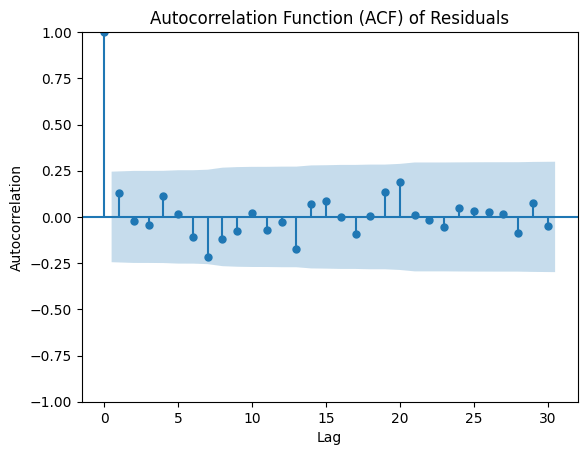

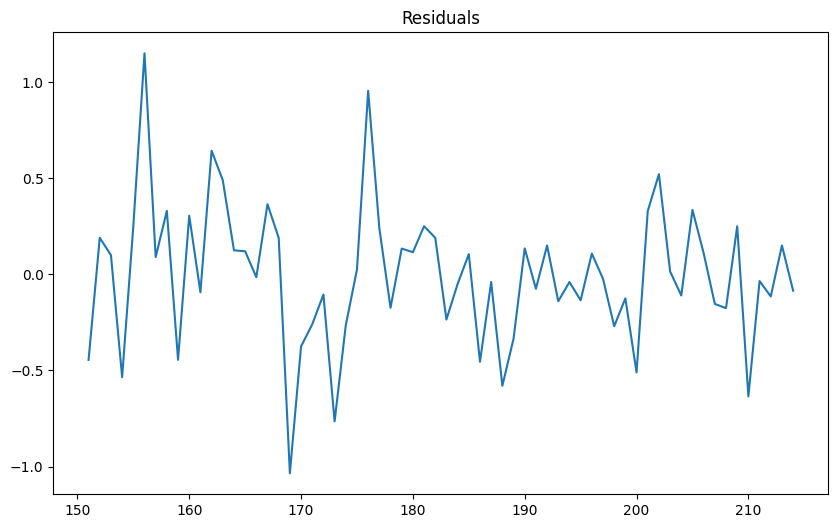

In [ ]:
PRA_obv = datasil()

# Cálculo do indicador OBV
PRA_obv['OBV'] = (np.sign(PRA_obv['Close'].diff()) * PRA_obv['Volume']).fillna(0).cumsum()

# Criando rótulos binários: 1 para "sobe", 0 para "desce"
PRA_obv['Target'] = np.where(PRA_obv['Open'].shift(-1) > PRA_obv['Open'], 1, 0)

# Remover valores NaN criados pelo cálculo do OBV e da coluna Target
PRA_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = PRA_obv[['Open', 'OBV']]
y = PRA_obv['Target']

#Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Treinamento do modelo com GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibição dos resultados
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
X_test_dates = PRA_obv.loc[X_test.index, 'Date']  # Obtendo as datas correspondentes ao X_test

for date, real_open, pred_label, real_label in zip(X_test_dates, X_test['Open'], y_pred, y_test):
    comportamento_previsto = comportamento_label(pred_label)
    comportamento_real = comportamento_label(real_label)
    print(f"Data = {date}, Preço previsto = {real_open:.2f}, Preço real = {real_open:.2f}, Comportamento previsto = {comportamento_previsto}, Comportamento real = {comportamento_real}")

# Cálculo das métricas de regressão para avaliar previsões
y_test_numeric = PRA_obv.loc[X_test.index, 'Open'].shift(-1)  # Valores reais de abertura do próximo dia
y_test_numeric.dropna(inplace=True)
y_pred_numeric = X_test['Open'].iloc[:len(y_test_numeric)].values  # Valores previstos (atuais)

mse = mean_squared_error(y_test_numeric, y_pred_numeric)
r2 = r2_score(y_test_numeric, y_pred_numeric)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_numeric, y_pred_numeric)
mape = np.mean(np.abs((y_test_numeric - y_pred_numeric) / y_test_numeric)) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_numeric - y_pred_numeric

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


## Naive Bayes

### Alibaba (BABA)

####Normal

[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5076923076923077
Confusion Matrix:
 [[ 8 28]
 [ 4 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.22      0.33        36
           1       0.47      0.86      0.61        29

    accuracy                           0.51        65
   macro avg       0.57      0.54      0.47        65
weighted avg       0.58      0.51      0.46        65

Mean Squared Error (MSE): 3.6392783402534405
R-squared (R2): 0.7975534954552567
Root Mean Squared Error (RMSE): 1.9076892672166084
Mean Absolute Error (MAE): 1.3123431205749512
Mean Absolute Percentage Error (MAPE): 1.748228037291722


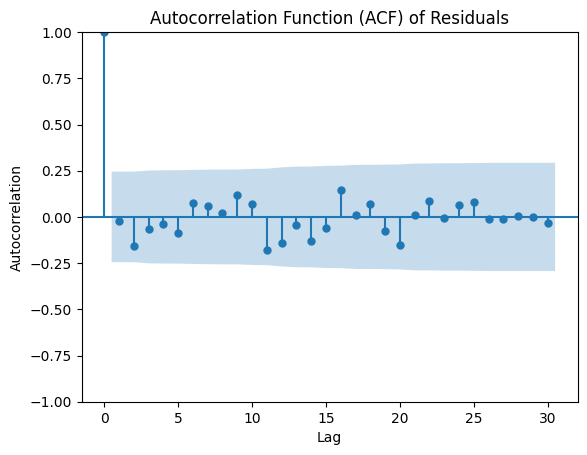

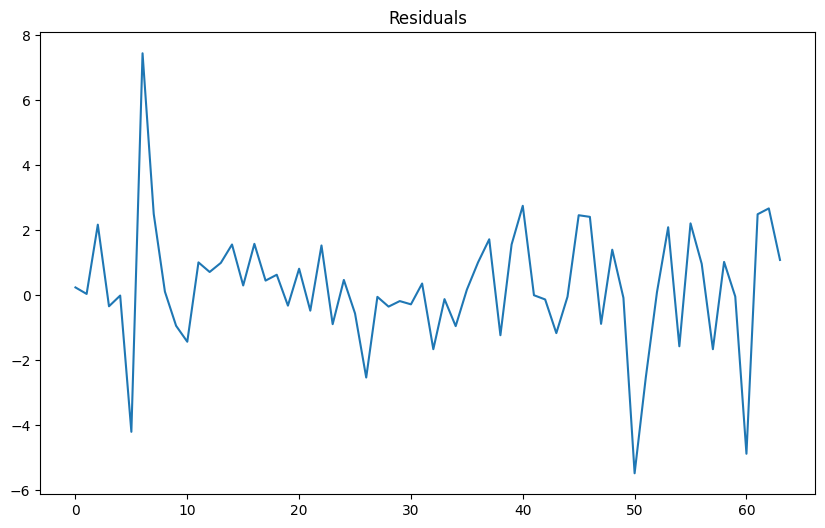


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 84.62, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 84.58, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 82.41, Preço real = 84.58, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-10 00:00:00, Preço previsto = 82.75, Preço real = 82.41, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 82.76, Preço real = 82.75, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 86.96, Preço real = 82.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 79.52, Preço real = 86.96, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 77.02, Preço real 

In [ ]:
BABA_normal = datababa()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_normal['Target'] = (BABA_normal['Open'].shift(-1) > BABA_normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
BABA_normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = BABA_normal[['Date', 'Open']].values
y = BABA_normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5964912280701754
Confusion Matrix:
 [[12 19]
 [ 4 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.39      0.51        31
           1       0.54      0.85      0.66        26

    accuracy                           0.60        57
   macro avg       0.64      0.62      0.58        57
weighted avg       0.65      0.60      0.58        57

Mean Squared Error (MSE): 2.6569002576652565
R-squared (R2): 0.6442344001875147
Root Mean Squared Error (RMSE): 1.6300000790384204
Mean Absolute Error (MAE): 1.1973208018711634
Mean Absolute Percentage Error (MAPE): 1.6391393072007352


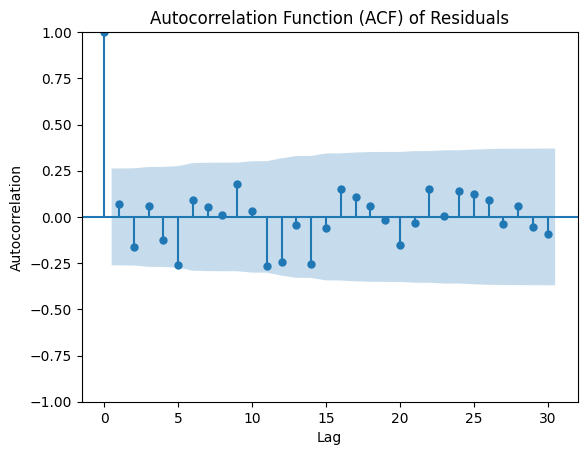

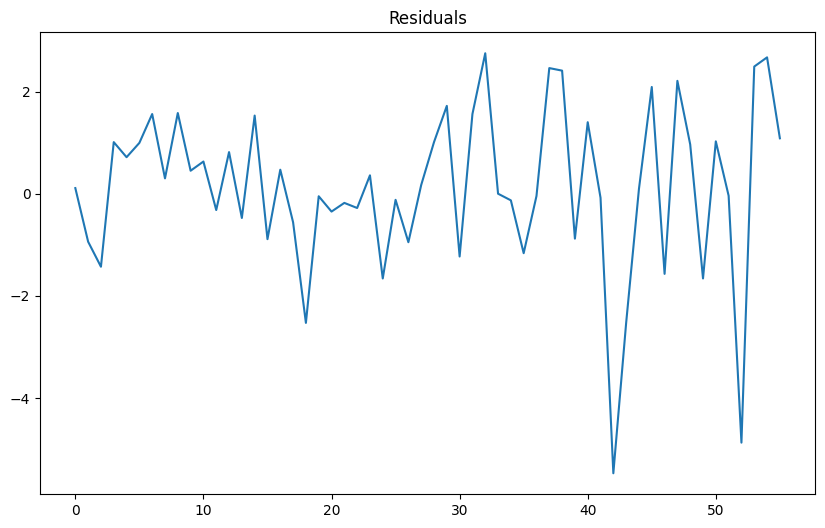


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 76.91, Preço real = 77.02, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 77.85, Preço real = 76.91, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 79.28, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 78.27, Preço real = 79.28, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-27 00:00:00, Preço previsto = 77.56, Preço real = 78.27, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-28 00:00:00, Preço previsto = 76.56, Preço real = 77.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-29 00:00:00, Preço previsto = 75.00, Preço real = 76.56, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-30 00:00:00, Preço previsto = 74.70, Preço real

In [ ]:
BABA_linear = datababa()

# Cálculo do indicador MA-30
BABA_linear['MA30'] = BABA_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_linear['Target'] = (BABA_linear['Open'].shift(-1) > BABA_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
BABA_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = BABA_linear[['Open', 'MA30']].values
y = BABA_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(BABA_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.47540983606557374
Confusion Matrix:
 [[ 4 29]
 [ 3 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.12      0.20        33
           1       0.46      0.89      0.61        28

    accuracy                           0.48        61
   macro avg       0.52      0.51      0.40        61
weighted avg       0.52      0.48      0.39        61

Mean Squared Error (MSE): 3.800502086089303
R-squared (R2): 0.706816876396736
Root Mean Squared Error (RMSE): 1.9494876470727645
Mean Absolute Error (MAE): 1.353332773844401
Mean Absolute Percentage Error (MAPE): 1.80963873265995


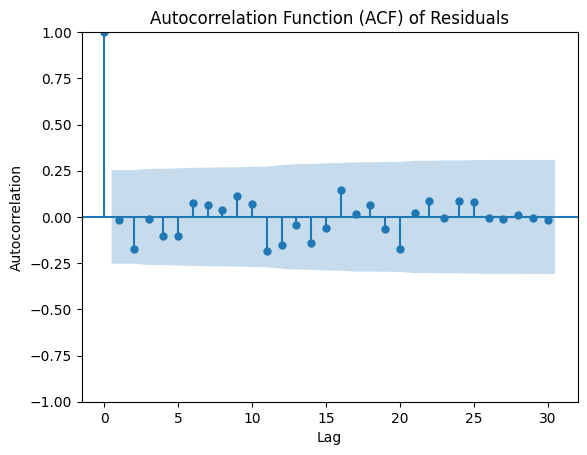

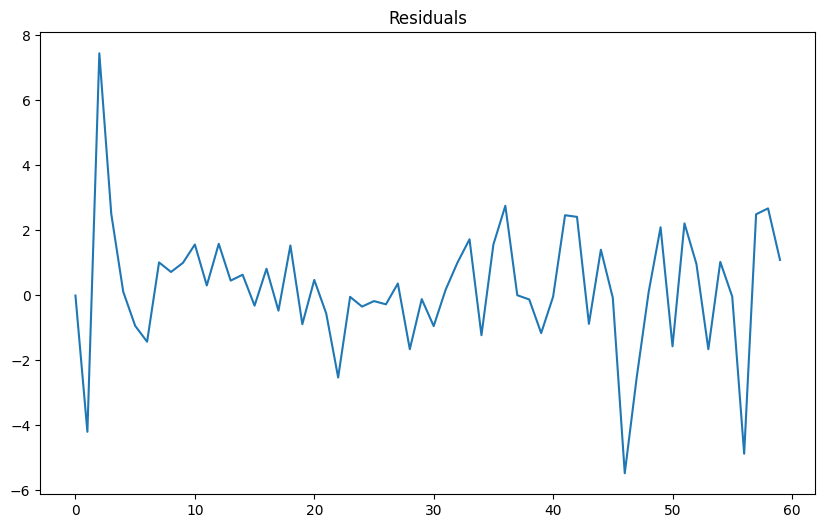


Resultados Previstos:
Data = 2023-11-14 00:00:00, Preço previsto = 82.76, Preço real = 82.75, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 86.96, Preço real = 82.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 79.52, Preço real = 86.96, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 77.02, Preço real = 79.52, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-20 00:00:00, Preço previsto = 76.91, Preço real = 77.02, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 77.85, Preço real = 76.91, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 79.28, Preço real = 77.85, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-24 00:00:00, Preço previsto = 78.27, Preço real = 7

In [ ]:
BABA_RSI14 = datababa()

# Cálculo do indicador RSI-14
delta = BABA_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
BABA_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_RSI14['Target'] = (BABA_RSI14['Open'].shift(-1) > BABA_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
BABA_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = BABA_RSI14[['Open', 'RSI14']].values
y = BABA_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(BABA_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5538461538461539
Confusion Matrix:
 [[36  0]
 [29  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        36
           1       0.00      0.00      0.00        29

    accuracy                           0.55        65
   macro avg       0.28      0.50      0.36        65
weighted avg       0.31      0.55      0.39        65

Mean Squared Error (MSE): 3.6392783402534405
R-squared (R2): 0.7975534954552567
Root Mean Squared Error (RMSE): 1.9076892672166084
Mean Absolute Error (MAE): 1.3123431205749512
Mean Absolute Percentage Error (MAPE): 1.7482280372917225



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



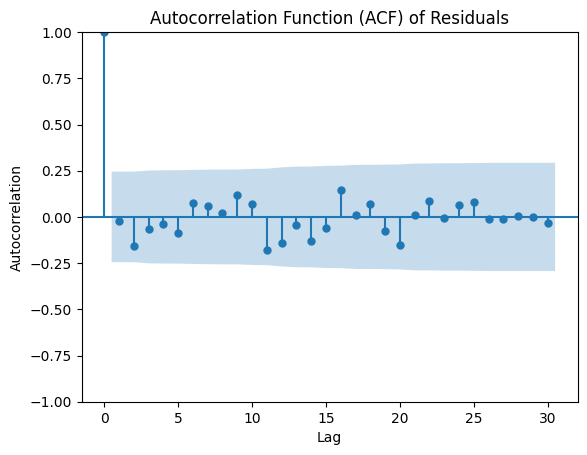

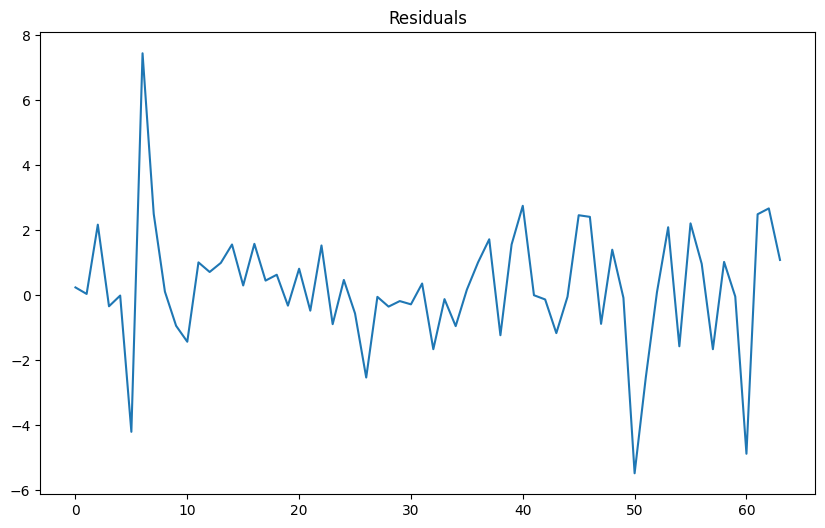


Resultados Previstos:
Data = 2023-11-08 00:00:00, Preço previsto = 84.62, Preço real = 84.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 84.58, Preço real = 84.62, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-10 00:00:00, Preço previsto = 82.41, Preço real = 84.58, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-13 00:00:00, Preço previsto = 82.75, Preço real = 82.41, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 82.76, Preço real = 82.75, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 86.96, Preço real = 82.76, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 79.52, Preço real = 86.96, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 77.02, Preço real 

In [ ]:
BABA_obv = datababa()

# Cálculo do indicador OBV
BABA_obv['OBV'] = (np.sign(BABA_obv['Close'].diff()) * BABA_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
BABA_obv['Target'] = (BABA_obv['Open'].shift(-1) > BABA_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
BABA_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = BABA_obv[['Open', 'OBV']].values
y = BABA_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(BABA_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


### Advanced Micro Devices, INC. (AMD)

####Normal

[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.4461538461538462
Confusion Matrix:
 [[25  0]
 [36  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      1.00      0.58        25
           1       1.00      0.10      0.18        40

    accuracy                           0.45        65
   macro avg       0.70      0.55      0.38        65
weighted avg       0.77      0.45      0.34        65

Mean Squared Error (MSE): 17.676029273059612
R-squared (R2): 0.959757525636354
Root Mean Squared Error (RMSE): 4.204287011261197
Mean Absolute Error (MAE): 3.086249828338623
Mean Absolute Percentage Error (MAPE): 2.082593246873206


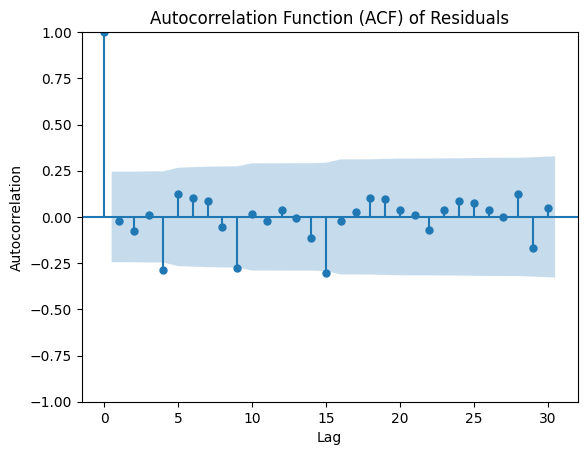

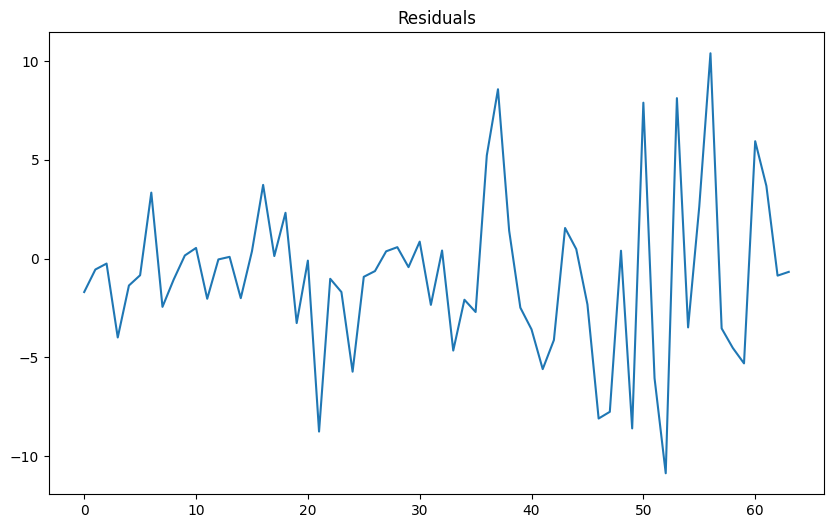


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 113.55, Preço real = 111.86, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 114.10, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.35, Preço real = 114.10, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 118.34, Preço real = 114.35, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 119.70, Preço real = 118.34, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 120.54, Preço real = 119.70, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 117.20, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 119.64, Pre

In [ ]:
AMD_Normal = dataamd()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_Normal['Target'] = (AMD_Normal['Open'].shift(-1) > AMD_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
AMD_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = AMD_Normal[['Date', 'Open']].values
y = AMD_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.40350877192982454
Confusion Matrix:
 [[23  1]
 [33  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.96      0.57        24
           1       0.00      0.00      0.00        33

    accuracy                           0.40        57
   macro avg       0.21      0.48      0.29        57
weighted avg       0.17      0.40      0.24        57

Mean Squared Error (MSE): 19.508218581528386
R-squared (R2): 0.9506961937334819
Root Mean Squared Error (RMSE): 4.416810906245408
Mean Absolute Error (MAE): 3.268928255353655
Mean Absolute Percentage Error (MAPE): 2.1585468310783247


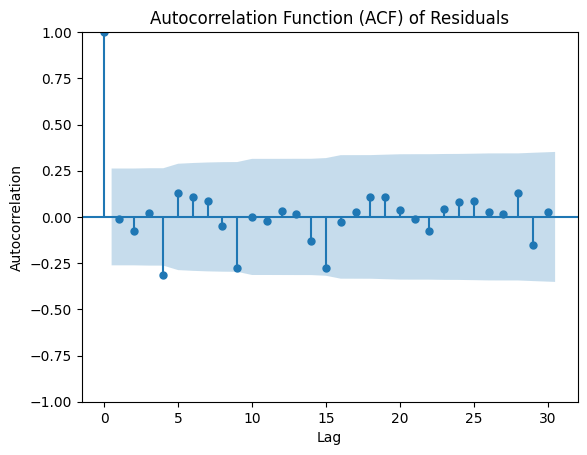

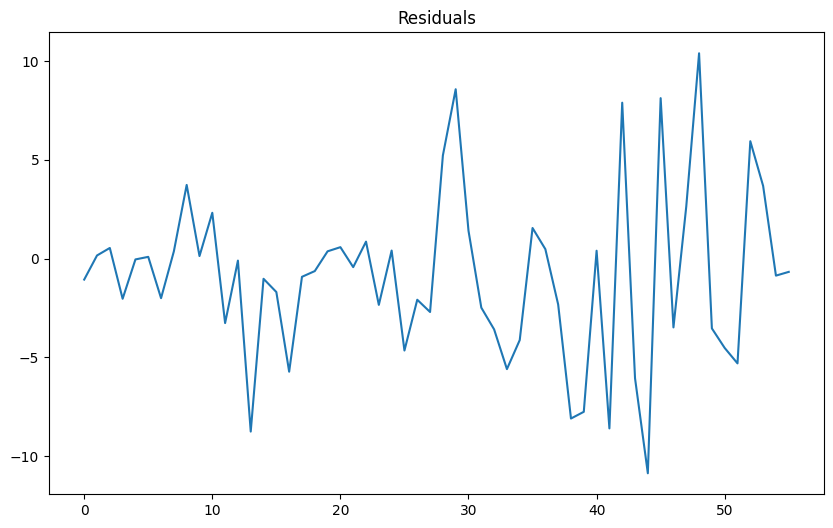


Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 120.70, Preço real = 119.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 120.54, Preço real = 120.70, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-22 00:00:00, Preço previsto = 120.00, Preço real = 120.54, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 122.03, Preço real = 120.00, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 122.07, Preço real = 122.03, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 121.98, Preço real = 122.07, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-29 00:00:00, Preço previsto = 123.98, Preço real = 121.98, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 123.6

In [ ]:
AMD_linear = dataamd()

# Cálculo do indicador MA-30
AMD_linear['MA30'] = AMD_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_linear['Target'] = (AMD_linear['Open'].shift(-1) > AMD_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
AMD_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = AMD_linear[['Open', 'MA30']].values
y = AMD_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(AMD_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.4426229508196721
Confusion Matrix:
 [[19  6]
 [28  8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.76      0.53        25
           1       0.57      0.22      0.32        36

    accuracy                           0.44        61
   macro avg       0.49      0.49      0.42        61
weighted avg       0.50      0.44      0.41        61

Mean Squared Error (MSE): 18.535411455105834
R-squared (R2): 0.9550417947245456
Root Mean Squared Error (RMSE): 4.305277163564018
Mean Absolute Error (MAE): 3.1839998881022136
Mean Absolute Percentage Error (MAPE): 2.1263732158805926


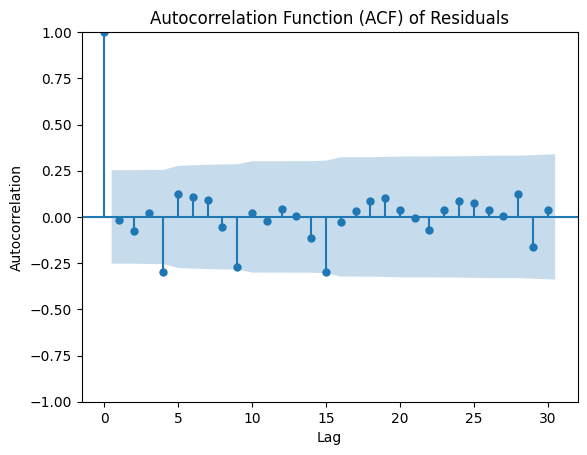


Resultados Previstos:
Data = 2023-11-14 00:00:00, Preço previsto = 119.70, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 120.54, Preço real = 119.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 117.20, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 119.64, Preço real = 117.20, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, Preço previsto = 120.70, Preço real = 119.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 120.54, Preço real = 120.70, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-22 00:00:00, Preço previsto = 120.00, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 122.03, Preç

In [ ]:
AMD_RSI14 = dataamd()

# Cálculo do indicador RSI-14
delta = AMD_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
AMD_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_RSI14['Target'] = (AMD_RSI14['Open'].shift(-1) > AMD_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
AMD_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = AMD_RSI14[['Open', 'RSI14']].values
y = AMD_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(AMD_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5384615384615384
Confusion Matrix:
 [[17  8]
 [22 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.68      0.53        25
           1       0.69      0.45      0.55        40

    accuracy                           0.54        65
   macro avg       0.56      0.57      0.54        65
weighted avg       0.59      0.54      0.54        65

Mean Squared Error (MSE): 17.676029273059612
R-squared (R2): 0.959757525636354
Root Mean Squared Error (RMSE): 4.204287011261197
Mean Absolute Error (MAE): 3.086249828338623
Mean Absolute Percentage Error (MAPE): 2.082593246873206


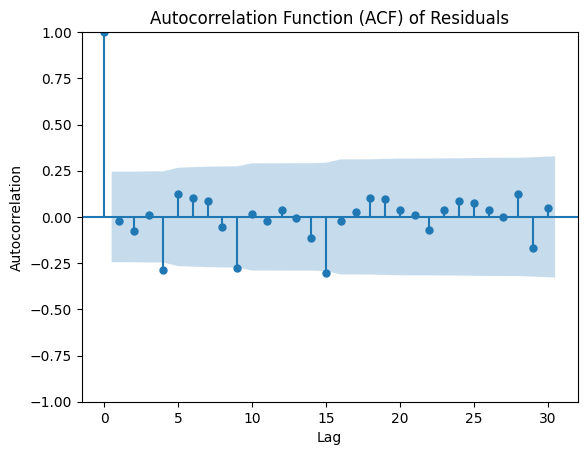

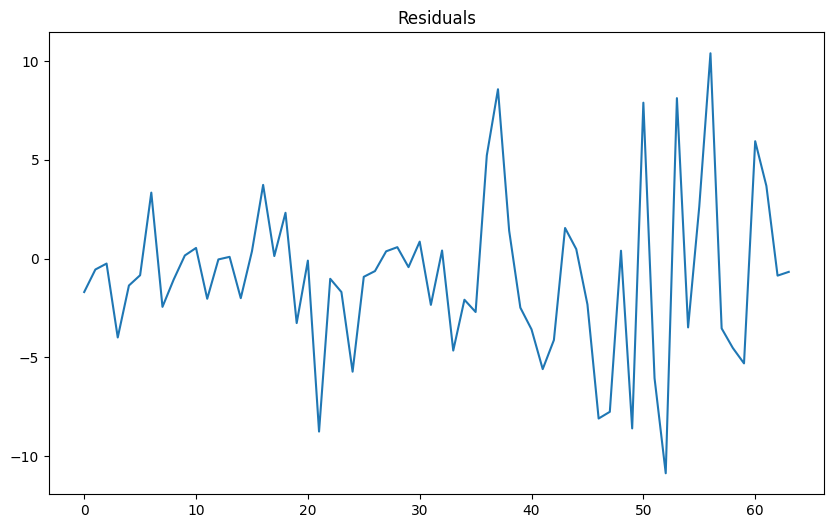


Resultados Previstos:
Data = 2023-11-08 00:00:00, Preço previsto = 113.55, Preço real = 111.86, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 114.10, Preço real = 113.55, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 114.35, Preço real = 114.10, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 118.34, Preço real = 114.35, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 119.70, Preço real = 118.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 120.54, Preço real = 119.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 117.20, Preço real = 120.54, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-17 00:00:00, Preço previsto = 119.64, Preço 

In [ ]:
AMD_obv = dataamd()

# Cálculo do indicador OBV
AMD_obv['OBV'] = (np.sign(AMD_obv['Close'].diff()) * AMD_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
AMD_obv['Target'] = (AMD_obv['Open'].shift(-1) > AMD_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
AMD_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = AMD_obv[['Open', 'OBV']].values
y = AMD_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(AMD_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


### Monero em Dolar (XMR-USD)

####Normal

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5181818181818182
Confusion Matrix:
 [[47  6]
 [47 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.89      0.64        53
           1       0.62      0.18      0.27        57

    accuracy                           0.52       110
   macro avg       0.56      0.53      0.46       110
weighted avg       0.56      0.52      0.45       110

Mean Squared Error (MSE): 52.48280260750998
R-squared (R2): 0.4745770636338078
Root Mean Squared Error (RMSE): 7.244501543067679
Mean Absolute Error (MAE): 3.4309758177591028
Mean Absolute Percentage Error (MAPE): 2.174353650566502


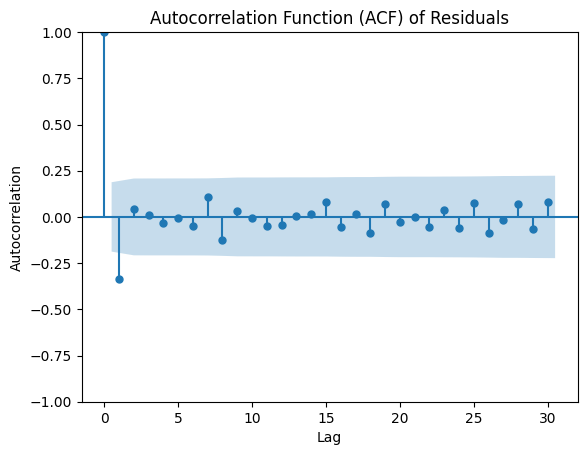

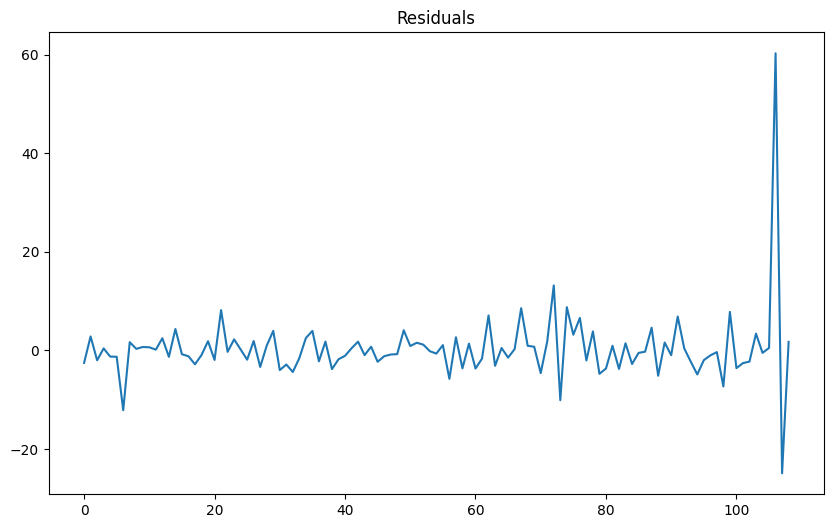


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 160.88, Preço real = 158.34, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 158.05, Preço real = 160.88, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-25 00:00:00, Preço previsto = 160.05, Preço real = 158.05, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-26 00:00:00, Preço previsto = 159.65, Preço real = 160.05, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-10-27 00:00:00, Preço previsto = 160.90, Preço real = 159.65, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, Preço previsto = 162.19, Preço real = 160.90, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 174.32, Preço real = 162.19, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 172.65

In [ ]:
XMR_Normal = dataxmr()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_Normal['Target'] = (XMR_Normal['Open'].shift(-1) > XMR_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
XMR_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = XMR_Normal[['Date', 'Open']].values
y = XMR_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

In [ ]:
XMR_linear = dataxmr()

# Cálculo do indicador MA-30
XMR_linear['MA30'] = XMR_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_linear['Target'] = (XMR_linear['Open'].shift(-1) > XMR_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
XMR_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = XMR_linear[['Open', 'MA30']].values
y = XMR_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(XMR_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.504950495049505
Confusion Matrix:
 [[45  4]
 [46  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.92      0.64        49
           1       0.60      0.12      0.19        52

    accuracy                           0.50       101
   macro avg       0.55      0.52      0.42       101
weighted avg       0.55      0.50      0.41       101

Mean Squared Error (MSE): 55.486406616196035
R-squared (R2): 0.4755388489719238
Root Mean Squared Error (RMSE): 7.4489198288205545
Mean Absolute Error (MAE): 3.4953857421875
Mean Absolute Percentage Error (MAPE): 2.2191407519039767



Resultados Previstos:
Data = 2023-11-02 00:00:00, Preço previsto = 171.64, Preço real = 172.34, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-03 00:00:00, Preço previsto = 171.01, Preço real = 171.64, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-04 00:00:00, Preço previsto = 170.86, Preço real = 171.01, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-05 00:00:00, Preço previsto = 168.39, Preço real = 170.86, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-06 00:00:00, Preço previsto = 169.69, Preço real = 168.39, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 165.35, Preço real = 169.69, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 166.13, Preço real = 165.35, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 167

####RSI14

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5471698113207547
Confusion Matrix:
 [[38 13]
 [35 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.75      0.61        51
           1       0.61      0.36      0.45        55

    accuracy                           0.55       106
   macro avg       0.56      0.55      0.53       106
weighted avg       0.56      0.55      0.53       106

Mean Squared Error (MSE): 54.30457766230795
R-squared (R2): 0.4715201952814291
Root Mean Squared Error (RMSE): 7.369163973091381
Mean Absolute Error (MAE): 3.4876348586309525
Mean Absolute Percentage Error (MAPE): 2.2106963798815293


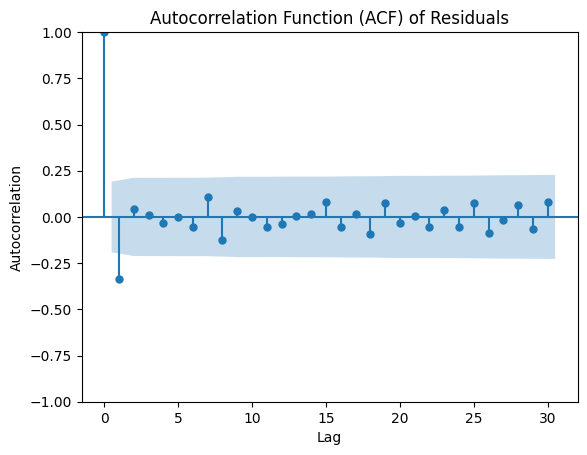

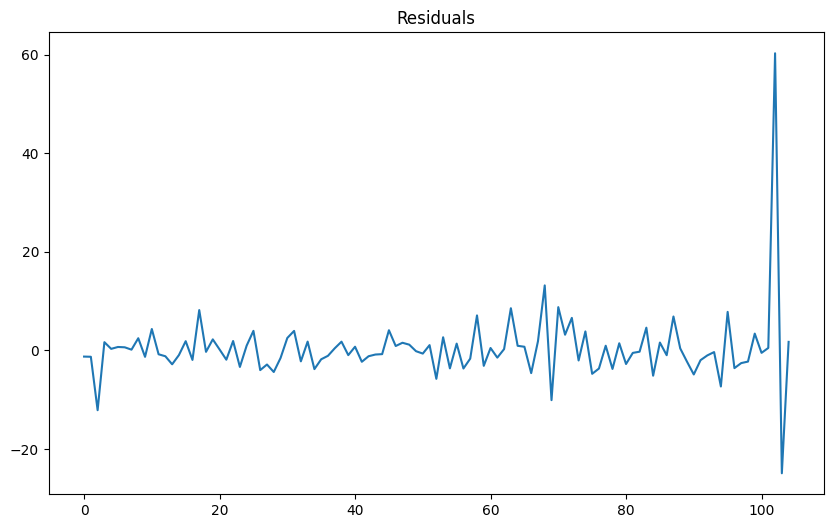


Resultados Previstos:
Data = 2023-10-28 00:00:00, Preço previsto = 160.90, Preço real = 159.65, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 162.19, Preço real = 160.90, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 174.32, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 172.65, Preço real = 174.32, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-01 00:00:00, Preço previsto = 172.34, Preço real = 172.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-02 00:00:00, Preço previsto = 171.64, Preço real = 172.34, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-03 00:00:00, Preço previsto = 171.01, Preço real = 171.64, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-04 00:00:00, Preço previsto = 170.86, Pre

In [ ]:
XMR_RSI14 = dataxmr()

# Cálculo do indicador RSI-14
delta = XMR_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
XMR_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_RSI14['Target'] = (XMR_RSI14['Open'].shift(-1) > XMR_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
XMR_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = XMR_RSI14[['Open', 'RSI14']].values
y = XMR_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(XMR_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5181818181818182
Confusion Matrix:
 [[ 0 53]
 [ 0 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.52      1.00      0.68        57

    accuracy                           0.52       110
   macro avg       0.26      0.50      0.34       110
weighted avg       0.27      0.52      0.35       110

Mean Squared Error (MSE): 52.48280260750998
R-squared (R2): 0.4745770636338078
Root Mean Squared Error (RMSE): 7.244501543067679
Mean Absolute Error (MAE): 3.4309758177591028
Mean Absolute Percentage Error (MAPE): 2.174353650566502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



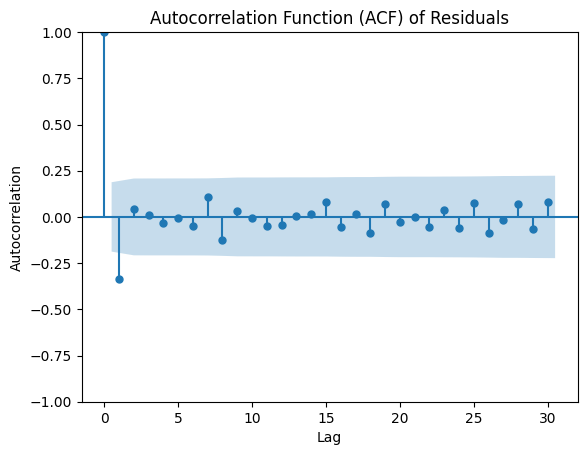

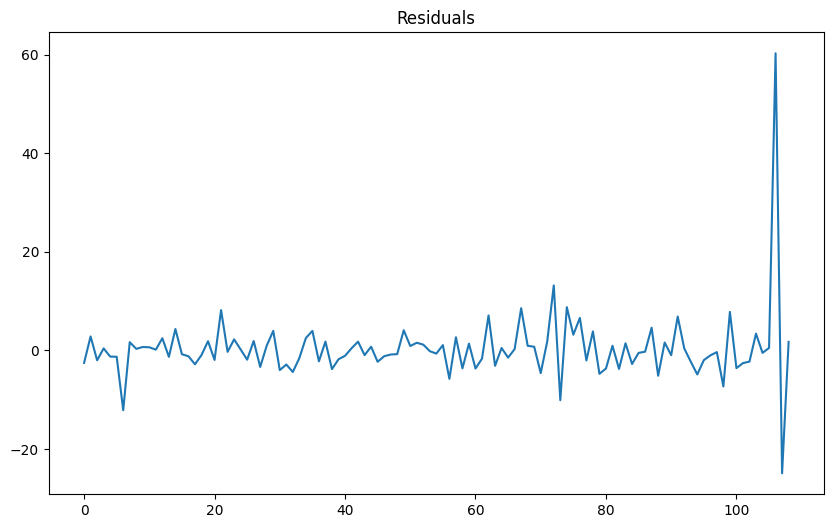


Resultados Previstos:
Data = 2023-10-24 00:00:00, Preço previsto = 160.88, Preço real = 158.34, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 158.05, Preço real = 160.88, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-26 00:00:00, Preço previsto = 160.05, Preço real = 158.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-27 00:00:00, Preço previsto = 159.65, Preço real = 160.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-28 00:00:00, Preço previsto = 160.90, Preço real = 159.65, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 162.19, Preço real = 160.90, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 174.32, Preço real = 162.19, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 172.65, Preço

In [ ]:
XMR_obv = dataxmr()

# Cálculo do indicador OBV
XMR_obv['OBV'] = (np.sign(XMR_obv['Close'].diff()) * XMR_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
XMR_obv['Target'] = (XMR_obv['Open'].shift(-1) > XMR_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
XMR_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = XMR_obv[['Open', 'OBV']].values
y = XMR_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(XMR_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


### Litecoin em Dolar (LTC-USD)

####Normal

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Accuracy: 0.5272727272727272
Confusion Matrix:
 [[ 0 52]
 [ 0 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.53      1.00      0.69        58

    accuracy                           0.53       110
   macro avg       0.26      0.50      0.35       110
weighted avg       0.28      0.53      0.36       110

Mean Squared Error (MSE): 3.1684809369035065
R-squared (R2): 0.6138320155174288
Root Mean Squared Error (RMSE): 1.7800227349400644
Mean Absolute Error (MAE): 1.304996455481293
Mean Absolute Percentage Error (MAPE): 1.8429847761583735


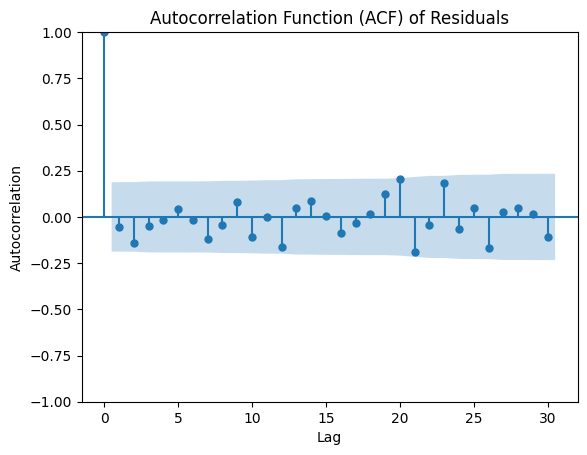

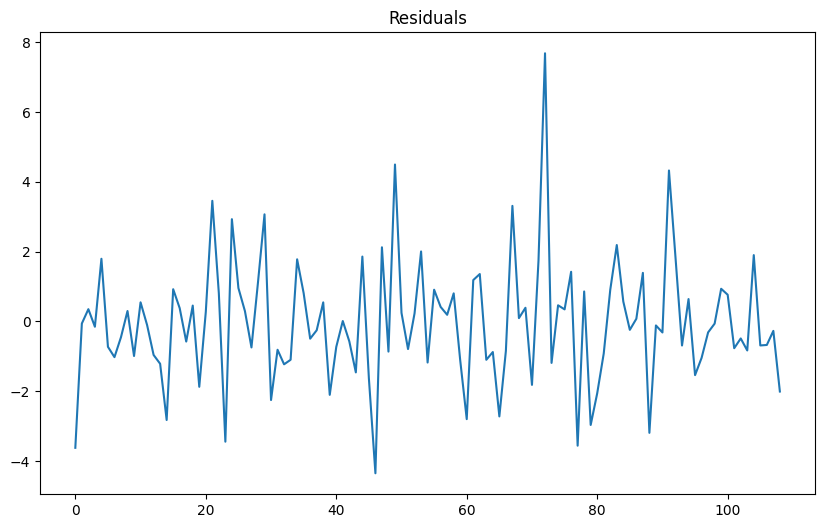


Resultados Previstos:
Data = 2023-10-23 00:00:00, Preço previsto = 68.99, Preço real = 65.37, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-24 00:00:00, Preço previsto = 69.05, Preço real = 68.99, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 68.70, Preço real = 69.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-26 00:00:00, Preço previsto = 68.85, Preço real = 68.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-27 00:00:00, Preço previsto = 67.05, Preço real = 68.85, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-28 00:00:00, Preço previsto = 67.78, Preço real = 67.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-29 00:00:00, Preço previsto = 68.80, Preço real = 67.78, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 69.25, Preço real = 68.80, 

In [ ]:
LTC_Normal = dataltc()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_Normal['Target'] = (LTC_Normal['Open'].shift(-1) > LTC_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
LTC_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = LTC_Normal[['Date', 'Open']].values
y = LTC_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Accuracy: 0.5148514851485149
Confusion Matrix:
 [[ 0 49]
 [ 0 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.51      1.00      0.68        52

    accuracy                           0.51       101
   macro avg       0.26      0.50      0.34       101
weighted avg       0.27      0.51      0.35       101

Mean Squared Error (MSE): 3.2702028727537256
R-squared (R2): 0.6061454140811324
Root Mean Squared Error (RMSE): 1.8083702255770873
Mean Absolute Error (MAE): 1.3376898956298828
Mean Absolute Percentage Error (MAPE): 1.88246726691771


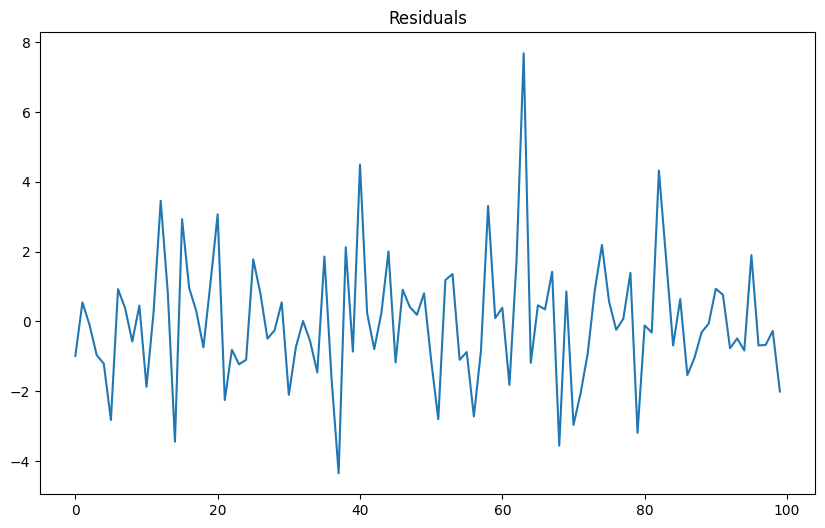


Resultados Previstos:
Data = 2023-11-02 00:00:00, Preço previsto = 69.94, Preço real = 68.95, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 69.39, Preço real = 69.94, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-04 00:00:00, Preço previsto = 69.49, Preço real = 69.39, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-05 00:00:00, Preço previsto = 70.45, Preço real = 69.49, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-06 00:00:00, Preço previsto = 71.66, Preço real = 70.45, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-07 00:00:00, Preço previsto = 74.49, Preço real = 71.66, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-08 00:00:00, Preço previsto = 73.56, Preço real = 74.49, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 73.18, Preço real = 73.56, 

In [ ]:
LTC_linear = dataltc()

# Cálculo do indicador MA-30
LTC_linear['MA30'] = LTC_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_linear['Target'] = (LTC_linear['Open'].shift(-1) > LTC_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
LTC_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = LTC_linear[['Open', 'MA30']].values
y = LTC_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(LTC_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5283018867924528
Confusion Matrix:
 [[ 1 50]
 [ 0 55]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04        51
           1       0.52      1.00      0.69        55

    accuracy                           0.53       106
   macro avg       0.76      0.51      0.36       106
weighted avg       0.75      0.53      0.38       106

Mean Squared Error (MSE): 3.1629652626346796
R-squared (R2): 0.6137210598710461
Root Mean Squared Error (RMSE): 1.7784727331715489
Mean Absolute Error (MAE): 1.3148856026785714
Mean Absolute Percentage Error (MAPE): 1.8526974161879581


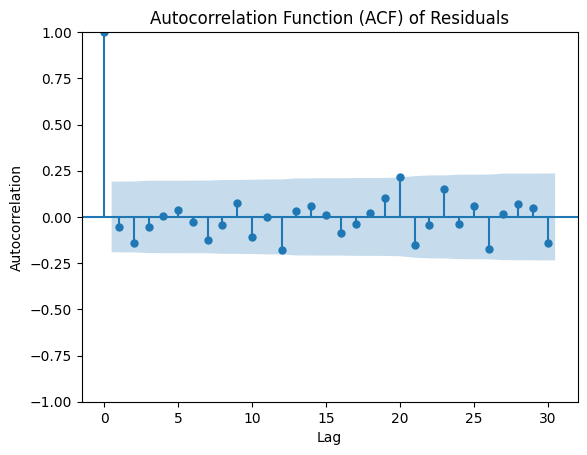

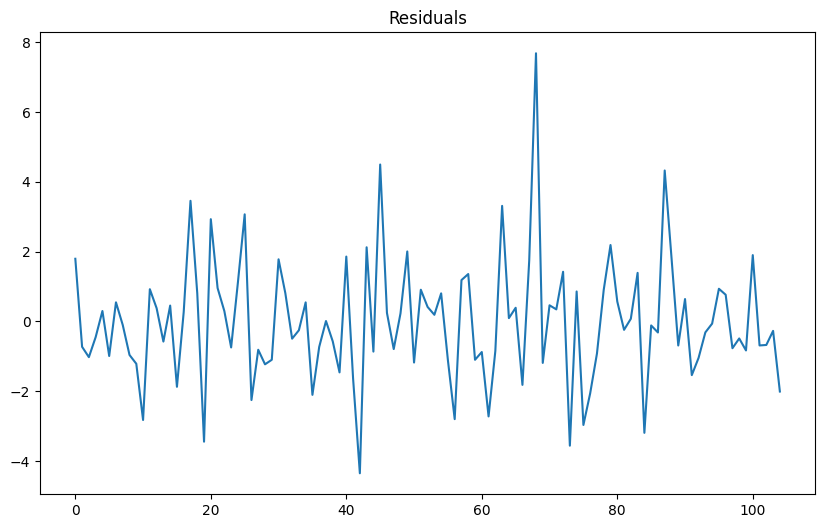


Resultados Previstos:
Data = 2023-10-28 00:00:00, Preço previsto = 67.05, Preço real = 68.85, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-29 00:00:00, Preço previsto = 67.78, Preço real = 67.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 68.80, Preço real = 67.78, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 69.25, Preço real = 68.80, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-01 00:00:00, Preço previsto = 68.95, Preço real = 69.25, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-02 00:00:00, Preço previsto = 69.94, Preço real = 68.95, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-03 00:00:00, Preço previsto = 69.39, Preço real = 69.94, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-04 00:00:00, Preço previsto = 69.49, Preço real = 69.39,

In [ ]:
LTC_RSI14 = dataltc()

# Cálculo do indicador RSI-14
delta = LTC_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
LTC_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_RSI14['Target'] = (LTC_RSI14['Open'].shift(-1) > LTC_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
LTC_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = LTC_RSI14[['Open', 'RSI14']].values
y = LTC_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(LTC_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5272727272727272
Confusion Matrix:
 [[ 0 52]
 [ 0 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.53      1.00      0.69        58

    accuracy                           0.53       110
   macro avg       0.26      0.50      0.35       110
weighted avg       0.28      0.53      0.36       110

Mean Squared Error (MSE): 3.1684809369035065
R-squared (R2): 0.6138320155174288
Root Mean Squared Error (RMSE): 1.7800227349400644
Mean Absolute Error (MAE): 1.304996455481293
Mean Absolute Percentage Error (MAPE): 1.8429847761583729



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



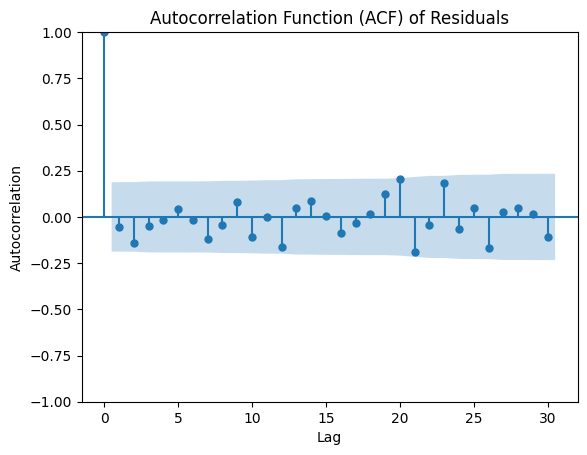

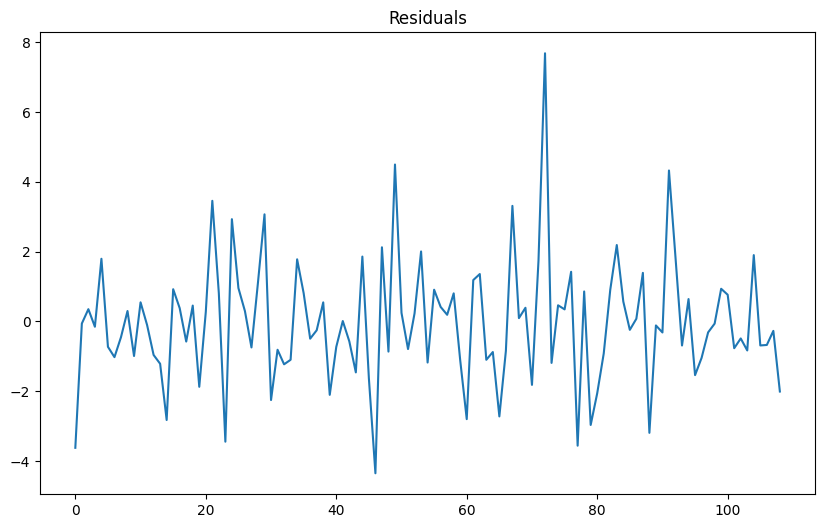


Resultados Previstos:
Data = 2023-10-24 00:00:00, Preço previsto = 68.99, Preço real = 65.37, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-25 00:00:00, Preço previsto = 69.05, Preço real = 68.99, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-26 00:00:00, Preço previsto = 68.70, Preço real = 69.05, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-27 00:00:00, Preço previsto = 68.85, Preço real = 68.70, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-28 00:00:00, Preço previsto = 67.05, Preço real = 68.85, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-10-29 00:00:00, Preço previsto = 67.78, Preço real = 67.05, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-30 00:00:00, Preço previsto = 68.80, Preço real = 67.78, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-10-31 00:00:00, Preço previsto = 69.25, Preço real = 68.80, 

In [ ]:
LTC_obv = dataltc()

# Cálculo do indicador OBV
LTC_obv['OBV'] = (np.sign(LTC_obv['Close'].diff()) * LTC_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
LTC_obv['Target'] = (LTC_obv['Open'].shift(-1) > LTC_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
LTC_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = LTC_obv[['Open', 'OBV']].values
y = LTC_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(LTC_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


###Cobre americano em USD (HG=F)

####Normal

[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5909090909090909
Confusion Matrix:
 [[27 10]
 [17 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67        37
           1       0.55      0.41      0.47        29

    accuracy                           0.59        66
   macro avg       0.58      0.57      0.57        66
weighted avg       0.58      0.59      0.58        66

Mean Squared Error (MSE): 0.0012579368009517987
R-squared (R2): 0.7967056442402758
Root Mean Squared Error (RMSE): 0.035467404767642624
Mean Absolute Error (MAE): 0.02799999530498798
Mean Absolute Percentage Error (MAPE): 0.7376924216574793


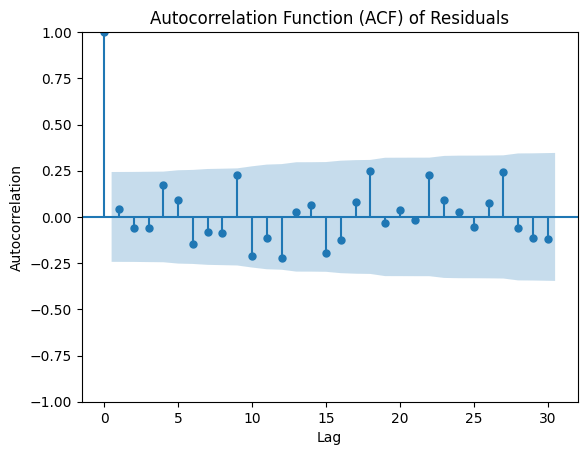

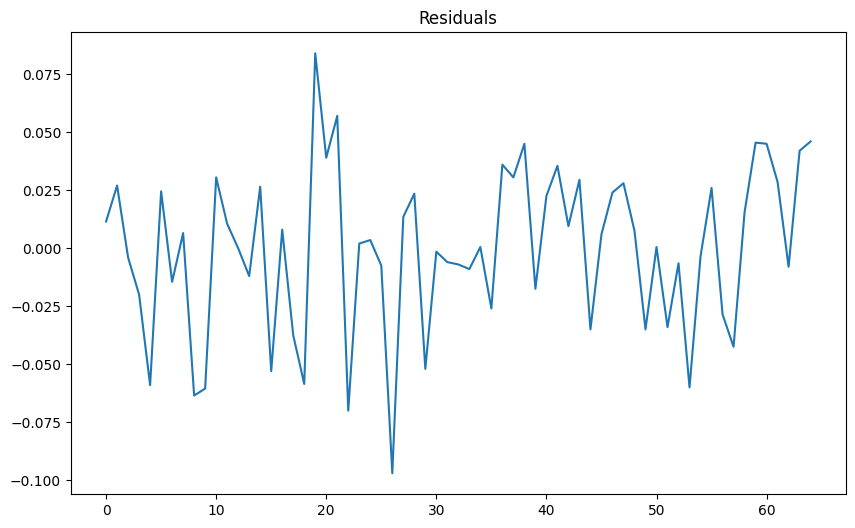


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 3.65, Preço real = 3.66, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 3.62, Preço real = 3.65, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 3.62, Preço real = 3.62, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 3.64, Preço real = 3.62, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 3.70, Preço real = 3.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 3.68, Preço real = 3.70, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-15 00:00:00, Preço previsto = 3.69, Preço real = 3.68, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 3.69, Preço real = 3.69, Comportamento p

In [ ]:
COB_Normal = datacob()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
COB_Normal['Target'] = (COB_Normal['Open'].shift(-1) > COB_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
COB_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = COB_Normal[['Date', 'Open']].values
y = COB_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5789473684210527
Confusion Matrix:
 [[29  4]
 [20  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.88      0.71        33
           1       0.50      0.17      0.25        24

    accuracy                           0.58        57
   macro avg       0.55      0.52      0.48        57
weighted avg       0.55      0.58      0.51        57

Mean Squared Error (MSE): 0.0012879041185809928
R-squared (R2): 0.6325077829539685
Root Mean Squared Error (RMSE): 0.03588738104934648
Mean Absolute Error (MAE): 0.028383914913449968
Mean Absolute Percentage Error (MAPE): 0.7439202250736794


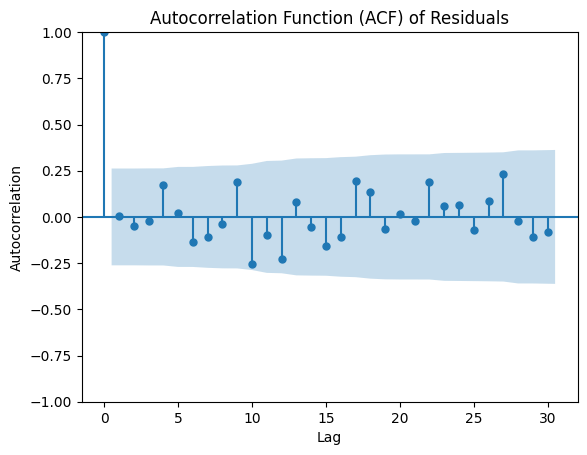

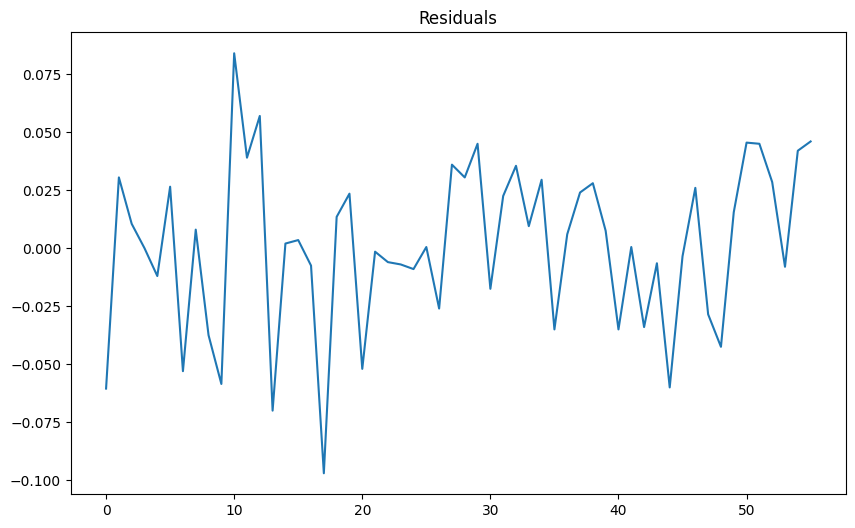


Resultados Previstos:
Data = 2023-11-21 00:00:00, Preço previsto = 3.81, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 3.78, Preço real = 3.81, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-23 00:00:00, Preço previsto = 3.77, Preço real = 3.78, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 3.77, Preço real = 3.77, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-27 00:00:00, Preço previsto = 3.78, Preço real = 3.77, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 3.76, Preço real = 3.78, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-29 00:00:00, Preço previsto = 3.81, Preço real = 3.76, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 3.80, Preço real = 3.81, Comportamento 

In [ ]:
COB_linear = datacob()

# Cálculo do indicador MA-30
COB_linear['MA30'] = COB_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
COB_linear['Target'] = (COB_linear['Open'].shift(-1) > COB_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
COB_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = COB_linear[['Open', 'MA30']].values
y = COB_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(COB_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####RSI14

In [ ]:
COB_RSI14 = datacob()

# Cálculo do indicador RSI-14
delta = COB_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
COB_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
COB_RSI14['Target'] = (COB_RSI14['Open'].shift(-1) > COB_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
COB_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = COB_RSI14[['Open', 'RSI14']].values
y = COB_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(COB_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5967741935483871
Confusion Matrix:
 [[29  6]
 [19  8]]


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70        35
           1       0.57      0.30      0.39        27

    accuracy                           0.60        62
   macro avg       0.59      0.56      0.54        62
weighted avg       0.59      0.60      0.56        62

Mean Squared Error (MSE): 0.0013194858008615318
R-squared (R2): 0.7216189155199524
Root Mean Squared Error (RMSE): 0.03632472712714484
Mean Absolute Error (MAE): 0.02881146649845311
Mean Absolute Percentage Error (MAPE): 0.7579173152235902



Resultados Previstos:
Data = 2023-11-14 00:00:00, Preço previsto = 3.70, Preço real = 3.64, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 3.68, Preço real = 3.70, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 3.69, Preço real = 3.68, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 3.69, Preço real = 3.69, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-20 00:00:00, Preço previsto = 3.75, Preço real = 3.69, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-21 00:00:00, Preço previsto = 3.81, Preço real = 3.75, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 3.78, Preço real = 3.81, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-23 00:00:00, Preço previsto = 3.77, Preço real = 3.78, Comportamento 

####OBV

[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5909090909090909
Confusion Matrix:
 [[37  0]
 [27  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73        37
           1       1.00      0.07      0.13        29

    accuracy                           0.59        66
   macro avg       0.79      0.53      0.43        66
weighted avg       0.76      0.59      0.47        66

Mean Squared Error (MSE): 0.0012579368009517987
R-squared (R2): 0.7967056442402758
Root Mean Squared Error (RMSE): 0.035467404767642624
Mean Absolute Error (MAE): 0.02799999530498798
Mean Absolute Percentage Error (MAPE): 0.7376924216574794


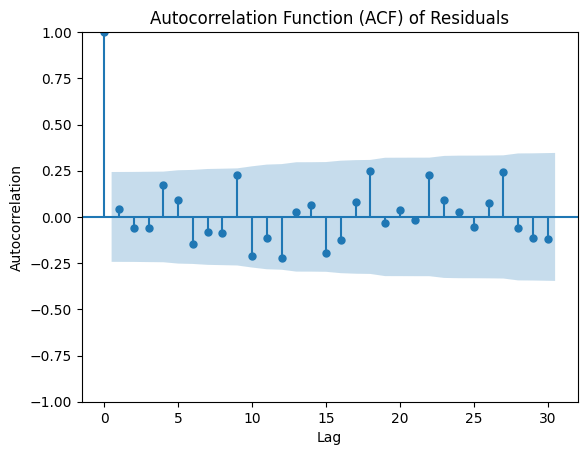

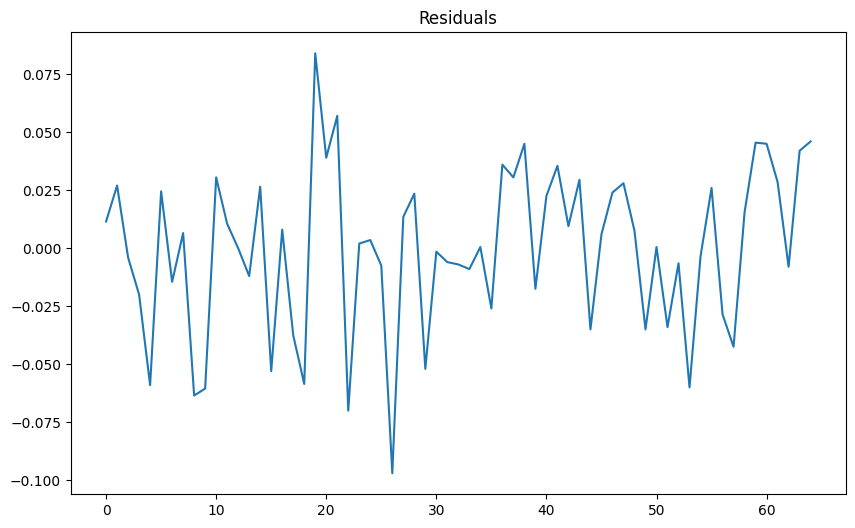


Resultados Previstos:
Data = 2023-11-08 00:00:00, Preço previsto = 3.65, Preço real = 3.66, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 3.62, Preço real = 3.65, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-10 00:00:00, Preço previsto = 3.62, Preço real = 3.62, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 3.64, Preço real = 3.62, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 3.70, Preço real = 3.64, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 3.68, Preço real = 3.70, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-16 00:00:00, Preço previsto = 3.69, Preço real = 3.68, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 3.69, Preço real = 3.69, Comportame

In [ ]:
COB_obv = datacob()

# Cálculo do indicador OBV
COB_obv['OBV'] = (np.sign(COB_obv['Close'].diff()) * COB_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
COB_obv['Target'] = (COB_obv['Open'].shift(-1) > COB_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
COB_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = COB_obv[['Open', 'OBV']].values
y = COB_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(COB_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


###Prata americano em USD (SI=F)

####Normal

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.46153846153846156
Confusion Matrix:
 [[14 20]
 [15 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.41      0.44        34
           1       0.44      0.52      0.48        31

    accuracy                           0.46        65
   macro avg       0.46      0.46      0.46        65
weighted avg       0.46      0.46      0.46        65

Mean Squared Error (MSE): 0.13304575683116582
R-squared (R2): 0.8174880698164638
Root Mean Squared Error (RMSE): 0.3647543787690092
Mean Absolute Error (MAE): 0.2703125476837158
Mean Absolute Percentage Error (MAPE): 1.1542020483732567


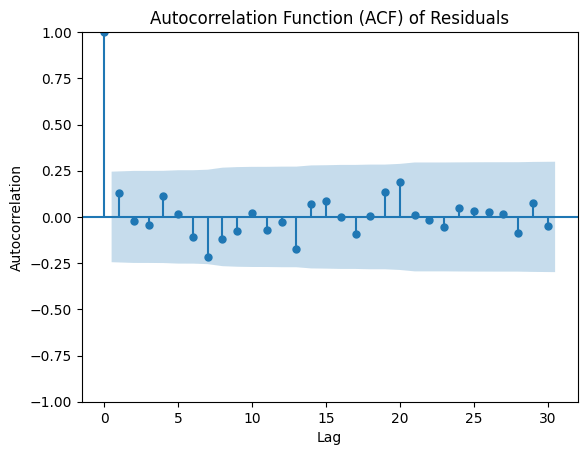

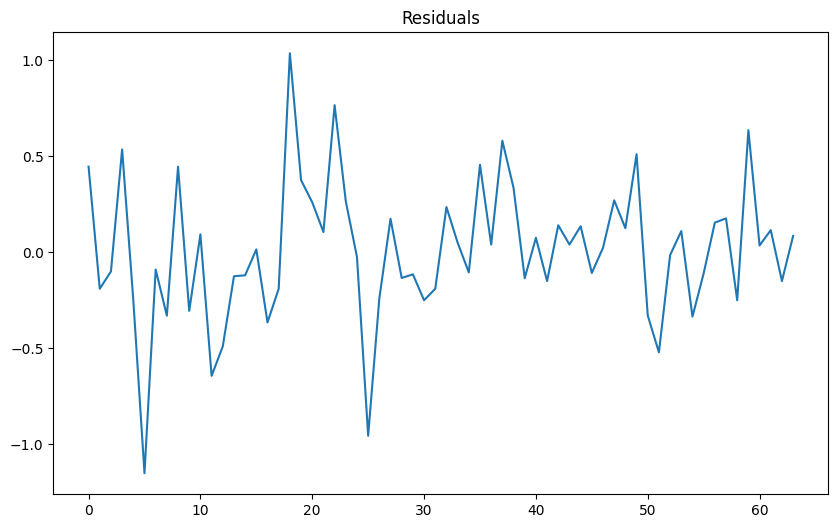


Resultados Previstos:
Data = 2023-11-07 00:00:00, Preço previsto = 22.33, Preço real = 22.77, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-08 00:00:00, Preço previsto = 22.52, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-09 00:00:00, Preço previsto = 22.62, Preço real = 22.52, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 22.08, Preço real = 22.62, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-13 00:00:00, Preço previsto = 22.33, Preço real = 22.08, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-14 00:00:00, Preço previsto = 23.49, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 23.58, Preço real = 23.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 23.91, Preço real = 23.58,

In [ ]:
PRA_Normal = datasil()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
PRA_Normal['Target'] = (PRA_Normal['Open'].shift(-1) > PRA_Normal['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do shift
PRA_Normal.dropna(inplace=True)

# Agora você pode acessar 'Date' como uma coluna
X = PRA_Normal[['Date', 'Open']].values
y = PRA_Normal['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train[:, 1:], y_train)  # Usando apenas a coluna 'Open' para previsão

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test[:, 1:])  # Usando apenas a coluna 'Open' para previsão

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 1]
y_pred_prices = X_test[:, 1].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(X_test[:-1, 0], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 1]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####MA-30

In [ ]:
PRA_linear = datasil()

# Cálculo do indicador MA-30
PRA_linear['MA30'] = PRA_linear['Close'].rolling(window=30).mean()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
PRA_linear['Target'] = (PRA_linear['Open'].shift(-1) > PRA_linear['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do MA-30 e do shift
PRA_linear.dropna(inplace=True)

# Seleção de recursos e rótulos
X = PRA_linear[['Open', 'MA30']].values
y = PRA_linear['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(PRA_linear['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.49122807017543857
Confusion Matrix:
 [[16 16]
 [13 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.50      0.52        32
           1       0.43      0.48      0.45        25

    accuracy                           0.49        57
   macro avg       0.49      0.49      0.49        57
weighted avg       0.50      0.49      0.49        57

Mean Squared Error (MSE): 0.11576023330949933
R-squared (R2): 0.8380405522284993
Root Mean Squared Error (RMSE): 0.3402355556221297
Mean Absolute Error (MAE): 0.2537499836512974
Mean Absolute Percentage Error (MAPE): 1.0748403417046049



Resultados Previstos:
Data = 2023-11-20 00:00:00, Preço previsto = 23.46, Preço real = 23.91, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 23.76, Preço real = 23.46, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 23.67, Preço real = 23.76, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 24.32, Preço real = 23.67, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-27 00:00:00, Preço previsto = 24.81, Preço real = 24.32, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-28 00:00:00, Preço previsto = 24.93, Preço real = 24.81, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-29 00:00:00, Preço previsto = 25.05, Preço real = 24.93, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-30 00:00:00, Preço previsto = 25.03, Preço real = 25.0

####RSI14

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.5081967213114754
Confusion Matrix:
 [[19 13]
 [17 12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56        32
           1       0.48      0.41      0.44        29

    accuracy                           0.51        61
   macro avg       0.50      0.50      0.50        61
weighted avg       0.51      0.51      0.50        61

Mean Squared Error (MSE): 0.133076275866127
R-squared (R2): 0.8159909944225723
Root Mean Squared Error (RMSE): 0.3647962114196459
Mean Absolute Error (MAE): 0.26716667811075845
Mean Absolute Percentage Error (MAPE): 1.1375822877811965


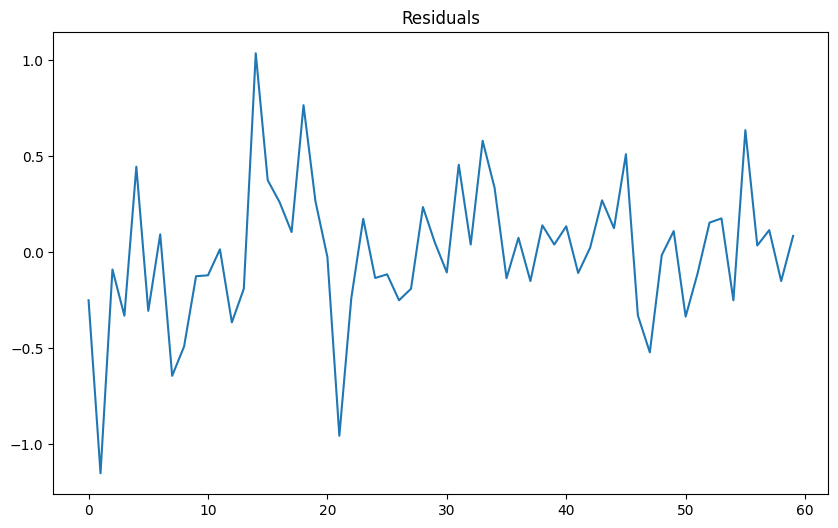


Resultados Previstos:
Data = 2023-11-14 00:00:00, Preço previsto = 22.33, Preço real = 22.08, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 23.49, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 23.58, Preço real = 23.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 23.91, Preço real = 23.58, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-20 00:00:00, Preço previsto = 23.46, Preço real = 23.91, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-21 00:00:00, Preço previsto = 23.76, Preço real = 23.46, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-22 00:00:00, Preço previsto = 23.67, Preço real = 23.76, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-24 00:00:00, Preço previsto = 24.32, Preço real = 23

In [ ]:
PRA_RSI14 = datasil()

# Cálculo do indicador RSI-14
delta = PRA_RSI14['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
PRA_RSI14['RSI14'] = 100 - (100 / (1 + rs))

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
PRA_RSI14['Target'] = (PRA_RSI14['Open'].shift(-1) > PRA_RSI14['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do RSI-14 e do shift
PRA_RSI14.dropna(inplace=True)

# Seleção de recursos e rótulos
X = PRA_RSI14[['Open', 'RSI14']].values
y = PRA_RSI14['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(PRA_RSI14['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))


####OBV

[*********************100%%**********************]  1 of 1 completed

Accuracy: 0.4307692307692308
Confusion Matrix:
 [[ 3 31]
 [ 6 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.09      0.14        34
           1       0.45      0.81      0.57        31

    accuracy                           0.43        65
   macro avg       0.39      0.45      0.36        65
weighted avg       0.39      0.43      0.35        65

Mean Squared Error (MSE): 0.13304575683116582
R-squared (R2): 0.8174880698164638
Root Mean Squared Error (RMSE): 0.3647543787690092
Mean Absolute Error (MAE): 0.2703125476837158
Mean Absolute Percentage Error (MAPE): 1.1542020483732565


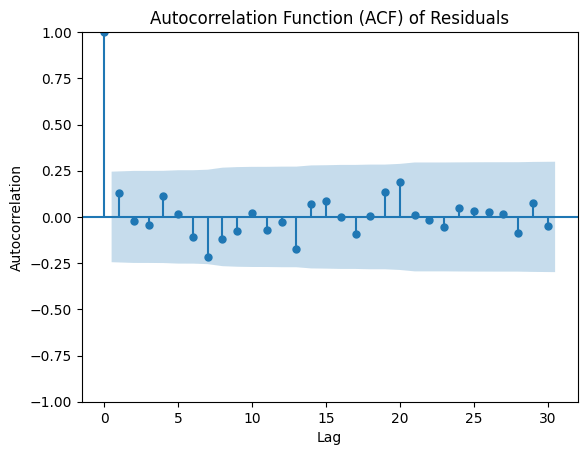

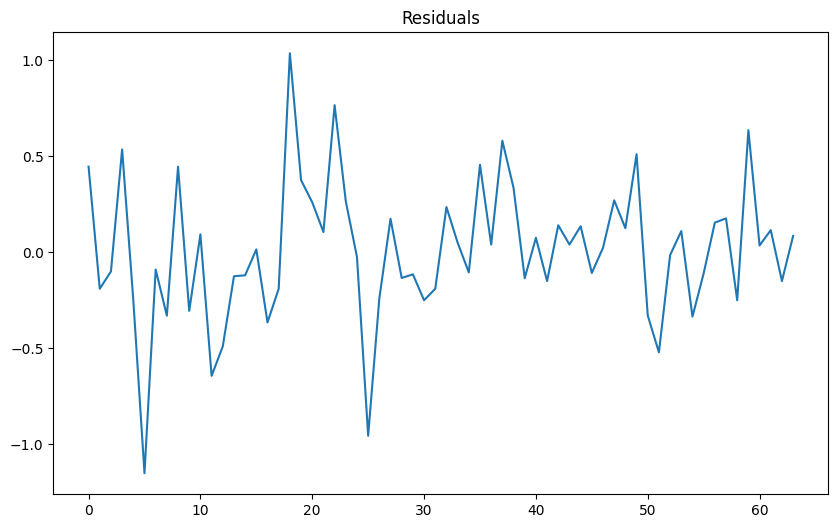


Resultados Previstos:
Data = 2023-11-08 00:00:00, Preço previsto = 22.33, Preço real = 22.77, Comportamento previsto = Desce, Comportamento real = Desce
Data = 2023-11-09 00:00:00, Preço previsto = 22.52, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-10 00:00:00, Preço previsto = 22.62, Preço real = 22.52, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-13 00:00:00, Preço previsto = 22.08, Preço real = 22.62, Comportamento previsto = Sobe, Comportamento real = Desce
Data = 2023-11-14 00:00:00, Preço previsto = 22.33, Preço real = 22.08, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-15 00:00:00, Preço previsto = 23.49, Preço real = 22.33, Comportamento previsto = Sobe, Comportamento real = Sobe
Data = 2023-11-16 00:00:00, Preço previsto = 23.58, Preço real = 23.49, Comportamento previsto = Desce, Comportamento real = Sobe
Data = 2023-11-17 00:00:00, Preço previsto = 23.91, Preço real = 23.58

In [ ]:
PRA_obv = datasil()

# Cálculo do indicador OBV
PRA_obv['OBV'] = (np.sign(PRA_obv['Close'].diff()) * PRA_obv['Volume']).fillna(0).cumsum()

# Cria uma coluna para categorizar se o preço de abertura vai subir (1) ou descer (0)
PRA_obv['Target'] = (PRA_obv['Open'].shift(-1) > PRA_obv['Open']).astype(int)

# Remove as últimas linhas com valores ausentes resultantes do cálculo do OBV e do shift
PRA_obv.dropna(inplace=True)

# Seleção de recursos e rótulos
X = PRA_obv[['Open', 'OBV']].values
y = PRA_obv['Target'].values

# Divide os dados em conjuntos de treinamento e teste mantendo a ordem temporal
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o modelo GaussianNB
model = GaussianNB()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões usando o modelo treinado
y_pred = model.predict(X_test)

# Avalia o desempenho do modelo de classificação
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Para as métricas de regressão, utilizamos os preços reais e previstos
y_test_prices = X_test[:, 0]
y_pred_prices = X_test[:, 0].copy()  # Inicializa com valores reais de abertura
y_pred_prices[:-1] = y_pred_prices[1:]  # Previsão para o próximo dia

# Calcula as métricas de avaliação
mse = mean_squared_error(y_test_prices[:-1], y_pred_prices[:-1])
r2 = r2_score(y_test_prices[:-1], y_pred_prices[:-1])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_prices[:-1], y_pred_prices[:-1])
mape = np.mean(np.abs((y_test_prices[:-1] - y_pred_prices[:-1]) / y_test_prices[:-1])) * 100

print('Mean Squared Error (MSE):', mse)
print('R-squared (R2):', r2)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Calcula os resíduos do modelo (diferença entre real e previsto)
residuals = y_test_prices[:-1] - y_pred_prices[:-1]

# Plota a ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plota os resíduos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Função para converter 0 e 1 em "Desce" e "Sobe"
def comportamento_label(valor):
    return "Sobe" if valor == 1 else "Desce"

print("\nResultados Previstos:")
for i, (Date, pred) in enumerate(zip(PRA_obv['Date'][train_size+1:], y_pred[:-1])):  # Adicionando a data ao loop
    actual_price = X_test[i, 0]
    predicted_price = y_pred_prices[i]
    comportamento_previsto = comportamento_label(pred)
    comportamento_real = comportamento_label(y_test[i])
    print("Data = {}, Preço previsto = {:.2f}, Preço real = {:.2f}, Comportamento previsto = {}, Comportamento real = {}".format(
        Date, predicted_price, actual_price, comportamento_previsto, comportamento_real))
